In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import os, pickle
from pose_class import Trajectory
import pdb
import pandas as pd

import random
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import pearsonr,spearmanr
from scipy.stats import f_oneway,levene
from scipy.stats import ttest_ind

from statsmodels.stats.multicomp import pairwise_tukeyhsd

"""
distance_vector = np.load('./distance_vector.npy')
angle_vector = np.load('./angle_vector.npy')
posture_distance = np.load('./posture_vector.npy')
posture_angle = np.load('./posture_angle_vector.npy')


print(np.shape(distance_vector))
print(np.shape(posture_distance))
"""
print('ready set go!')

ready set go!


In [2]:
## Define bootstrap function

  
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

<IPython.core.display.Javascript object>


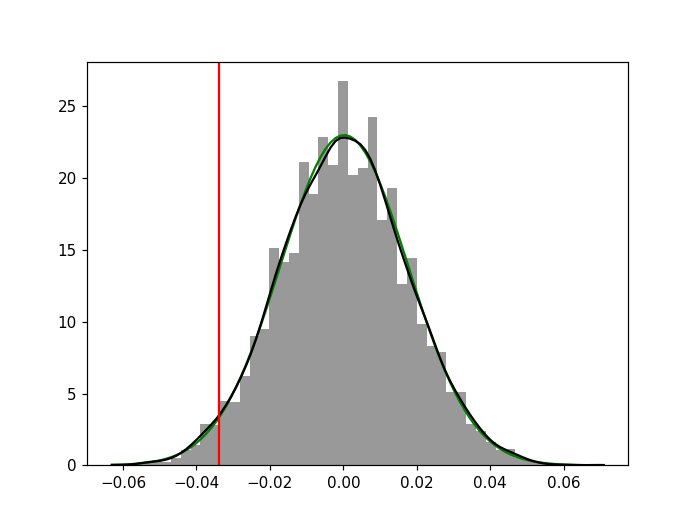

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


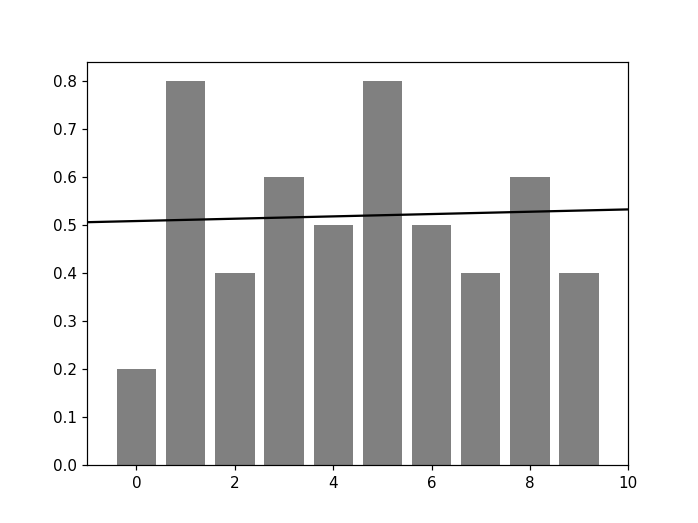

<IPython.core.display.Javascript object>


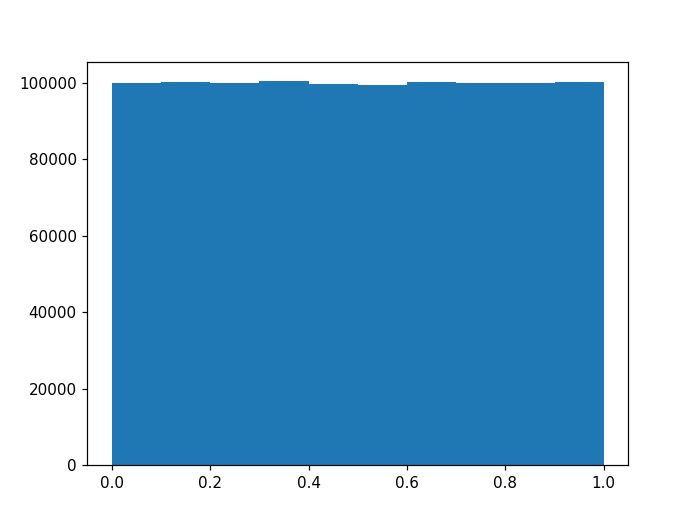

In [75]:
## Define simulation to generate confidence intervals for CSD Selectivity 
## (scrap code way down at the bottom)

# Parameter class to keep things tidy
class CSD_Params:
    def __init__(self,n_birds = 1,n_blocks=10,n_songs=10,n_iterations = 10000,
                 sort_me=True,print_me = False,plot_me=False):
        self.n_birds = n_birds
        self.n_blocks = n_blocks
        self.n_songs = 10
        self.n_iterations = n_iterations
        self.sort_me = sort_me
        self.print_me = print_me
        self.plot_me = plot_me
    def report(self):
        print('n_birds: ',self.n_birds)
        print('n_blocks: ',self.n_blocks)
        print('n_songs:',self.n_songs)
        print('n_iterations:',self.n_iterations)
        print('sorted:',self.sort_me)
"""       
class bird:
    def __init__(self,id=0,selectivity=5):
        print('make a bird class!')
        
 """       
# Given a slope and response rate, simulates a distribution and provies as 
# output: p,z-score,(mu,sigma,parameters)
def csd_sim(x_slope=None,r_response=.5,params = CSD_Params(),dist = None):
    rands = []
    if dist==None:
        if r_response == 1:
            r_response = .999
        elif r_response == 0:
            r_response = .001
        slopes = np.zeros(params.n_iterations)
        
        for i in range(params.n_iterations):
            postures = np.zeros([params.n_birds,params.n_blocks,params.n_songs])
            for n in range(params.n_birds):
                for b in range(params.n_blocks):
                    
                    for s in range(params.n_songs):
                        my_rand = np.random.random()
                        rands.append(my_rand)
                        if my_rand < r_response:
                            postures[n,b,s] = 1
                            
            ## Sum it up for each bird across blocks
            counts = np.sum(postures,1)
            """
            if params.sort_me:
                sorted_counts = np.zeros_like(counts)
                ## This should sort the mean, not each bird.
                for n in range(params.n_birds):
                    sorted_counts[n] = np.sort(counts[n])[::-1]
                counts = sorted_counts"""
                
            ratios = np.mean(counts / params.n_blocks,0)

            if params.sort_me:
                ratios = np.sort(ratios)[::-1]
            slope,intercept = np.polyfit(np.arange(len(ratios)),ratios,1)
            slopes[i] = slope
        mu,sig = (np.mean(slopes),np.std(slopes))
    else:
        mu,sig = dist
    if x_slope != None:
        z = (x_slope - mu) / sig
        p = norm.sf(abs(z))
        if not params.sort_me:
            p = p * 2
    else:
        z = mu - 1.96 * sig
        p = .05
    if params.print_me:
        print('response rate:',r_response)
        params.report()
        print('slope threshold for 95% confidence:',(mu + -1.96 * sig))
        if x_slope != None:
            print('slope: ',x_slope)
            print('z-score=',np.round(z,4))
            print('p=',np.round(p,4))
    if params.plot_me:
        fig,ax = plt.subplots()
        if dist == None:
            ax.hist(slopes,bins=50,normed=True,color='gray',alpha=.8)
            min_s = min(slopes)
            max_s = max(slopes)
            fit_kde = gaussian_kde(slopes)
        else:
            min_s = mu + -5 * sig
            max_s = mu + 5 * sig
        xs = np.linspace(min_s,max_s,100)
        ax.plot(xs,norm.pdf(xs,mu,sig),color = 'green')
        ax.plot(xs,fit_kde(xs),color='black')
        title = 'Slope Distribution'
        if x_slope != None:
            ax.axvline(x_slope,color='green')
            title += (' (p=' + str(p) + ')')
        if params.sort_me:
            pass
            #ax.set_xlim([min_s,0])
        ax.axvline(mu - 1.96 * sig,color='red')
        
        #ax.set_title(title)

        fig.show()
        fig2,ax2 = plt.subplots()
        ax2.bar(range(len(ratios)),ratios,color='gray')
        fit_line = np.poly1d(np.polyfit(np.arange(len(ratios)),ratios,1))
        ax2.plot(np.arange(-1,11),fit_line(np.arange(-1,11)),color='black')
        
        params.fig = fig2
        params.ax = ax2
        
    params.rands= rands
    import pdb
    #pdb.set_trace()
    return p,z,(mu,sig,params)

params = CSD_Params(plot_me=True,sort_me=False)
params.r_response = .5
p,z,(mu,sig,params) = csd_sim(params=params)

fig,ax = params.fig,params.ax
#ax.axvline(-0.0544,color='purple')
#ax.axvline(mu - 3.0 * sig,color='red',linestyle=':')
#ax.axvline()
ax.set_xlim([-1,10])
fig.show()
fig.savefig('/home/ammon/Desktop/PaperFigs/3b2.svg')

fig2,ax2 = plt.subplots()
ax2.hist(params.rands)
fig2.show()

1000000
1000000


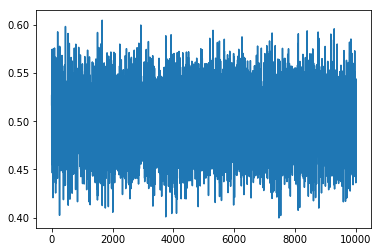

In [186]:
print(len(np.unique(params.rands)))
print(len(params.rands))

means = []
for i in np.arange(0,len(params.rands),100):
    means.append(np.mean(params.rands[i:i+100]))
    
plt.plot(means)
plt.show()

In [211]:
np.random.random()

0.940236160866336

In [4]:
## Import data: [Bird, Block, Song, [Posture,Latency,Duration,Movement]]

song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
bird_list = ['CB-White','CB-Orange','CB-Yellow','CB-Red','CB-LB2','CB-Y2','CB-R2']
song_dict = dict(zip(song_list,range(10)))
bird_dict = dict(zip(bird_list,range(len(bird_list))))
data_array = np.empty([7,14,10,4])
data_key = np.empty([7,14,10,3],dtype=object)
data_array.fill(np.nan)

count = 0 
t_count = 0
p_count = 0
good_list = sorted(os.listdir('./SeqClasses/'))
crap_list = sorted(os.listdir('./CrapSeqs/'))


#file_list = sorted(os.listdir('./SeqClasses/'))
file_lists = [good_list,crap_list]
dir_list = ['./SeqClasses/','./CrapSeqs/']
for f in range(2):
    file_list = file_lists[f]
    seq_dir = dir_list[f]
    for s in file_list:

        seq = pickle.load(open(seq_dir + s,'rb'))
        if '2018' in seq.seq_name:
            #print('still skipping 2018 for now')
            continue
        try:
            block = seq.block
        except:
            #print(seq.seq_name,'has no block somehow...')
            import pdb
            pdb.set_trace()
        if block < 0:
            block = 14
        if seq.bird=='no bird' or seq.bird=='males':
            continue
        if seq.bird=='unknown' or seq.song == 'unknown':
            continue
        try:
            song_index = song_dict[seq.song]
            bird_index = bird_dict[seq.bird]
        except:
            print(seq.seq_name,'broke something!')

        try:
            data_key[bird_index,int(block),song_index,0] = seq.seq_name
            data_key[bird_index,int(block),song_index,1] = seq.machine
            data_key[bird_index,int(block),song_index,2] = 1 ## This means it doesn't suck
            if 'Crap' in seq_dir:
                data_key[bird_index,int(block),song_index,2] = 0  ## This means it sucks
        except:
            print("Something Failed!")
        try:
            data_array[bird_index,int(block),song_index,0] = seq.posture
            if seq.ts[0] == 0:
                ## No timing data, grab a likely 5s 
                response_window = (seq.ts > 5) & (seq.ts < 10)
            else:
                response_window = (seq.ts > 0) & (seq.ts < 5)
            ## A bunch of them have a mismatch between ts and data. I need to fix this
            if len(response_window) != len(seq.data):
                #print('data mismatch :(')
                if len(response_window) > len(seq.data):
                    #print('fixing it...')
                    response_window = response_window[:len(seq.data)]
                elif len(response_window) < len(seq.data):
                    print('we are in trouble.')
                    pdb.set_trace()
            movement = np.sum(abs(seq.smooth_data[response_window]))
            data_array[bird_index,int(block),song_index,3] = movement
            #print('added posture')
            p_count +=1
        except:
            pdb.set_trace()
            print('posture failed...')
            pass
        try:
            
            data_array[bird_index,int(block),song_index] = [seq.posture,seq.t_vmax,seq.duration,movement]
            #print('Found a posture : ',seq.seq_name,seq.posture)
            t_count += 1
        except:
            #print('no timing data for',seq.seq_name,': moving on...')
            pass
    
print(p_count,t_count)    

675 162


In [5]:
## Reshape Birdview 3 data into similar array

group1_file = '/data/birds/postures/2019_playbacks_1.csv'
group2_file = '/data/birds/postures/2019_playbacks_2.csv'

group1_df = pd.read_csv(group1_file)
group2_df = pd.read_csv(group2_file)

group1_df = group1_df.fillna(0)
group2_df = group2_df.fillna(0)

p_array1 = np.array(group1_df.iloc[:,6:15])
p_array2 = np.array(group2_df.iloc[:,6:15])

group1_list = list(group1_df.columns[6:15])
group2_list = list(group2_df.columns[6:15])
bird_list3 = []
bird_list3.extend(group1_list)
bird_list3.extend(group2_list)

print(bird_list3)
## [Bird, Block, Song, [Posture,Latency,Duration]]
bv3_array = np.empty([18,11,10,3])
bv3_array.fill(np.nan)

group1_dates = group1_df
# for each song
for b in range(10):
    song_name = song_list[b] + '.wav'
    print(b,song_name)
    bv3_array[:9,:,b,0] = np.transpose(group1_df.loc[group1_df['SongFile'] == song_name].iloc[:,6:15])
    bv3_array[9:,:,b,0] = np.transpose(group2_df.loc[group2_df['SongFile'] == song_name].iloc[:,6:15])

binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0

['WH20', 'WH18', 'WH13', 'Wh14', 'WH17', 'GR11', 'WH15', 'WH23', 'WH12 (22)', 'BK24', 'WH19', 'WH16', 'WH24', 'BK21', 'LB20', 'BK17', 'GR13', 'WH22']
0 BDY.wav
1 BOD.wav
2 ND.wav
3 LB.wav
4 2M.wav
5 DBR.wav
6 GRG.wav
7 WG.wav
8 LNR.wav
9 DMG.wav


In [6]:
print(np.shape(bv3_array))
day_list = []

day_list.extend(pd.unique(group1_df['Date']))
day_list.extend(pd.unique(group2_df['Date']))

hour_list = [6,7,8,9,10,11,12,13,15,17,18]


date_dict = dict(zip(day_list,range(len(day_list))))
hour_dict = dict(zip(hour_list,range(len(hour_list))))

bv3_bytime = np.empty([len(day_list),len(hour_list),18,10])
bv3_bytime.fill(np.nan)

for index,row in group1_df.iterrows():
    date = row['Date']
    hour = int(row['Time'].split(':')[0])

    date_index = date_dict[date]
    hour_index = hour_dict[hour]
    song_index = song_dict[row['SongFile'].split('.')[0]]
    block = int(row['Block']) - 1

    bv3_bytime[date_index,hour_index,:9,song_index] = row.iloc[6:15]


for index,row in group2_df.iterrows():
    date = row['Date']
    hour = int(row['Time'].split(':')[0])

    date_index = date_dict[date]
    hour_index = hour_dict[hour]
    song_index = song_dict[row['SongFile'].split('.')[0]]
    block = int(row['Block']) - 1

    bv3_bytime[date_index,hour_index,9:,song_index] = row.iloc[6:15]



(18, 11, 10, 3)


[0.3968254  0.12698413 0.06349206 0.00793651 0.12698413 0.11904762
 0.07142857 0.11111111 0.17460317 0.14285714 0.11904762 0.30952381
 0.07142857 0.14285714 0.16666667 0.12222222 0.75       0.56349206
 0.33333333 0.21527778 0.18055556 0.0625     0.34126984 0.22222222
 0.27083333 0.10416667 0.06349206 0.23809524 0.07936508 0.14285714
 0.20634921 0.05555556]
[0.3968254  0.12698413 0.06349206 0.00793651 0.12698413 0.11904762
 0.07142857 0.11111111 0.17460317 0.14285714 0.11904762 0.30952381
 0.07142857 0.14285714 0.16666667 0.12222222 0.75       0.56349206
 0.33333333 0.21527778 0.18055556 0.0625     0.34126984 0.22222222
 0.27083333 0.10416667 0.06349206 0.23809524 0.07936508 0.14285714
 0.20634921 0.05555556]
(0.06271199250417489, 0.7331229080319388)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


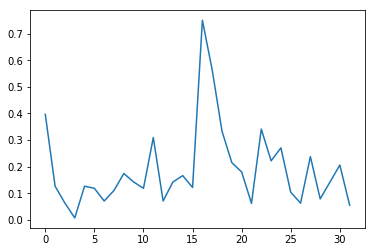

In [7]:
print(np.nanmean(bv3_bytime,axis=(1,2,3)))
day_means = np.nanmean(bv3_bytime,axis=(1,2,3))
hour_means = np.nanmean(bv3_bytime[:,:,:9],axis=(0,2,3))
fig,ax = plt.subplots()
ax.plot(day_means)
print(day_means)
print(pearsonr(range(len(day_means)),day_means))

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


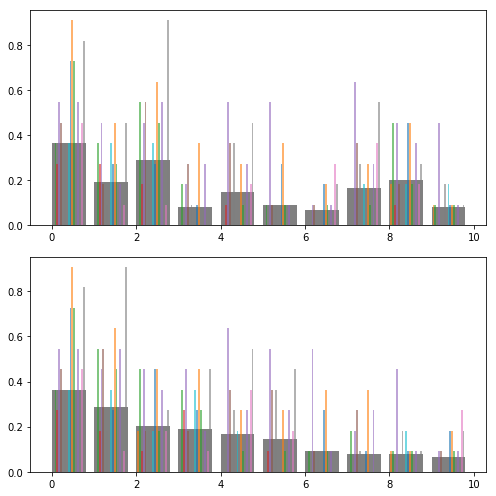

In [8]:
## plot response ratios for this group: 

songs_bybird = np.nanmean(binary_array3,axis=(1))
n_birds = 18
n_songs = 10
canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)

for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = songs_bybird[b,:,0]
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 

    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)

fig,(ax,ax2) = plt.subplots(2)

song_means = np.nanmean(canon_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]


ax.bar(np.arange(n_songs) + .4,song_means,color='gray',alpha=1)
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means,axis=0),color='gray')
for n in range(n_birds):
    #print(np.shape(canon_means),np.shape(bird_list))
    ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list3[n],alpha=.6)
    ax2.bar(np.arange(n_songs) + n * .8/n_birds,sorted_means[n],width=.8/n_birds,alpha=.6)
    
#fig.legend()
fig.set_size_inches(7,7)
fig.tight_layout()

fig.show()


In [9]:
## Define binary arrays

lesions_birds = np.array([1,2,4,7,8,9,11,13,15,17])
control_birds = np.array([0,3,5,6,10,12,14,16])

binary_array = np.array(data_array)
binary_array[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]

binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0

binary_array_all = np.zeros([25,11,10])

binary_array_all[:7] = binary_array[:,:11,:,0]
binary_array_all[7:] = binary_array3[:,:,:,0]

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RankWarning: Polyfit may be poorly conditioned
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RankWarning: Polyfit may be poorly conditioned
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[ 0  1  2  3  4  5  6  7 10 12 13 17 19 21 23]
(25, 10) (19, 10)
6 hide it!
18 hide it!
3
24 hide it!
11 hide it!
14 hide it!
9 hide it!
16 hide it!
13 hide it!
8 hide it!
7 hide it!
15 hide it!
20 hide it!
22 hide it!


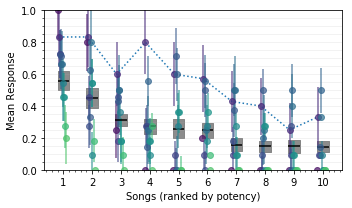

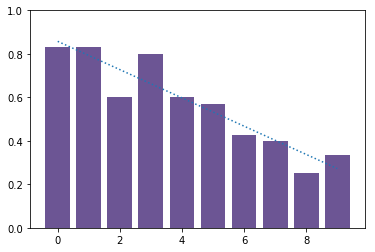

In [307]:
## plot for all the groups (FIG 1)

## plot response ratios for this group: 

plot_array = binary_array_all
plot_birdlist = np.hstack([bird_list,bird_list3])


means_bybird = np.nanmean(plot_array,axis=(1))
std_bybird = np.nanstd(plot_array,axis=1)
n_bybird = np.sum(~np.isnan(plot_array),axis=1)


n_birds = np.shape(plot_array)[0]
n_songs = np.shape(plot_array)[2]

canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)
true_std = np.empty_like(true_means)
true_n = np.empty_like(true_means)
for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = means_bybird[b,:]
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 

    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_std[b] = np.sort(std_bybird[b,:])[::-1]
    true_n[b] = np.sort(n_bybird[b,:])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)

fig,ax2 = plt.subplots()

song_means = np.nanmean(canon_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]

non_lesions = [0,3,5,6,10,12,14,16]
safe_indices = np.hstack([np.arange(7),np.array(non_lesions) + 7])
print(safe_indices)

responsive_birds = np.array(np.nansum(sorted_means,1) > 0)
responsive_birds_safe = np.intersect1d(responsive_birds,safe_indices)

filtered_means = sorted_means[np.nansum(sorted_means,1) > 0]

print(np.shape(sorted_means),filtered_means.shape)
#mean_bar = np.nanmean(sorted_means,axis=0)
#sem_bar = np.nanstd(sorted_means,axis=0) / np.sqrt(np.sum(~np.isnan(sorted_means),axis=0))

mean_bar = np.nanmean(filtered_means,axis=0)
sem_bar = np.nanstd(filtered_means,axis=0) / np.sqrt(np.sum(~np.isnan(filtered_means),axis=0))

desc_order = np.argsort(sorted_means[:,0])[::-1]

color_map = cm.get_cmap('viridis')
for n in range(len(desc_order)):
    i = desc_order[n]

    if responsive_birds[i] == 0 or i not in safe_indices:
        print(i,'hide it!')
        opacity = .2
        continue
    else:
        opacity = .7
    ax2.errorbar(1 + np.arange(n_songs) + n * .4/n_birds -.2, sorted_means[i],
                 yerr = true_std[i] / np.sqrt(true_n[i]),fmt='o',color=color_map(n / len(desc_order)),alpha=opacity)
    if i == 5:
        print(n)
        ax2.plot(1 + np.arange(n_songs) + n * .4/n_birds - .2, sorted_means[i],linestyle=':')
        plot_means=sorted_means[i]
    #fig.legend()
    
for s in range(n_songs):
    ax2.fill_between([1+s-.2,1+s+.2],mean_bar[s] + sem_bar[s],mean_bar[s] - sem_bar[s],color='gray',alpha=.9)
ax2.hlines(mean_bar,1+np.arange(n_songs)-.2,1+np.arange(n_songs) + .2,color='black')


ax2.minorticks_on()
ax2.yaxis.grid(which='major',alpha=.2)
ax2.yaxis.grid(which='minor',alpha=.2)
ax2.set_ylim((0,1))

ax2.set_xlabel('Songs (ranked by potency)')
ax2.set_ylabel('Mean Response')
ax2.set_xticklabels(np.arange(10) + 1)
ax2.set_xticks(np.arange(10) + 1)
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3f.svg')
#fig.savefig('/home/ammon/Desktop/PaperFigs/3f.png')
fig.show()

fig2,ax2 = plt.subplots()
ax2.bar(range(10),plot_means,color=color_map(3 / len(desc_order)),alpha=.8)
means_line = np.poly1d(np.polyfit(range(10),plot_means,1))
ax2.plot(range(10),means_line(range(10)),linestyle=':')
ax2.set_ylim([0,1])
fig2.show()
fig2.savefig('/home/ammon/Desktop/PaperFigs/3d2.svg')


(25, 11, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


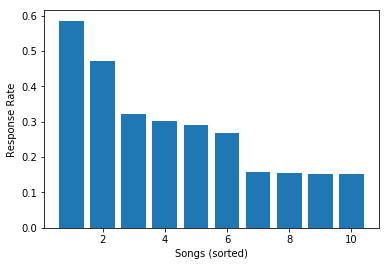

In [11]:
print(np.shape(binary_array_all))
active_birds = np.nansum(binary_array_all,axis=(1,2)) > 3
active_means = np.nanmean(binary_array_all[active_birds],(0,1))

fig,ax = plt.subplots()
ax.bar(range(1,11),sorted(active_means)[::-1])
#ax.set_ylim([0,1])
ax.set_ylabel('Response Rate')
ax.set_xlabel('Songs (sorted)')

fig.savefig('/home/ammon/Desktop/PaperFigs/example_sort.svg')
fig.show()

In [19]:
b = 5
for b in range(len(plot_array)):
    #print(plot_array.shape)
    means_nob = np.nanmean(plot_array[np.arange(len(plot_array)) != b],axis=(0,1))
    #print(means_nob.shape)
    order_nob = np.argsort(means_nob)[::-1]
    print(order_nob)

[0 2 8 1 7 4 9 3 5 6]
[0 2 8 1 7 4 3 5 6 9]
[0 2 8 1 7 4 5 9 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 5 9 3 6]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 5 6 9 3]
[0 2 8 7 1 4 6 9 5 3]
[0 2 8 7 1 4 9 5 6 3]
[0 2 8 1 7 4 6 3 9 5]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 6 5 9 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 7 1 4 5 6 3 9]
[0 2 8 7 1 4 9 3 6 5]
[0 2 8 7 1 4 9 6 5 3]
[0 2 8 7 1 4 9 3 5 6]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 6 3]
[0 2 8 1 7 4 9 5 3 6]
[0 2 8 1 7 4 5 9 3 6]


In [308]:
## Analyze selectivity of each group

all_song_means = np.nanmean(binary_array_all,axis=(1,0))
song_means3 = np.nanmean(binary_array3[:,:,:,0],axis=(1,0))
song_means1 = np.nanmean(binary_array3[:9,:,:,0],axis=(1,0))
song_means2 = np.nanmean(binary_array3[9:,:,:,0],axis=(1,0))
song_means0 = np.nanmean(binary_array[:,:,:,0],axis=(1,0))

print('Averaging across all, birds rank songs:')
params = CSD_Params(sort_me=True)
params.n_birds = 25
params.n_blocks = 11
resp_by_bird = np.zeros(params.n_birds)
sel_by_bird = np.zeros_like(resp_by_bird)
p_by_bird = np.zeros_like(resp_by_bird)
z_by_bird = np.zeros_like(resp_by_bird)

resp = np.nansum(binary_array_all) / np.sum(~np.isnan(binary_array_all))
sorted_song_means = all_song_means[np.argsort(all_song_means)[::-1]]
slope,_ = np.polyfit(range(10),sorted_song_means,1)
p,z,_ = csd_sim(slope,resp,params)

print('slope=',slope,'p=',p,'z:',z,'\n')

## If we want, we can look at each individual paradigm also. 

print('Songs are correlated with eachother (strongly...)')
print(spearmanr(song_means1,song_means2))

print('\nSong means are correlated across paradigm (barely...)')
print(spearmanr(song_means0,song_means3))

print('\nSongs only weakly correlated with Canonical Rankings')
print(spearmanr(np.arange(10),all_song_means))

print('\nIndividual Selectivity:')
print('0-6 are birdview, 7-24 are boxes')
count = 0
#for b in range(25):
print(safe_indices)
for b in safe_indices:
    print('\n--Bird:',b)
    means_nob = np.nanmean(plot_array[np.arange(len(plot_array)) != b],axis=(0,1))
    order_nob = np.argsort(means_nob)[::-1]
    reorder = order_nob
    #reorder = np.arange(10)
    means_b = np.nanmean(binary_array_all[b],0)[reorder]
    xs = np.arange(10)[~np.isnan(means_b)]
    ys = means_b[~np.isnan(means_b)]
    p = np.nansum(binary_array_all[b])
    q = np.sum(~np.isnan(binary_array_all[b]))
    if q == 0:
        print('we have a problem...')
        resp = np.nan
    else:
        resp = p / q
    print('Responsivity:',np.round(resp,3))
    resp_by_bird[b] = resp
    if len(ys) > 0:
        slope,_ = np.polyfit(xs,ys,1)
        print('Slope:',np.round(slope,3))
        params = CSD_Params(sort_me=False)
        p,z,_ = csd_sim(slope,resp,params)
        if z>0:
            d = -1
        else:
            d = 1
        if p < .05 and z < 0:
            print('***')
            count += 1
        print('p=',np.round(p,3),'z-score:',np.round(z,3))
    else:
        print('no info here')
        p = np.nan
    sel_by_bird[b] = np.log(1/p) * d
    p_by_bird[b] = p
    z_by_bird[b] = z
    
print('Selective birds=',count)

Averaging across all, birds rank songs:
slope= -0.03189249723835484 p= 3.1706709170746755e-42 z: -13.566336216989267 

Songs are correlated with eachother (strongly...)
SpearmanrResult(correlation=0.8776799450195786, pvalue=0.0008428553839887767)

Song means are correlated across paradigm (barely...)
SpearmanrResult(correlation=0.6504589317376691, pvalue=0.04170545108280406)

Songs only weakly correlated with Canonical Rankings
SpearmanrResult(correlation=-0.3696969696969697, pvalue=0.2930500752928223)

Individual Selectivity:
0-6 are birdview, 7-24 are boxes
[ 0  1  2  3  4  5  6  7 10 12 13 17 19 21 23]

--Bird: 0
Responsivity: 0.404
Slope: -0.031
p= 0.071 z-score: -1.804

--Bird: 1
Responsivity: 0.516
Slope: -0.021
p= 0.221 z-score: -1.225

--Bird: 2
Responsivity: 0.387
Slope: -0.022
p= 0.188 z-score: -1.318

--Bird: 3
Responsivity: 0.02
Slope: -0.011
***
p= 0.023 z-score: -2.274

--Bird: 4
Responsivity: 0.244
Slope: -0.095
***
p= 0.0 z-score: -6.363

--Bird: 5
Responsivity: 0.571
S

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


p= 0.999 z-score: -0.001

--Bird: 10
Responsivity: 0.091
Slope: -0.026
***
p= 0.008 z-score: -2.658

--Bird: 12
Responsivity: 0.255
Slope: -0.035
***
p= 0.019 z-score: -2.352

--Bird: 13
Responsivity: 0.0
Slope: 0.0
p= 0.998 z-score: -0.002

--Bird: 17
Responsivity: 0.236
Slope: -0.04
***
p= 0.007 z-score: -2.689

--Bird: 19
Responsivity: 0.209
Slope: -0.057
***
p= 0.0 z-score: -4.016

--Bird: 21
Responsivity: 0.273
Slope: -0.044
***
p= 0.004 z-score: -2.843

--Bird: 23
Responsivity: 0.164
Slope: -0.022
p= 0.086 z-score: -1.717
Selective birds= 8


(18, 11, 10, 3)
(10,)
()

## Means and std of Response Rate equivalent
0.1534090909090909 +- 0.3603813837249882
0.17909090909090908 +- 0.3834284227491499

## No difference in variation of selectivity or response rate
LeveneResult(statistic=0.43668463349779346, pvalue=0.5181295032995128)
LeveneResult(statistic=1.7795353435491854, pvalue=0.20088464687112598)

## Very high correlation in rank order
SpearmanrResult(correlation=0.8424242424242423, pvalue=0.0022200312259168407)
## ANNOVAs:?


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


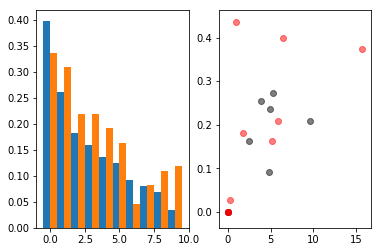

In [21]:

true_order = np.argsort(song_means)[::-1]
song_order = range(n_songs)
song_order = true_order

print(np.shape(binary_array3))
birdx_means = np.nanmean(binary_array3[16],0)

control_means = np.nanmean(binary_array3[control_birds,:,:,0],axis=(1,0))
lesion_means = np.nanmean(binary_array3[lesions_birds,:,:,0],axis=(1,0))

print(np.shape(lesion_means))
## Does their overall response rate vary?
control_mu = np.nanmean(binary_array3[control_birds,:,:,0])
lesion_mu = np.nanmean(binary_array3[lesions_birds,:,:,0])

control_std = np.nanstd(binary_array3[control_birds,:,:,0])
lesion_std = np.nanstd(binary_array3[lesions_birds,:,:,0])
print(np.shape(control_std))

print('\n## Means and std of Response Rate equivalent')
print(control_mu,'+-',control_std)
print(lesion_mu,'+-',lesion_std)

print('\n## No difference in variation of selectivity or response rate')
print(levene(sel_by_bird[lesions_birds + 7],sel_by_bird[control_birds + 7]))
print(levene(resp_by_bird[lesions_birds + 7],resp_by_bird[control_birds + 7]))

control_order = np.argsort(control_means)
lesion_order = np.argsort(lesion_means)

print('\n## Very high correlation in rank order')
print(spearmanr(control_order,lesion_order))


print('## ANNOVAs:?')
fig, (ax1,ax2) = plt.subplots(1,2)
#ax.bar(range(10),birdx_means[song_order])
ax1.bar(np.arange(10)-.25,control_means[song_order],width=.5)
ax1.bar(np.arange(10)+.25,lesion_means[song_order],width = .5)

for n in range(len(binary_array3)):
    i = n+7
    if n in lesions_birds:
        my_color = 'red'
    else:
        my_color = 'black'
    ax2.scatter(sel_by_bird[i],resp_by_bird[i],color=my_color,alpha=.5)
    
fig.show()

(25,) (25,)
[0.40425532 0.51648352 0.38666667 0.01960784 0.24390244 0.57142857
        nan 0.         0.         0.         0.09090909 0.
 0.25454545 0.         0.         0.         0.         0.23636364
 0.         0.20909091 0.         0.27272727 0.         0.16363636
 0.        ] [2.64119983e+00 1.51167482e+00 1.67346774e+00 3.77340160e+00
 2.23405922e+01 7.35007296e+00            nan 5.30527273e-04
 0.00000000e+00 0.00000000e+00 4.84626333e+00 0.00000000e+00
 3.98089611e+00 1.86861400e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.93827571e+00 0.00000000e+00 9.73502022e+00
 0.00000000e+00 5.41128499e+00 0.00000000e+00 2.45344253e+00
 0.00000000e+00]
[1.58655254e-01 1.58679452e-01 1.58703653e-01 ... 1.28255584e-12
 1.28164077e-12 1.28072634e-12]
[-1.84102165 -1.84086914 -1.84071663 ... 27.38216628 27.38288001
 27.38359375] [2.41970725e-01 2.41994922e-01 2.42019119e-01 ... 9.15392307e-12
 9.14751779e-12 9.14111691e-12]
SpearmanrResult(correlation=0.8140362959824032, pvalue=1.30

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


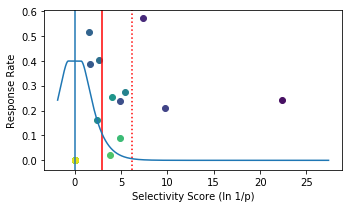

In [309]:
### plot selectivity vs responsivity

fig,ax = plt.subplots()
print(np.shape(resp_by_bird),np.shape(sel_by_bird))
n_birds = len(resp_by_bird)
for n in range(n_birds):
    i = desc_order[n]
    ax.scatter(sel_by_bird[i],resp_by_bird[i],color=color_map(n/n_birds))
"""    if i == 5:
        ax.scatter(sel_by_bird[i],resp_by_bird[i],color=color_map(n/n_birds),s=200)"""

ax.axvline(np.log(1/.05),color='red')
ax.axvline(np.log(25/.05),linestyle=':',color='red')

ax.set_ylabel('Response Rate')
ax.set_xlabel('Selectivity Score (ln 1/p)')

print(resp_by_bird,sel_by_bird)

z_scores = np.arange(-1,7,.0001)
p_values = norm.sf(abs(z_scores))
print(p_values)

log_p_values = np.log(1/p_values) * np.sign(z_scores)

norm_ys = norm.pdf(z_scores,0,1)
print(log_p_values,norm_ys)
ax.plot(log_p_values,norm_ys)
ax.axvline(0)
#ax.set_xlim([min(resp_by_bird)-1,max(resp_by_bird)])
#ax.set_ylim([min(sel_by_bird)-1,max(sel_by_bird)])

### Responsivity and selectivity are positively correlated, 
### but that can be interepreted as "p values are better when you have larger sample sizes"
print(spearmanr(resp_by_bird[~np.isnan(resp_by_bird)],sel_by_bird[~np.isnan(resp_by_bird)]))

fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3e.svg')
fig.savefig('/home/ammon/Desktop/PaperFigs/3e.png')
fig.show()

In [167]:
print(1/.05)
np.log(20)

20.0


2.995732273553991

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


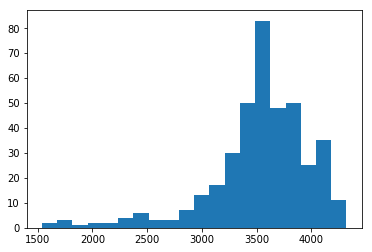

In [23]:
## Plot movement, for fun
movements = data_array[:,:,:,3]
good_movements = movements[~np.isnan(movements)]

fig, ax = plt.subplots()

ax.hist(good_movements,bins=20)

fig.show()

<IPython.core.display.Javascript object>


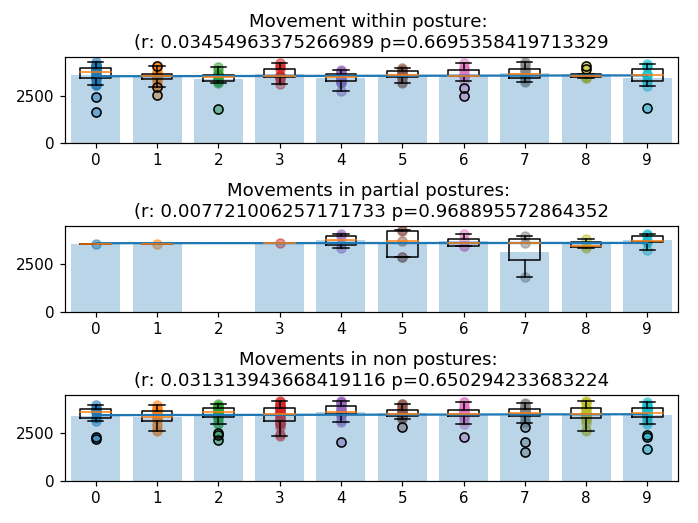

/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['BDY', 'ND', 'LNR', 'BOD', 'WG', '2M', 'GRG', 'LB', 'DBR', 'DMG']


In [24]:
## Show movements within postures, and movements in non postures
%matplotlib notebook
fig,(ax1,ax2,ax0) = plt.subplots(3)


n_songs = len(song_list)

true_order = np.argsort(song_means)[::-1]

song_order = range(n_songs)
song_order = true_order

posture_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 1)] for n in song_order]
partial_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 2)] for n in song_order]
non_movements = [data_array[:,:,n,3][np.logical_and(~np.isnan(data_array[:,:,n,3]),data_array[:,:,n,0] == 0)] for n in song_order]


mean_movt0 = np.zeros(10)
mean_movt1 = np.zeros(10)
mean_movt2 = np.zeros(10)

pos_xs,pos_ys = [],[]
par_xs,par_ys = [],[]
non_xs,non_ys = [],[]

for s in range(n_songs):
    ax0.scatter([s] * len(non_movements[s]),non_movements[s],alpha=.5,label=song_list[true_order[s]])
    ax2.scatter([s]*len(partial_movements[s]),partial_movements[s],alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(posture_movements[s]),posture_movements[s],alpha=.5,label=song_list[true_order[s]])
    
    pos_xs.extend([s]*len(posture_movements[s]))
    pos_ys.extend(posture_movements[s])
    
    par_xs.extend([s]*len(partial_movements[s]))
    par_ys.extend(partial_movements[s])
    
    non_xs.extend([s]*len(non_movements[s]))
    non_ys.extend(non_movements[s])
    
    mean_movt0[s] = np.mean(non_movements[s])
    mean_movt1[s] = np.mean(posture_movements[s])
    mean_movt2[s] = np.mean(partial_movements[s])


ax0.boxplot(non_movements,positions=range(n_songs))
ax2.boxplot(partial_movements,positions=range(n_songs))
ax1.boxplot(posture_movements,positions=range(n_songs))


slope1,intercept1 = np.polyfit(pos_xs,pos_ys,1)
fit_line1 = np.poly1d(np.polyfit(pos_xs,pos_ys,1))
ax1.plot(np.arange(n_songs),fit_line1(np.arange(n_songs)))
corr1,p_value1= pearsonr(pos_xs,pos_ys)
ax1.bar(np.arange(n_songs),mean_movt1,alpha=.3)

ax1.set_title('Movement within posture: \n(r: ' + str(corr1) +' p=' + str(p_value1))


slope2,intercept2 = np.polyfit(par_xs,par_ys,1)
fit_line2 = np.poly1d(np.polyfit(par_xs,par_ys,1))
ax2.plot(np.arange(n_songs),fit_line2(np.arange(n_songs)))
corr2,p_value2= pearsonr(par_xs,par_ys)
#ax2.set_ylim([0,15])
ax2.bar(np.arange(n_songs),mean_movt2,alpha=.3)
ax2.set_title('Movements in partial postures: \n(r: '+ str(corr2)+' p='+ str(p_value2))

slope0,intercept0 = np.polyfit(non_xs,non_ys,1)
fit_line0 = np.poly1d(np.polyfit(non_xs,non_ys,1))
ax0.plot(np.arange(n_songs),fit_line0(np.arange(n_songs)))
corr0,p_value0= pearsonr(non_xs,non_ys)

#ax0.set_ylim([0,15])
ax0.bar(np.arange(n_songs),mean_movt0,alpha=.3)
ax0.set_title('Movements in non postures: \n(r: '+ str(corr0)+' p='+ str(p_value0))

#print(fit_line2(0))
#fig.legend()

#fig.set_size_inches(6,6)
fig.tight_layout()
fig.show()

print([song_list[n] for n in song_order])


#fig.savefig('/home/ammon/Desktop/ToCompy/movement_bysong.svg')

<IPython.core.display.Javascript object>


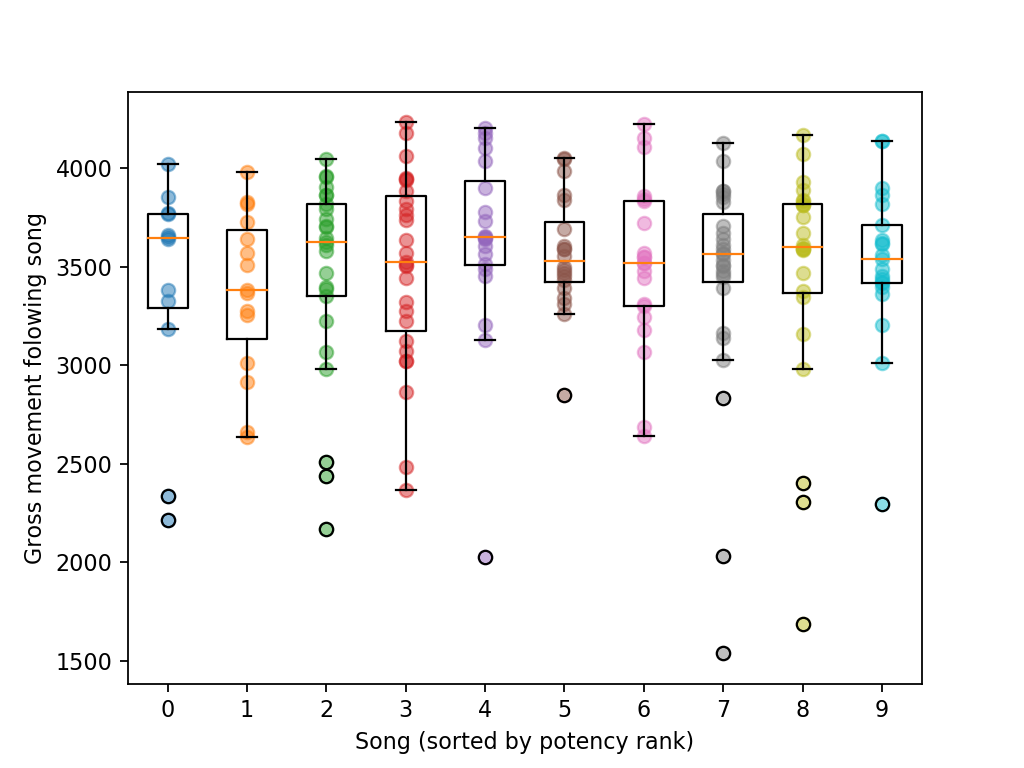

In [410]:
fig,ax = plt.subplots()

for s in range(n_songs):
    ax.scatter([s] * len(non_movements[s]),non_movements[s],alpha=.5,label=song_list[true_order[s]])
    
ax.boxplot(non_movements,positions=range(n_songs))
ax.set_xlabel('Song (sorted by potency rank)')
ax.set_ylabel('Gross movement folowing song')
fig.show()

In [ ]:
## Plot example postures for fig 1

In [413]:
depuffs = [.199,.4,.154,.093,.156,.106,.216,.206,.248,.143]
wingstrokes = [.436,.280,1.216,0.259,0.261,.215,.437,.347,.314,.919,.119]

print('depuff:',np.mean(depuffs),np.std(depuffs))
print('wingstroke:',np.mean(wingstrokes),np.std(wingstrokes))

print(ttest_ind(depuffs,wingstrokes))

depuff: 0.1921 0.08340197839380072
wingstroke: 0.43663636363636354 0.3162436554095226
Ttest_indResult(statistic=-2.255669009446699, pvalue=0.03607496646483934)


In [409]:
%matplotlib inline

my_seq = '2019-06-29'
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if my_seq in seq.seq_name and seq.machine == 'birdview':
        print(seq.seq_name,seq.ts[0])
        print(seq.machine)
        
for s in sorted(os.listdir('./CrapSeqs/')):
    seq = pickle.load(open('./CrapSeqs/' + s,'rb'))
    if my_seq in seq.seq_name and seq.machine == 'birdview':
        print(seq.seq_name,seq.ts[0])
        print(seq.machine)

"""
    if seq.posture == 1 and seq.offset != 0:
        seq.define_window()
        print(seq.seq_name)
        
        plt.plot(seq.ts,seq.smooth_data[:,3,2])
        plt.axvline(0)
        plt.axvline(seq.t_latency)
        plt.axvline(seq.t_vmax)
        plt.axvline(seq.t_peak)
        plt.axvline(seq.duration)
        plt.xlim([-1,seq.duration+2])
        plt.ylim([0.1,.4])
        plt.show()"""

print(seq.machine)
pass

2019-06-29-07-16-14_LB -3.747000217437744
birdview
2019-06-29-08-46-14_LNR -3.9729998111724854
birdview
2019-06-29-10-16-14_2M -4.0320000648498535
birdview
2019-06-29-11-46-14_WG -4.009000062942505
birdview
2019-06-29-13-16-13_BDY -3.7269997596740723
birdview
2019-06-29-17-16-15_GRG -4.017000198364258
birdview
2019-06-29-18-46-15_BOD -4.019999980926514
birdview
2019-06-29-08-46-14_LNR -3.9729998111724854
birdview
2019-06-29-10-16-14_2M -4.0320000648498535
birdview
2019-06-29-11-46-14_WG -4.009000062942505
birdview
birdview-2


In [ ]:
### Plot the distribution of peaks for fig1

tails = []
max_tails = []
bases = []

short_list = []
max_dict = {}
base_dict = {}

fig,(ax,ax2) = plt.subplots(2)
mean_times = {}

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.posture and seq.offset != 0:
        if seq.bird not in short_list:
            short_list.append(seq.bird)
            max_dict[seq.bird] = []
            base_dict[seq.bird] = []
        window = (seq.ts > -1) & (seq.ts < 4)
        if len(window) != len(seq.smooth_data):
            window = window[:-1]
        
        tail = seq.smooth_data[window,3,2]
        if seq.bird == 'CB-Yellow':
            ax.plot(seq.ts[window],(tail-.21) * 1000,alpha=.2,color='gray')
        
            for t in np.arange(len(window))[window]:
                if int(seq.ts[t] * 10) not in mean_times:
                    mean_times[int(seq.ts[t] * 10)] = []
                mean_times[int(seq.ts[t] * 10)].append(seq.smooth_data[t,3,2])
        
        base = tail[0]
        
        tails.append(tail)
        max_tails.append(np.max(tail))
        bases.append(base)
        max_dict[seq.bird].append(np.max(tail))
        base_dict[seq.bird].append(base)


normed_tails = []

mean_tails = np.empty(len(mean_times))
key_times = sorted(mean_times.keys())
for t in range(len(key_times)):
    mean_tails[t] = np.median(mean_times[key_times[t]])
    
ax.plot(np.array(key_times) / 10,(mean_tails - .21) * 1000,color='black')


        

#ax.plot(np.mean(np.array(tails),1))
all_tails = []
for b in short_list:
    mean_base = np.mean(base_dict[b])
    max_tail = np.max(max_dict[b])
    med_peak = np.median(max_dict[b])
    normed_tails = (np.array(max_dict[b]) - mean_base) / (med_peak - mean_base)
    #normed_bases = np.array(base_dict[b]) - np.max(base_dict[b])

    #ax.hist(normed_tails,bins=50,alpha=.7)
    all_tails.extend(normed_tails)
    #ax.hist(normed_bases,bins=50,alpha=.5)
    #ax.axvline()

    
ax.set_xlim([-.5,2])
ax.set_ylim([-100,200])
ax.axvline(0,linestyle=':',color='black')
ax.set_xlabel('Time (seconds after song onset)')
ax.set_ylabel('Tail height (mm relative to baseline)')

ax2.hist(all_tails,bins = 100,orientation='horizontal',color='black')
ax2.set_ylim([-0.5,2])

fig.set_size_inches(4,8)
fig.show()

fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/Fig2_.svg')
fig.savefig('/home/ammon/Desktop/PaperFigs/Fig2_.png',dpi=300)

In [357]:
print(sorted(mean_times.keys()))
print(len(mean_times.keys()))
print(mean_times[0])

[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
49
[array([[ 0.07913016,  0.20429263,  0.02763419],
       [ 0.09851271,  0.15785963,  0.08897222],
       [ 0.0799202 ,  0.2126303 ,  0.0388942 ],
       [ 0.06932618,  0.18598548,  0.08174748],
       [ 0.06374868,  0.27778998,  0.0391222 ],
       [ 0.05089402,  0.20099275,  0.03408171],
       [ 0.0883652 ,  0.21373588,  0.02399244],
       [ 0.07003286,  0.20740857,  0.03637444],
       [ 0.06015846,  0.2185073 ,  0.0432361 ],
       [ 0.10895826,  0.17943948,  0.07997926],
       [ 0.08751461,  0.20044227,  0.03639639],
       [ 0.05327955,  0.20339186,  0.06325801],
       [ 0.063463  ,  0.2880942 , -0.00525447],
       [ 0.07479427,  0.19630264,  0.02792045],
       [ 0.06431926,  0.19816329,  0.01935488],
       [ 0.05848978,  0.21711899,  0.02382989],
       [ 0.098434  ,  0.21976569,  0.0302

In [25]:
## Do some stats on the above plots:

print('No difference in non postures:')
print(f_oneway(non_movements[0],non_movements[1],non_movements[2],non_movements[3],
              non_movements[4],non_movements[5],non_movements[6],non_movements[7],
               non_movements[8],non_movements[9]))

print('No difference in partial postures:')
print(f_oneway(partial_movements[0],partial_movements[1],
               partial_movements[3],partial_movements[4],partial_movements[5],
               partial_movements[6],partial_movements[7],partial_movements[8],
               partial_movements[9]))

No difference in non postures:
F_onewayResult(statistic=0.4528704758580337, pvalue=0.9043838171549998)
No difference in partial postures:
F_onewayResult(statistic=0.3673242868216856, pvalue=0.9251207295060991)


Mean Latency= 0.9460496015785155 (std: 0.3698860222971921 )
Median Latency= 0.9229998588562012


<IPython.core.display.Javascript object>


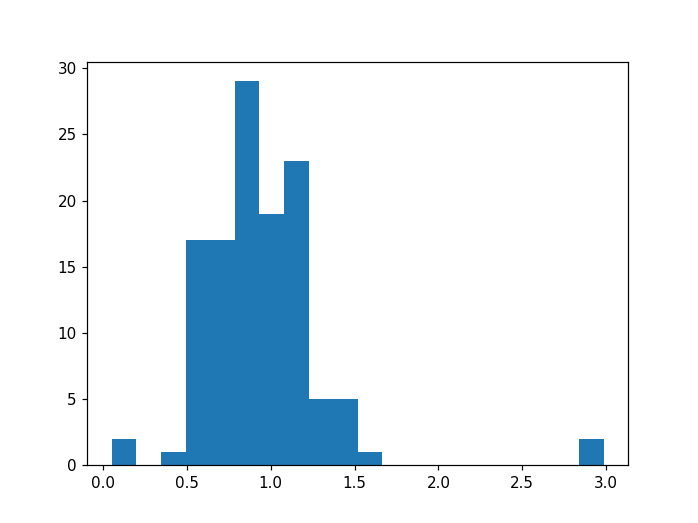

In [26]:
## First get latency for all songs: 
latencies = data_array[:,:,:,1]

latencies[data_key[:,:,:,2] == 0] = np.nan

good_latencies = latencies[~np.isnan(latencies)]

mean_lat = np.mean(good_latencies)
med_lat = np.median(good_latencies)
std_lat = np.std(good_latencies)

print('Mean Latency=',mean_lat,'(std:',std_lat,')')
print('Median Latency=',med_lat)

#print(good_latencies)
fig,ax = plt.subplots()

ax.hist(good_latencies,bins=20)

#fig.savefig('/home/ammon/Desktop/ToCompy/latencies_all.svg')
fig.show()


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


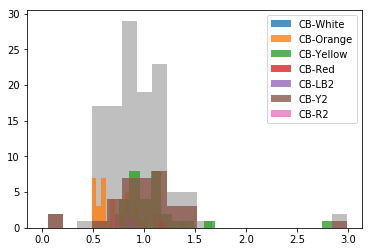

In [21]:
## Now get latencies by bird: 
n_birds = len(bird_list)

latencies = data_array[:,:,:,1]
latencies[data_key[:,:,:,2] == 0] = np.nan
good_latencies = latencies[~np.isnan(latencies)]

bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds

## Get durations and latencies by bird
for i in range(n_birds):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]

fig,ax = plt.subplots()

ax.hist(good_latencies,bins=20,color='gray',alpha=.5)
for b in range(n_birds):
    ax.hist(bird_latencies[b],bins=20,alpha=.8,label=bird_list[b])

ax.legend()

fig.savefig('/home/ammon/Desktop/ToCompy/latencies_bybird.svg')
fig.show()

(7, 14, 10)
(121,)


<IPython.core.display.Javascript object>


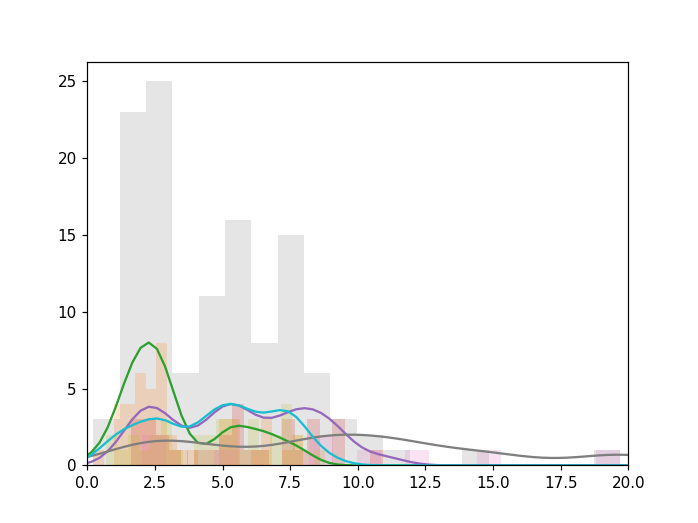

In [27]:
## Now get durations by bird: 
n_birds = len(bird_list)

durations = np.array(data_array[:,:,:,2])

durations[data_key[:,:,:,2] == 0] = np.nan
print(np.shape(durations))
good_durations = durations[~np.isnan(durations)]
print(np.shape(good_durations))


bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds
bird_kdes = [0] * n_birds






## Get durations and latencies by bird
for i in range(n_birds):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]

    
fig,ax = plt.subplots()
    
xs = np.linspace(-5,25,100)    
ax.hist(good_durations,bins=20,color='gray',alpha=.2)
for b in range(n_birds):
    y,x,_ = ax.hist(bird_durations[b],bins=20,alpha=.2)
    if len(bird_latencies[b]) > 1:
        curve = gaussian_kde(bird_durations[b],bw_method=.3)
        ax.plot(xs,curve(xs) * max(y) / max(curve(xs)))

ax.set_xlim([0,20])
fig.show()

#fig.savefig('/home/ammon/Desktop/ToCompy/durations_bybird_hist.svg')

['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


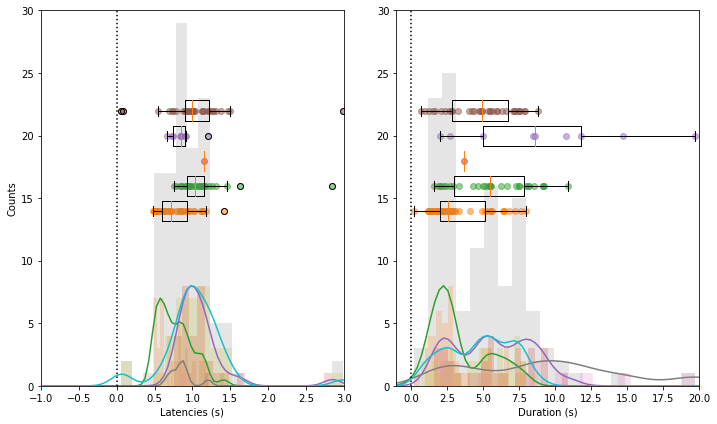

In [39]:
## Get durations,latencies by bird: 

print(bird_list)
n_birds = len(bird_list)

durations = np.array(data_array[:,:,:,2])
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = np.array(data_array[:,:,:,1])
latencies[data_key[:,:,:,2] == 0] = np.nan
good_latencies = latencies[~np.isnan(latencies)]

bird_durations = [np.nan] * n_birds
bird_latencies = [np.nan] * n_birds

## Get durations and latencies by bird
for i in range(n_birds):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[n,:,:,2]),data_array[n,:,:,0] == 1)
    crap_indices = data_key[n,:,:,2] == 0
    bird_durations[i] = data_array[n,:,:,2][np.logical_and(p_indices,~crap_indices)]
    bird_latencies[i] = data_array[n,:,:,1][np.logical_and(p_indices,~crap_indices)]



fig,(ax1,ax2) = plt.subplots(1,2)

dur_heights = np.arange(12,12+n_birds * 2,2)
lat_heights = np.arange(12,12+n_birds * 2,2)
dur_widths = [1.6] * n_birds

for s in range(n_birds):
    ax2.scatter(bird_durations[s],[dur_heights[s]] * len(bird_durations[s]),alpha=.5,label=bird_list[s])
    ax1.scatter(bird_latencies[s],[lat_heights[s]] * len(bird_durations[s]),alpha=.5)

ax2.boxplot(bird_durations,positions=dur_heights,vert=False,widths=dur_widths)
ax1.boxplot(bird_latencies,positions=lat_heights,vert=False,widths=dur_widths)

dur_xs = np.linspace(-5,25,100)    
lat_xs = np.linspace(-2,3,100)

ax1.hist(good_latencies,bins=20,color='gray',alpha=.2)
ax2.hist(good_durations,bins=20,color='gray',alpha=.2)
for b in range(n_birds):
    y,x,_ = ax2.hist(bird_durations[b],bins=20,alpha=.2)
    lat_y,lat_x,_ = ax1.hist(bird_latencies[b],bins=20,alpha=.2)
    if len(bird_latencies[b]) > 1:
        dur_curve = gaussian_kde(bird_durations[b],bw_method=.3)
        ax2.plot(dur_xs,dur_curve(dur_xs) * max(y) / max(dur_curve(dur_xs)))
        lat_curve = gaussian_kde(bird_latencies[b],bw_method=.3)
        ax1.plot(lat_xs,lat_curve(lat_xs) * max(lat_y) / max(lat_curve(lat_xs)))

ax1.set_xlim([-1,3])       
ax1.set_ylim([0,30])  
ax2.set_xlim([-1,20])
ax2.set_ylim(0,30)

ax1.set_yticks(np.arange(0,35,5))
ax1.set_yticklabels(np.arange(0,35,5))

ax2.set_yticks(np.arange(0,35,5))
ax2.set_yticklabels(np.arange(0,35,5))

ax1.set_ylabel('Counts')
ax2.set_ylabel('   ')
ax2.set_xlabel('Duration (s)')
ax1.set_xlabel('Latencies (s)')

ax1.axvline(0,linestyle=':',color='black')
ax2.axvline(0,linestyle=':',color='black')
#fig.legend()

fig.set_size_inches(10,6)
fig.tight_layout()
fig.show()

fig.savefig('/home/ammon/Desktop/PaperFigs/5ab.png')
fig.savefig('/home/ammon/Desktop/PaperFigs/5ab.svg')

(7, 14, 10)


<IPython.core.display.Javascript object>


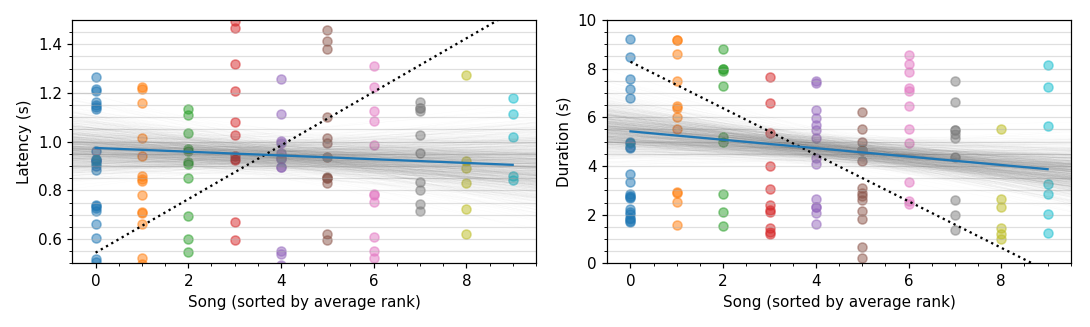

Latency r: -0.058399715978366226 p= 0.5245990442718211
Duration r: -0.15882439068213977 p= 0.08185970200052575
-0.17258887313522528 5.423283334248089
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([23, 14, 11, 11, 14, 14, 11, 10,  6,  7]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([23, 14, 11, 11, 14, 14, 11, 10,  6,  7]))
[3.33400011 6.40999997 7.2670002  2.4000001  4.722      2.99449992
 6.44999981 5.23650014 1.8865     3.25999999]
mean duration:
SpearmanrResult(correlation=-0.5393939393939393, pvalue=0.1075931877824148)
median duration:
SpearmanrResult(correlation=-0.33333333333333326, pvalue=0.34659350708733405)
mean latency
SpearmanrResult(correlation=-0.29696969696969694, pvalue=0.4047016712701569)
95% CI for lat slope is [-0.03340045  0.01534408]
95% CI for dur slope is [-0.37434792  0.01360723]


In [29]:
## Get durations, latencies by song Fig5cd

n_songs = len(song_list)


true_order = np.argsort(song_means)[::-1]
song_order = range(n_songs)
song_order = true_order

durations = data_array[:,:,:,2]
durations[data_array[:,:,:,0] != 1] = np.nan
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

print(np.shape(durations))

latencies = np.array(data_array[:,:,:,1][data_array[:,:,:,0] == 1])

#latencies[latencies > 1.6] == np.nan
good_latencies = latencies[~np.isnan(latencies)]


song_durations = [np.nan] * len(song_order)
song_latencies = [np.nan] * len(song_order)

## Get durations and latencies by song
for i in range(len(song_order)):
    n = song_order[i]
    p_indices = np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)
    crap_indices = data_key[:,:,n,2] == 0
    song_durations[i] = data_array[:,:,n,2][np.logical_and(p_indices,~crap_indices)]
    song_latencies[i] = data_array[:,:,n,1][np.logical_and(p_indices,~crap_indices)]


# Sometimes list comprehensioin is a little too much...
#song_durations = [data_array[:,:,n,2][np.logical_and(data_key[:,:,n,2] == 1,(np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)))] for n in song_order]
#song_latencies = [data_array[:,:,n,1][np.logical_and(data_key[:,:,n,2] == 1,(np.logical_and(~np.isnan(data_array[:,:,n,2]),data_array[:,:,n,0] == 1)))] for n in song_order]


dur_xs,dur_ys = [],[]
lat_xs,lat_ys = [],[]
fig,(ax1,ax2) = plt.subplots(1,2)

mean_durations = np.empty(10)
mean_latencies = np.empty(10)
median_durations = np.empty(10)
median_latencies = np.empty(10)

for s in range(n_songs):
    ax2.scatter([s]*len(song_durations[s]),song_durations[s],alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(song_latencies[s]),song_latencies[s],alpha=.5)
    
    lat_xs.extend([s]*len(song_latencies[s]))
    lat_ys.extend(song_latencies[s])
    dur_xs.extend([s]*len(song_durations[s]))
    dur_ys.extend(song_durations[s])
    
    mean_durations[s] = np.nanmean(song_durations[s])
    mean_latencies[s] = np.nanmean(song_latencies[s])
    median_durations[s] = np.nanmedian(song_durations[s])
    median_latencies[s] = np.nanmedian(song_latencies[s])
#ax2.boxplot(song_durations,positions=range(n_songs))
#ax1.boxplot(song_latencies,positions=range(n_songs))

#ax1.set_title('Latencies by song:')
ax1.set_ylabel('Latency (s)')
ax2.set_ylabel('Duration (s)')
ax1.set_xlabel('Song (sorted by average rank)')
ax2.set_xlabel('Song (sorted by average rank)')

slope1,intercept1 = np.polyfit(lat_xs,lat_ys,1)
fit_line1 = np.poly1d(np.polyfit(lat_xs,lat_ys,1))

#ax1.plot([0,9],[min(mean_latencies),max(mean_latencies)],linestyle=':',color='blue')
corr1,p_value1= pearsonr(lat_xs,lat_ys)
print('Latency r:',corr1,'p=',p_value1)

#ax2.set_title('Durations by song:')
slope2,intercept2 = np.polyfit(dur_xs,dur_ys,1)
slope3,intercept3 = np.polyfit(dur_xs,sorted(dur_ys)[::-1],1)
fit_line3 = np.poly1d(np.polyfit(dur_xs,sorted(dur_ys)[::-1],1))
fit_line2 = np.poly1d(np.polyfit(dur_xs,dur_ys,1))
fit_line4 = np.poly1d(np.polyfit(lat_xs,sorted(lat_ys),1))



#ax2.plot([0,9],[max(mean_durations),min(mean_durations)],linestyle=':',color='blue')

#ax2.set_ylim([0,15])
#ax2.bar(np.arange(n_songs),mean_durations,alpha=.5)


corr2,p_value2= pearsonr(dur_xs,dur_ys)

print("Duration r:",corr2,"p=",p_value2)
print(slope2,intercept2)

#print(fit_line2(0))
#fig.legend()

fig.set_size_inches(10,3)
fig.tight_layout()
fig.show()

## careful, there are more in some than others...
print(np.unique(lat_xs,return_counts=True))
print(np.unique(dur_xs,return_counts=True))

print(median_durations)
print('mean duration:')
print(spearmanr(mean_durations,range(10)))
print('median duration:')
print(spearmanr(median_durations,range(10)))
print('mean latency')
print(spearmanr(mean_latencies,range(10)))

### DO some bootstrapping
lat_slope_reps, lat_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)
dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(dur_xs), y=np.array(dur_ys), size=5000)


x = np.array([-1,10])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, lat_slope_reps[i]*x + lat_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')
    _ = ax2.plot(x, dur_slope_reps[i]*x + dur_intercept_reps[i],
                 linewidth=0.2, alpha=0.05, color='gray')
    
ax1.plot(np.arange(n_songs),fit_line4(np.arange(n_songs)),color='black',linestyle=':')
ax2.plot(np.arange(n_songs),fit_line3(np.arange(n_songs)),color='black',linestyle=':')

ax1.plot(np.arange(n_songs),fit_line1(np.arange(n_songs)))
ax2.plot(np.arange(n_songs),fit_line2(np.arange(n_songs)))

ax2.minorticks_on()
ax1.minorticks_on()

ax2.yaxis.grid(which='major',alpha=.4)
ax2.yaxis.grid(which='minor',alpha=.4)

ax1.yaxis.grid(which='major',alpha=.4)
ax1.yaxis.grid(which='minor',alpha=.4)

ax1.set_ylim([0.5,1.5])
ax2.set_ylim([0,10])
ax1.set_xlim([-.5,9.5])
ax2.set_xlim([-.5,9.5])
print("95% CI for lat slope is {}".format(np.percentile(lat_slope_reps, [2.5, 97.5])))
print("95% CI for dur slope is {}".format(np.percentile(dur_slope_reps, [2.5, 97.5])))

fig.savefig('/home/ammon/Desktop/PaperFigs/5cd.svg')
fig.savefig('/home/ammon/Desktop/PaperFigs/5cd.png')

In [30]:
##Test for whether birds are different. 

print(np.shape(bird_durations))
print(np.shape(bird_latencies))
print('Significant variation in latency (std is similar)')
print(f_oneway(bird_latencies[1],bird_latencies[2],bird_latencies[3],
               bird_latencies[4],bird_latencies[5]))
print(levene(bird_latencies[1],bird_latencies[2],bird_latencies[3],
               bird_latencies[4],bird_latencies[5]))

print('Significant variation in duration ')
print(f_oneway(bird_durations[1],bird_durations[2],bird_durations[3],
               bird_latencies[4],bird_latencies[5]))
print(levene(bird_durations[1],bird_durations[2],bird_durations[3],
               bird_durations[4],bird_durations[5]))


lats = []
durs = []
bird_ids = []
for b in range(1,6):

    lats.extend(bird_latencies[b])
    durs.extend(bird_durations[b])
    bird_ids.extend([b] * len(bird_latencies[b]))

print(pairwise_tukeyhsd(lats,bird_ids))
print(pairwise_tukeyhsd(durs,bird_ids))

(7,)
(7,)
Significant variation in latency (std is similar)
F_onewayResult(statistic=5.459412701834754, pvalue=0.0004606349762899995)
LeveneResult(statistic=1.0395621580158503, pvalue=0.38995421889168796)
Significant variation in duration 
F_onewayResult(statistic=28.87750160382836, pvalue=1.1742178655361328e-16)
LeveneResult(statistic=5.895833614328563, pvalue=0.0002352968680403528)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.338    0.1116 0.5643  True 
  1      3     0.3767  -0.5943 1.3477 False 
  1      4     0.0834  -0.2673 0.434  False 
  1      5     0.271    0.0563 0.4858  True 
  2      3     0.0387  -0.9375 1.015  False 
  2      4    -0.2546  -0.6196 0.1104 False 
  2      5    -0.0669  -0.3043 0.1705 False 
  3      4    -0.2933  -1.3057 0.719  False 
  3      5    -0.1057  -1.0793 0.868  False 
  4      5     0.1877  -0.1703 0.5456 False 
----------------------

In [31]:
## Test for whether top 2 songs are different. (They aren't)

top_latencies = np.hstack([song_latencies[0],song_latencies[1]])
bottom_latencies = np.hstack([song_latencies[i] for i in [2,3,4,5,6,7,8,9]])

top_durations = np.hstack([song_durations[0],song_durations[1]])
bottom_durations = np.hstack([song_durations[i] for i in [2,3,4,5,6,7,8,9]])


print(ttest_ind(top_latencies,bottom_latencies))
print(ttest_ind(top_durations,bottom_durations))

Ttest_indResult(statistic=-0.13429142315735423, pvalue=0.8933989966365374)
Ttest_indResult(statistic=1.5363714830851523, pvalue=0.12710193924549715)


['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']
(7, 14, 10, 4)
['BDY', 'BOD', 'ND', 'LB', '2M', 'DBR', 'GRG', 'WG', 'LNR', 'DMG']


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


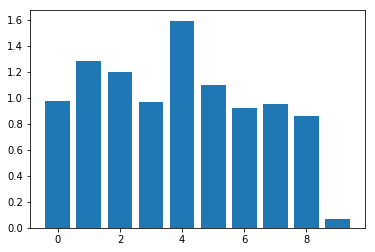

In [34]:
## Means of CB-Orange by song

print(bird_list)
print(np.shape(data_array))

orange_means = np.nanmean(data_array[5,:,:,1],0)

fig, ax = plt.subplots()
ax.bar(range(10),orange_means)
fig.show()
print(song_list)
#print(true_order)


7


<IPython.core.display.Javascript object>


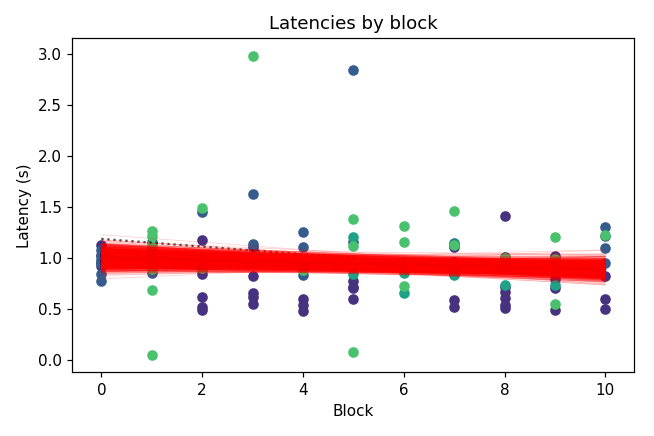

<IPython.core.display.Javascript object>


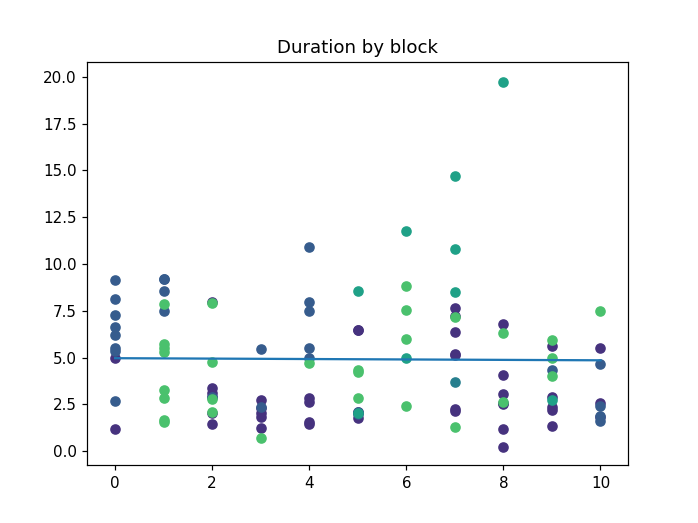

SpearmanrResult(correlation=-0.28181818181818186, pvalue=0.4011448979604785)
SpearmanrResult(correlation=-0.24545454545454545, pvalue=0.4669223669820163)


In [32]:
## Get durations,latencies by block: 

n_birds = np.shape(data_array)[0]
print(n_birds)
n_blocks = 11

durations = data_array[:,:,:,2]
durations[data_array[:,:,:,0] != 1] = np.nan
durations[data_key[:,:,:,2] == 0] = np.nan
good_durations = durations[~np.isnan(durations)]

latencies = data_array[:,:,:,1]
good_latencies = latencies[~np.isnan(latencies)]

#song_durations = [data_array[:,n,:,2][~np.isnan(data_array[:,n,:,2])] for n in range(n_blocks)]
#song_latencies = [data_array[:,n,:,1][~np.isnan(data_array[:,n,:,1])] for n in range(n_blocks)]

block_durations = [np.nan] * n_blocks
block_latencies = [np.nan] * n_blocks

## Get durations and latencies by song
for i in range(n_blocks):
    n = i
    p_indices = np.logical_and(~np.isnan(data_array[:,n,:,2]),data_array[:,n,:,0] == 1)
    crap_indices = data_key[:,n,:,2] == 0
    block_durations[i] = data_array[:,n,:,2][np.logical_and(p_indices,~crap_indices)]
    block_latencies[i] = data_array[:,n,:,1][np.logical_and(p_indices,~crap_indices)]

fig,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
#fig,(ax1,ax2) = plt.subplots(1,2)

dur_xs,dur_ys = [],[]
lat_xs,lat_ys = [],[]

for s in range(n_blocks):
    #ax2.scatter([s]*len(block_durations[s]),block_durations[s],alpha=.5)
    #ax1.scatter([s]*len(block_latencies[s]),block_latencies[s],alpha=.5)
    dur_xs.extend([s]*len(block_durations[s]))
    dur_ys.extend(block_durations[s])
    lat_xs.extend([s]*len(block_latencies[s]))
    lat_ys.extend(block_latencies[s])

for f in range(n_birds):
    xs,Lys,Dys = [],[],[]
    for s in range(n_blocks):
        p_indices = np.logical_and(~np.isnan(data_array[f,s,:,2]),data_array[f,s,:,0] == 1)
        crap_indices = data_key[f,s,:,2] == 0
        bird_latencies = data_array[f,s,:,1][np.logical_and(p_indices,~crap_indices)]
        bird_durations = data_array[f,s,:,2][np.logical_and(p_indices,~crap_indices)]
        xs.extend([s] * len(bird_latencies))
        Lys.extend(bird_latencies)
        Dys.extend(bird_durations)
    ax1.scatter(xs,Lys,color=color_map(f/n_birds))
    ax2.scatter(xs,Dys,color=color_map(f/n_birds))
    
#ax2.boxplot(block_durations,positions=range(n_blocks))
#ax1.boxplot(block_latencies,positions=range(n_blocks))

ax1.set_title('Latencies by block')
ax2.set_title('Duration by block')

block_means_dur = [np.nanmean(block_durations[i]) for i in range(len(block_durations))]
block_means_lat = [np.nanmean(block_latencies[i]) for i in range(len(block_latencies))]
print(spearmanr(block_means_lat,range(len(block_means_lat))))
print(spearmanr(block_means_dur,range(len(block_means_dur))))
    
slope,intercept = np.polyfit(range(len(block_means_lat)),block_means_lat,1)
fit_line = np.poly1d([slope,intercept])
ax1.plot(fit_line(np.arange(n_blocks)))
ax1.set_ylabel('Latency (s)')
ax1.set_xlabel('Block')
ax1.plot([0,10],[sorted(block_means_lat)[-1],sorted(block_means_lat)[0]],color='black',linestyle=':',alpha=.7)


slope2,intercept2 = np.polyfit(range(len(block_means_dur)),block_means_dur,1)
fit_line2 = np.poly1d([slope,intercept2])
ax2.plot(fit_line2(np.arange(n_blocks)))

### DO some bootstrapping
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)

x = np.array([0,10])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')



fig.set_size_inches(6,4)
fig.tight_layout()
fig.show()



#fig.savefig('/home/ammon/Desktop/ToCompy/durations_byblock.svg')

In [33]:
## Boot strap confidence intervals for the above plots
# Cribbed from Serhan Aya (serhanaya.github.io)

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(shape=size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds)) # sampling the indices (1d array requirement)
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x=np.array(lat_xs), y=np.array(lat_ys), size=5000)

x = np.array([20, 240])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax1.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
#_ = ax1.plot(prm1, rad2, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = ax1.set_xlabel('perimeter_1', fontsize=16)
_ = ax1.set_ylabel('radius_2', fontsize=16)
#plt.margins(0.02)
fig.show()

(7, 14, 10, 4)
(7, 14, 10, 4)
(7, 14, 10, 4)
7


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RankWarning: Polyfit may be poorly conditioned
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


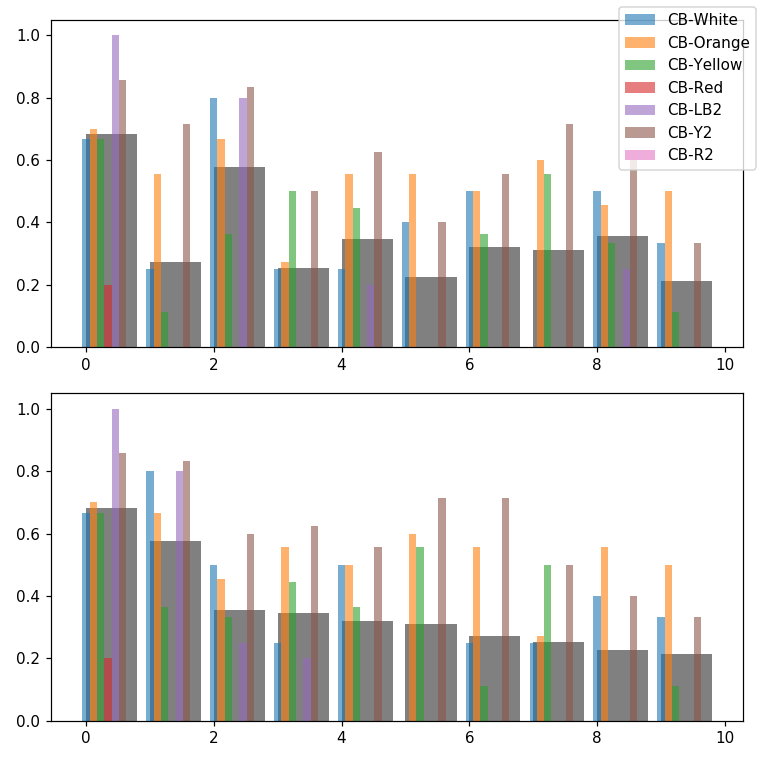

In [34]:
### Plot the responses of posture by bird
n_birds = 7
print(np.shape(data_array))

binary_array = np.array(data_array)
binary_array[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]

binary_partial = np.array(data_array)
binary_partial[data_array[:,:,:,0] == 1] = [0,np.nan,np.nan,np.nan]
binary_partial[data_array[:,:,:,0] == 2] = [1,np.nan,np.nan,np.nan]

binary_null = np.array(data_array)
binary_null[data_array[:,:,:,0] == 2] = [0,np.nan,np.nan,np.nan]
binary_null[data_array[:,:,:,0] == 1] = [0,np.nan,np.nan,np.nan]
binary_null[data_array[:,:,:,0] == 0] = [1,np.nan,np.nan,np.nan]

print(np.shape(data_array))
print(np.shape(binary_array))

songs_bybird = np.nanmean(binary_array,axis=(1))
partials_bybird = np.nanmean(binary_partial,axis=1)
non_bybird = np.nanmean(binary_null,axis=1)

canon_slopes = np.empty(n_birds)
true_slopes = np.empty_like(canon_slopes)

canon_intercepts,true_intercepts = np.empty_like(canon_slopes),np.empty_like(true_slopes)

canon_means = np.empty([n_birds,n_songs])
true_means = np.empty_like(canon_means)
partial_means = np.empty_like(canon_means)
non_means = np.empty_like(canon_means)

non_means.fill(np.nan)
partial_means.fill(np.nan)
canon_means.fill(np.nan)

print(n_birds)
for b in range(n_birds):
    ## This is the ranking (sorted by canon)
    canon_means[b] = songs_bybird[b,:,0]
    partial_means[b] = partials_bybird[b,:,0]
    non_means[b] = non_bybird[b,:,0]
    
    canon_slopes[b],canon_intercepts[b] = np.polyfit(range(n_songs),canon_means[b],1) 

    ## This is the individual bird ranking
    true_means[b] = np.sort(canon_means[b])[::-1]
    true_slopes[b],true_intercepts[b] = np.polyfit(range(n_songs),true_means[b],1)

fig,(ax,ax2) = plt.subplots(2)


song_means = np.nanmean(canon_means,axis=0)
partial_means = np.nanmean(partial_means,axis=0)
non_means = np.nanmean(non_means,axis=0)
song_std = np.nanstd(canon_means,axis=0)

true_order = np.argsort(song_means)[::-1]
sorted_means = canon_means[:,true_order]


ax.bar(np.arange(n_songs) + .4,song_means,color='gray',alpha=1)
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means,axis=0),color='gray')
for n in range(n_birds):
    ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list[n],alpha=.6)
    ax2.bar(np.arange(n_songs) + n * .8/n_birds,sorted_means[n],width=.8/n_birds,alpha=.6)
    
fig.legend()
fig.set_size_inches(7,7)
fig.tight_layout()

fig.show()

#fig.savefig('/home/ammon/Desktop/ToCompy/selectivity_bybird.svg')

<IPython.core.display.Javascript object>


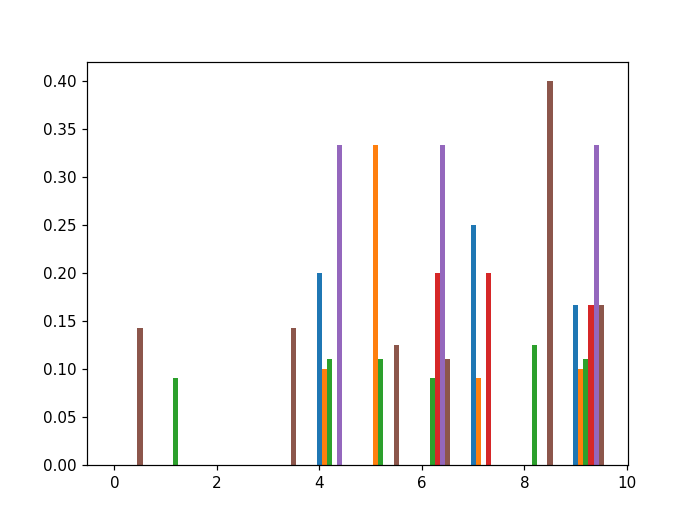

(0.46216816065298133, 0.17868637780443722)
self sorted:
(-0.5829964379478784, 0.07691019007241025)
(0.2758524455297725, 0.4404318493432298)
self sorted:
(-0.04948498068663858, 0.8920162902109748)
(0.49533429579166094, 0.14545925315368102)
self sorted:
(-0.18662971378616466, 0.6056724966108702)
(0.6203723351351519, 0.055665314502620085)
self sorted:
(0.07337737297297496, 0.8403484485859508)
(0.41785544701867244, 0.22951410747271447)
self sorted:
(-0.11396057645963795, 0.753923605977703)
(0.45094535222930093, 0.19086211736476674)
self sorted:
(-0.41391034090033996, 0.23439599979859277)
(nan, 1.0)
self sorted:
(nan, 1.0)
[0.14285714 0.         0.         0.14285714 0.         0.125
 0.11111111 0.         0.4        0.16666667]
[0.02380952 0.01515152 0.         0.02380952 0.12407407 0.09490741
 0.12255892 0.09015152 0.0875     0.17407407]
(0.8228749301672376, 0.0034567892353481746)


In [35]:
np.shape(partials_bybird)
fig, ax = plt.subplots()
for b in range(n_birds):
    ax.bar(np.arange(10) + b*.1,partials_bybird[b,song_order,0],width=.1)
    print(pearsonr(range(10),partials_bybird[b,song_order,0]))
    print('self sorted:')
    print(pearsonr(range(10),partials_bybird[b,np.argsort(songs_bybird[b,:,0]),0]))
    
print(partials_bybird[b-1,song_order,0])
print(np.nanmean(partials_bybird[:,song_order,0],0))
print(pearsonr(range(10),np.nanmean(partials_bybird[:,song_order,0],0)))

<IPython.core.display.Javascript object>


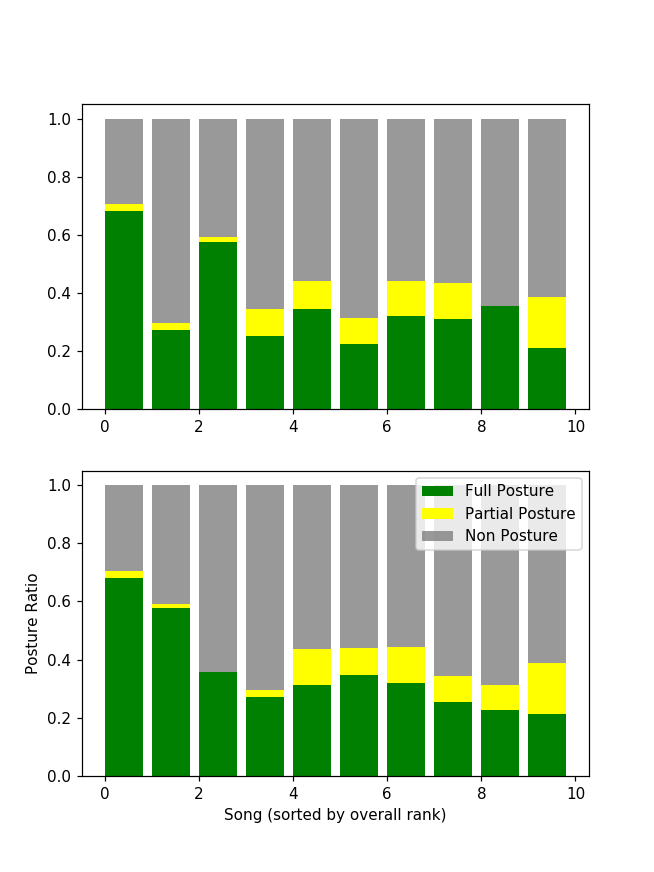

[0 2 8 1 7 4 6 3 5 9]


In [36]:
## Plot postures, nonpostures, and partial postures

fig,(ax1,ax2) = plt.subplots(2)

ax1.bar(np.arange(n_songs) + .4,song_means,color='green',alpha=1)
ax1.bar(np.arange(n_songs) + .4,partial_means,color='yellow',bottom=song_means)
ax1.bar(np.arange(n_songs) + .4,non_means,color='gray',alpha=.8,bottom=(song_means + partial_means))

print(song_order)

ax2.bar(np.arange(n_songs) + .4,song_means[song_order],color='green',alpha=1,label='Full Posture')
ax2.bar(np.arange(n_songs) + .4,partial_means[song_order],color='yellow',bottom=song_means[song_order],label='Partial Posture')
ax2.bar(np.arange(n_songs) + .4,non_means[song_order],color='gray',alpha=.8,bottom=(song_means + partial_means)[song_order],label='Non Posture')
ax2.set_xlabel('Song (sorted by overall rank)')
ax2.set_ylabel('Posture Ratio')

ax2.legend()
fig.set_size_inches(6,8)
fig.show()

(0.8228749301672376, 0.0034567892353481746)


<IPython.core.display.Javascript object>


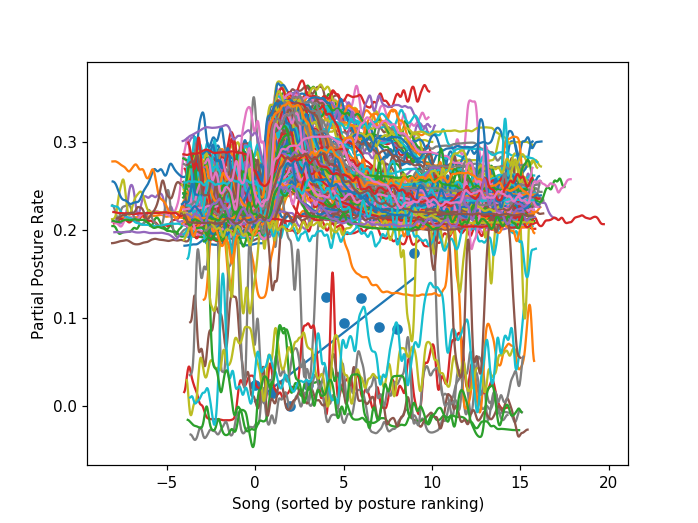

In [37]:
## Plot partial posture by ranking
print(pearsonr(range(10),partial_means[song_order]))
fig,ax = plt.subplots()


slope,intercept = np.polyfit(range(10),partial_means[song_order],1)
fit_line = np.poly1d([slope,intercept])
ax.plot(np.arange(10),fit_line(np.arange(10)))

ax.set_ylabel('Partial Posture Rate')
ax.set_xlabel('Song (sorted by posture ranking)')
ax.scatter(range(10),partial_means[song_order])

fig.show()

In [38]:
## Plot all partial postures, see if they look different somehow. They don't, although this is noisy. 

p_maxes,p_mins = [],[]
a_maxes,a_mins = [],[]

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.posture and seq.offset != 0:
        i_max = np.argmax(seq.acc[seq.response_range[:-2],3,2])
        i_min = np.argmin(seq.acc[seq.response_range[:-2],3,2])
        t_max = seq.acc_t[seq.response_range[:-2]][i_max]
        t_min = seq.acc_t[seq.response_range[:-2]][i_min]

        a_max = seq.acc[seq.response_range[:-2],3,2][i_max]
        a_min = seq.acc[seq.response_range[:-2],3,2][i_min]
        if seq.posture == 1:
            if t_min > t_max:
                p_maxes.append(a_max)
                p_mins.append(a_min)
            if True:
                print(seq.seq_name)
                plt.plot(seq.ts,seq.smooth_data[:,3,2])
                plt.show()
        if seq.posture == 2:
            if True:
                print(seq.seq_name)
                print(np.argmin(seq.acc[:,3,2]))

            if t_min > t_max:
                a_maxes.append(a_max)
                a_mins.append(a_min)
            if False:
                plt.plot(seq.ts,seq.smooth_data[:,3,2],alpha=.5)
                #plt.plot(seq.acc_t[seq.response_range[:-2]],seq.acc[seq.response_range[:-2],3,2] * 30)
                plt.axvline(t_min)
                plt.axvline(t_max,color='red')
                plt.show()
                ax.plot(seq.ts,seq.smooth_data[:,3,2],alpha=.5)

print("Posture max vs partial max:")
print(np.mean(p_maxes),np.mean(a_maxes))
print(ttest_ind(p_maxes,a_maxes))

print("Posture min vs partial min:")
print(np.mean(p_mins),np.mean(a_mins))
print(ttest_ind(p_mins,a_mins))



2019-05-22-17-02-54_LB
457
2019-05-24-07-02-40_GRG
97
2019-05-25-11-37-43_DMG
764
2019-05-29-17-07-51_BDY
2019-05-30-07-07-56_GRG
2019-05-30-08-34-17_BOD
2019-05-30-10-02-55_BDY
2019-05-30-11-32-53_LNR
2019-05-30-13-04-19_ND
2019-05-30-15-33-06_2M
2019-05-30-17-09-37_LB
2019-05-30-18-36-04_DMG
2019-05-31-07-05-58_GRG
2019-05-31-08-35-31_DBR
402
2019-05-31-10-06-46_WG
2019-05-31-11-33-45_GRG
2019-05-31-13-02-51_ND
2019-05-31-17-02-53_BDY
2019-06-02-10-03-52_2M
2019-06-03-10-03-27_LB
2019-06-03-15-42-49_LNR
2019-06-04-07-03-23_WG
2019-06-04-08-36-49_DMG
285
2019-06-04-10-04-03_2M
2019-06-04-11-33-03_LB
2019-06-04-13-05-42_WG
2019-06-04-15-32-56_LNR
2019-06-04-18-42-42_ND
2019-06-05-07-02-51_BDY
2019-06-05-08-32-56_GRG
835
2019-06-06-07-03-02_BDY
2019-06-06-10-03-31_LB
2019-06-06-15-42-49_2M
224
2019-06-06-18-32-56_ND
575
2019-06-08-15-46-12_GRG
893
2019-06-09-13-16-11_BDY
2019-06-10-07-16-13_ND
2019-06-10-08-29-51_WG
2019-06-10-08-46-13_2M
2019-06-10-10-16-11_GRG
270
2019-06-10-11-46-12_

<IPython.core.display.Javascript object>


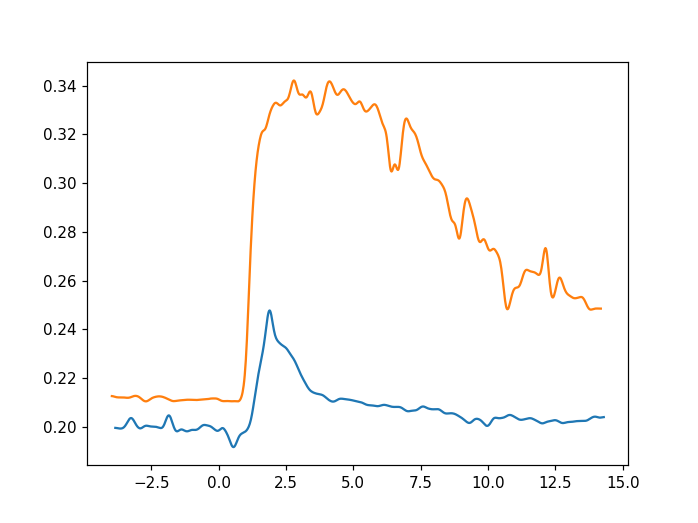

In [39]:
seq = pickle.load(open('./SeqClasses/2019-06-04-08-36-49_DMG.obj','rb'))
seq2 = pickle.load(open('./SeqClasses/2019-06-04-15-32-56_LNR.obj','rb'))
fig,ax = plt.subplots()
ax.plot(seq.ts,seq.smooth_data[:,3,2])
ax.plot(seq2.ts,seq2.smooth_data[:,3,2])
fig.show()

In [42]:
## Analyze the emergence of selectivity (using slope simulation)
## for each block

## get the slope for every bird
## Add it to a list (along with the 0 points, similar to before, but a different metric)

## Plot the emergence (or divergence...or neither) of selectivity over time

latency_list = []
duration_list = []
resp_list = []
slope_array = np.empty([n_blocks,n_birds])
p_array = np.empty_like(slope_array)
p_array.fill(np.nan)
slope_array.fill(np.nan)
print('working on it....')
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]

        
        block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        latencies = np.array(data_array[f,b,:,1])
        durations = np.array(data_array[f,b,:,2])
        latencies[data_key[f,b,:,2] == 0] = np.nan
        durations[data_key[f,b,:,2] == 0] = np.nan

        if len(latencies[~np.isnan(latencies)]) > 0 and len(block_n[~np.isnan(block_n)]) > 1:
            responsivity = np.nanmean(block_n)
            mean_latency = np.nanmean(latencies)
            mean_duration = np.nanmean(durations)
            latency_list.append(mean_latency)
            duration_list.append(mean_duration)
            resp_list.append(responsivity)
        else:
            print('no responses!')
            responsivity = 0
        latency = np.nanmean(data_array[f,b,:,0])
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope
        params = CSD_Params(n_birds=1,n_blocks=1,sort_me=False)
        p,z,_ = csd_sim(slope,responsivity,params=params)
        #print('slope:',slope,'responsivity:',responsivity)
        #print(p,z)
        ## This happens when responsivity == 1
        if p==0:
            print('p == 0!...')
            p_array[b,f] = 0
        elif z > 0:
            p_array[b,f] = -1 * np.log(1/p)
        else:
            p_array[b,f] = np.log(1/p)

working on it....
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
10
10
no responses!
10
10
10
10
10
10
10
10
10
10
no responses!
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
10
10
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
10
10
10
10
10
10
10
10
10
10
no responses!
10
10
no responses!
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!
10
10
no responses!


<IPython.core.display.Javascript object>


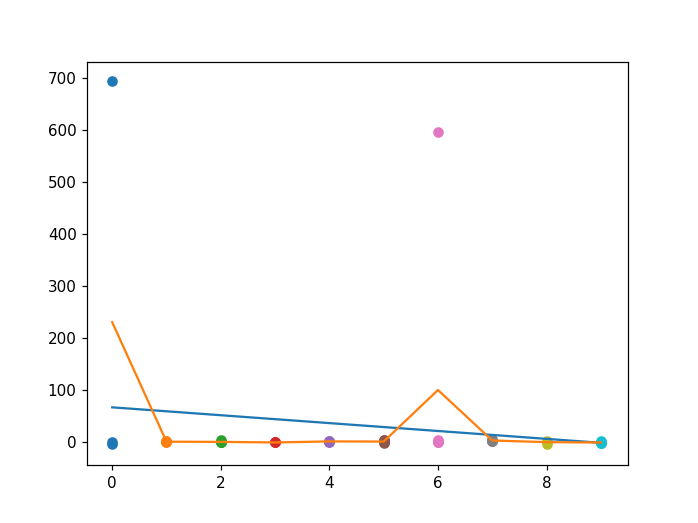

Using Means:
(-0.4283002208473476, 0.21687015383194713)
Pearsons r: -0.153
p: 0.333449197065364


In [43]:
## Actually Plot stuff (to avoid re-running every time I change font)
fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(10):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    #good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    good_points = p_array[n,:][~np.isnan(p_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
    
for f in range(n_birds):
    ys = p_array[:,f][~np.isnan(p_array[:,f])]
    xs = np.argwhere(~np.isnan(p_array[:,f]))
    xs = np.reshape(xs,len(xs))
    #ax.plot(xs,ys)
    #print(pearsonr(xs,ys))
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(10)))
ax.plot(np.arange(10),np.nanmean(p_array[:10],1))


print('Using Means:')
print(pearsonr(np.arange(10),np.nanmean(p_array[:10],1)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)))
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
#ax.set_xlim([0,9])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)

#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

In [ ]:
## Check which birds are selective

<IPython.core.display.Javascript object>


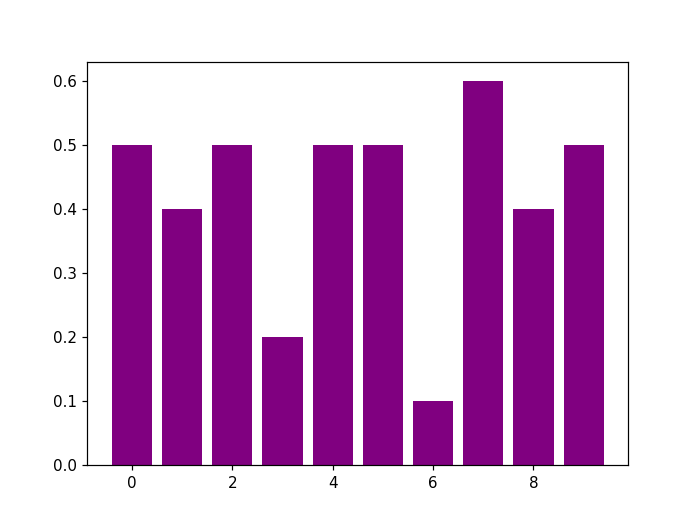

In [128]:
fig,ax = plt.subplots()
ax.bar(range(10),np.nanmean(plot_array[11][true_order],0),color='purple')

fig.show()

(11, 10)
(15,)
(15, 11)
[5.45454545 2.75909091 1.53263403 1.58636364 2.07121212 1.86072261
 1.32833833 2.58484848 1.88181818 1.49708625 1.70804196]
[0.8        0.54545455 0.27272727 0.3        0.5        0.54545455
 0.42857143 0.66666667 0.7        0.33333333 0.54545455]
-0.007191919191919187
-0.011691877589735899
-0.00686715059338633
-0.007276200399409557
-0.02252665646959721
-0.021404777496227535
-0.028109118257025004
-0.02568474901417456
-0.018123261601522462
-0.015690576453519227
-0.026994613483866295


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


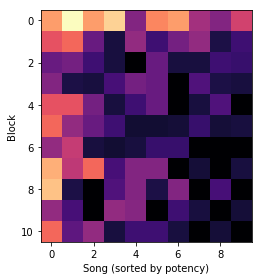

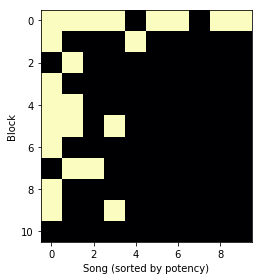

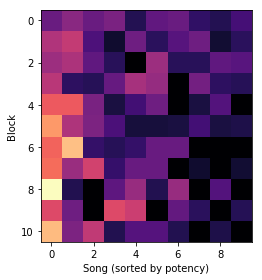

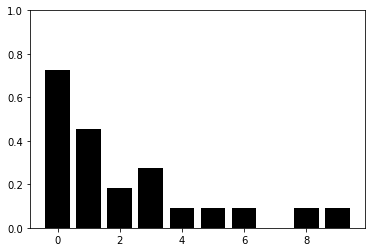

In [331]:
## Grab the data and plot for Fig5
mean_responses = np.nanmean(binary_array_all[safe_indices],0)[:,song_order]

print(np.shape(mean_responses))
fig,(ax) = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()

ax.imshow(mean_responses,vmin=0,cmap='magma')



ax2.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0,cmap='magma')


normed_responses = mean_responses / np.sum(mean_responses,1)[:,None]


bird_responses = np.nanmean(binary_array_all[safe_indices],2)
bird_order = np.argsort(np.sum(bird_responses,1))[::-1]
print(np.shape(bird_order))
print(np.shape(bird_responses))
#ax1.imshow(np.transpose(bird_responses[bird_order])[:,:])
ax1.imshow(np.transpose(binary_array_all[19,:,song_order]),vmin=0,cmap='magma')
print(np.sum(mean_responses,1))
print(np.max(mean_responses,1))

for b in range(11):
    slope,intercept = np.polyfit(range(n_songs),normed_responses[b],1)
    print(slope)
#ax1.imshow(mean_responses / np.sum(mean_responses,1)[:,None],vmin=0)

ax.set_xlabel('Song (sorted by potency)')
ax.set_ylabel('Block')

ax1.set_xlabel('Song (sorted by potency)')
ax1.set_ylabel('Block')

ax2.set_xlabel('Song (sorted by potency)')
ax2.set_ylabel('Block')


fig.show()
fig1.show()
fig2.show()

fig.tight_layout()
fig1.tight_layout()
fig2.tight_layout()

fig.savefig('/home/ammon/Desktop/PaperFigs/6b_.svg')
fig1.savefig('/home/ammon/Desktop/PaperFigs/6a_.svg')
fig2.savefig('/home/ammon/Desktop/PaperFigs/6c_.svg')

fig3,ax3 = plt.subplots()

ax3.bar(range(10),np.sum(binary_array_all[19,:,song_order] / 11,1),color='black')
ax3.set_ylim([0,1])

fig3.savefig('/home/ammon/Desktop/PaperFigs/6e_.svg')

[ 0  1  2  3  4  5  8  9 10 11 12 14 16 17 18 19 21 23 24] [ 0  1  2  3  4  5  6  7 10 12 13 17 19 21 23]
0


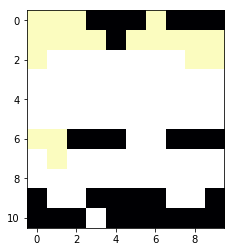

1


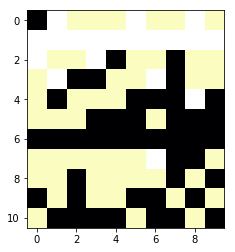

2


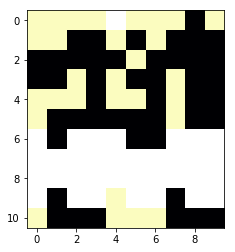

3


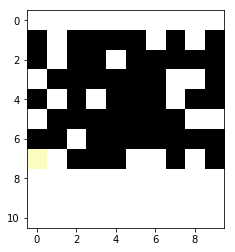

4


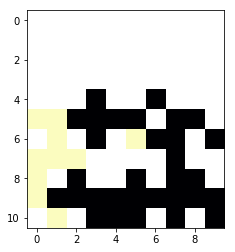

5


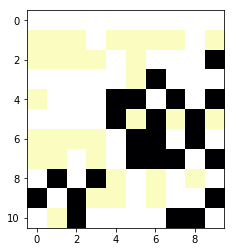

10


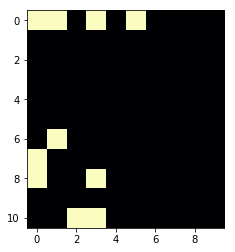

12


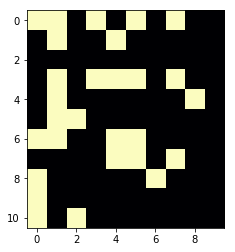

17


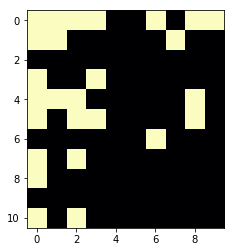

19


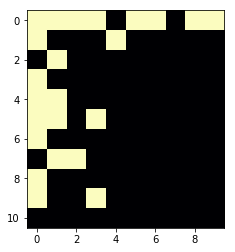

21


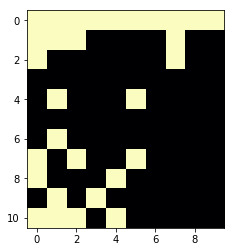

23


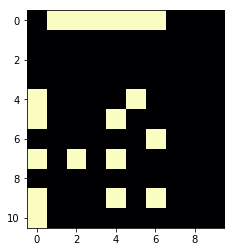

In [320]:
non_lesions = [0,3,5,6,10,12,14,16]
non_indices = np.array(non_lesions) + 7
print(np.arange(len(responsive_birds))[responsive_birds],safe_indices)
responsive_birds_safe = np.intersect1d(np.arange(len(responsive_birds))[responsive_birds],safe_indices)
for b in responsive_birds_safe:
    print(b)
    plt.imshow(np.transpose(binary_array_all[b,:,song_order]),vmin=0,cmap='magma')
    plt.show()

In [176]:
## Same as above, but for all the birds (birdview3 and birdview)

## Plot the emergence (or divergence...or neither) of selectivity over time using simulated distributions

bird_array = binary_array_all

n_blocks = 11
n_birds = len(bird_array)

resp_list = []
resp_array = np.empty([n_blocks,n_birds])
resp_array.fill(np.nan)
slope_array = np.empty([n_blocks,n_birds])
p_array = np.empty_like(slope_array)
slope_array.fill(np.nan)
p_array.fill(np.nan)
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = bird_array[f,b,:]
        
        block_n = block_n[true_order]
        #block_n = block_n[np.argsort(block_n)[::-1]]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        responsivity = np.nanmean(block_n)
        resp_list.append(responsivity)
        resp_array[b,f] = responsivity
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope
        params = CSD_Params(n_birds=1,n_blocks=1,sort_me=False)
        p,z,_ = csd_sim(slope,responsivity,params=params)
        print('slope:',slope,'responsivity:',responsivity)
        if p < .1:
            print('****')
        print(p,z)
        ## This happens when responsivity == 1
        if p==0:
            print('p == 0!...')
            p_array[b,f] = 0
        elif z > 0:
            p_array[b,f] = -1 * np.log(1/p)
        else:
            p_array[b,f] = np.log(1/p)
     

slope: -0.10909090909090907 responsivity: 0.4
****
0.04284243863540938 -2.025242801634694
slope: 0.006060606060606117 responsivity: 0.9
0.8568791814514711 0.1803482463606538
slope: -1.8439800764933342e-17 responsivity: 1.0
0.9828863562646367 0.021450416483237603


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


slope: -0.09433962264150943 responsivity: 0.25
****
0.05032928831008263 -1.9571546542210831
slope: 0.0 responsivity: 0.0
0.9847962677366782 0.019056205864626464
slope: 0.0 responsivity: 0.0
0.9951822740423945 -0.0060381607434496385
slope: 0.07673267326732672 responsivity: 0.8571428571428571
****
0.04621956934332323 1.9933825852502052
slope: -0.009009009009008952 responsivity: 0.75
0.8434085061378832 -0.19753549689268216
slope: 0.03333333333333332 responsivity: 0.625
0.5364244813950119 0.6182288708603536
slope: -0.10806451612903219 responsivity: 0.4444444444444444
****
0.05146925675011018 -1.947546448909408
slope: -0.10909090909090907 responsivity: 0.4
****
0.043289877296150844 -2.0209023239815784
slope: 0.0 responsivity: 0.0
0.9896474255594956 0.012975391985923746
slope: -0.07916666666666672 responsivity: 0.7777777777777778
****
0.0860929087232818 -1.7163778456713614
slope: -0.05454545454545455 responsivity: 0.7
0.2803903193439111 -1.0794429358977236
slope: 0.018181818181818205 respons

slope: -0.04848484848484848 responsivity: 0.2
0.2720345946124262 -1.098389158070853
slope: 0.0 responsivity: 0.0
0.9876939071923363 0.015424011631546311
slope: -0.03030303030303028 responsivity: 0.5
0.5731497731018375 -0.5634187490311217
slope: 0.0 responsivity: 0.2
0.9865604831724598 -0.016844733006287523
slope: -0.07272727272727272 responsivity: 0.2
0.10190805547788828 -1.635672941353469
slope: -0.09696969696969697 responsivity: 0.4
****
0.07457541068069287 -1.7830669190222985
slope: 0.030303030303030328 responsivity: 0.3
0.5574282438816855 0.586665706617477
slope: -0.03636363636363634 responsivity: 0.2
0.4089806975371273 -0.8256887113753408
slope: -0.05454545454545453 responsivity: 0.1
****
0.09861902047582942 -1.6515857816475377
slope: -0.08484848484848483 responsivity: 0.2
****
0.050325755941028436 -1.9571847088503036
slope: 0.0 responsivity: 0.0
0.9947042733421587 -0.006637257819373894
slope: 0.0 responsivity: 0.0
0.9880625450706454 -0.0149619392368021
slope: 0.0 responsivity: 0.

slope: 0.0 responsivity: 0.0
0.9930121682759244 -0.00875806025016415
slope: -0.04242424242424243 responsivity: 0.1
0.20877140143829787 -1.2569509390496085
slope: -0.07878787878787875 responsivity: 0.3
0.1179362810929272 -1.5634947010211686
slope: -0.06060606060606059 responsivity: 0.2
0.15994079234935288 -1.4052707176332597
slope: -0.06060606060606057 responsivity: 0.2
0.17713666222728552 -1.349623873873846
slope: -0.1333333333333333 responsivity: 0.4
****
0.013189968743030734 -2.47859849726707
slope: 0.0 responsivity: 0.0
0.9845519918427978 0.019362416787370617
slope: 0.0 responsivity: 0.0
0.99016234981983 0.012329978459399241
slope: 0.0 responsivity: 0.0
0.9976290780440873 0.002971514378839354
slope: 0.0 responsivity: 0.0
0.9904460248923291 0.011974418225885705
slope: 0.0 responsivity: 0.0
1.0 -1.9297675606056365e-17
slope: 0.0 responsivity: 0.0
0.9981409347229149 0.0023299949021704206
slope: 0.0 responsivity: 0.0
0.9952281313547818 -0.005980686087740596
slope: 0.0 responsivity: 0.0


skip me! 6
skip me! 7
skip me! 8
skip me! 9
skip me! 11
skip me! 13
skip me! 14
skip me! 15
skip me! 16
skip me! 18
skip me! 20
skip me! 22
skip me! 24


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


95% CI for dur slope is [-0.00709969  0.18532482]
Pearsons r: 0.155
p: 0.10173850423472959


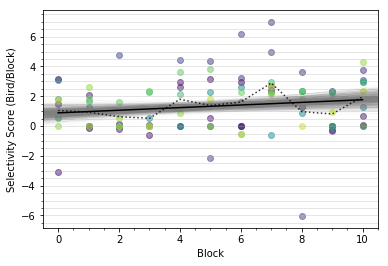

In [321]:
## Plot everything Fig5

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []
y_means = []

for n in range(11):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    #good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = p_array[n,:][~np.isnan(p_array[n,:])]

    good_points = p_array[n,responsive_birds_safe][~np.isnan(p_array[n,responsive_birds_safe])]

    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    y_means.append(np.mean(good_points))
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    #ax.scatter(good_xs,good_points)
#print(ypoints_byblock)

n_birds = 25
for f in range(n_birds):
    
    if responsive_birds[f] == 0 or f not in safe_indices:
        print('skip me!',f)
        continue
    good_points = p_array[:,f][~np.isnan(p_array[:,f])]
    ys = p_array[:,f][~np.isnan(p_array[:,f])]
    xs = np.argwhere(~np.isnan(p_array[:,f]))
    xs = np.reshape(xs,len(ys))
    ax.scatter(xs,ys,color=color_map(f/25),alpha = .5)
    r,p = pearsonr(xs,ys)
    #print(r,p)
    if p < .05 and False:
        ax.plot(xs,ys,linestyle=':',alpha=.5,color='gray')
    if f == 5 and False:
        ax.plot(xs,ys,alpha=.5,color=color_map(f/25))

boxes = []
for b in range(len(p_array)):
    boxes.append(p_array[b,responsive_birds_safe][~np.isnan(p_array[b,responsive_birds_safe])])

    
#ax.boxplot(boxes,positions=range(11),showmeans=True)
xpoint_array = np.array(xpoint_list)
ypoint_array = np.array(ypoint_list)



#slope,intercept = np.polyfit(xpoint_array[ypoint_array >= 0],ypoint_array[ypoint_array >= 0],1)
#corr,p_value = pearsonr(xpoint_array[ypoint_array >= 0],ypoint_array[ypoint_array >= 0])
slope,intercept = np.polyfit(xpoint_array,ypoint_array,1)
corr,p_value = pearsonr(xpoint_array,ypoint_array)

### DO some bootstrapping
sel_slope_reps, sel_intercept_reps = draw_bs_pairs_linreg(x=xpoint_array, y=ypoint_array, size=5000)
#dur_slope_reps, dur_intercept_reps = draw_bs_pairs_linreg(x=np.array(dur_xs), y=np.array(dur_ys), size=5000)


x = np.array([-1,11])
#plt.figure(figsize=(10, 8))

# Plot the bootstrap lines
for i in range(1000):
    _ = ax.plot(x, sel_slope_reps[i]*x + sel_intercept_reps[i],
                 linewidth=0.2, alpha=0.1, color='gray')

fit_line = np.poly1d([slope,intercept])

#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)),notch=True,bootstrap=5000)
#print(slope,intercept)
#ax.set_ylim([-4,6])
ax.set_xlabel('Block')
ax.set_ylabel('Selectivity Score (Bird/Block)')

ax.minorticks_on()

ax.yaxis.grid(which='major',alpha=.4)
ax.yaxis.grid(which='minor',alpha=.4)

ax.set_xlim([-.5,10.5])
fig.show()

#ax.plot(range(11),2 * np.log(np.arange(1,12)),color='black',alpha=.8,linestyle=':')
ax.plot(fit_line(np.arange(n_blocks)),color='black')
ax.plot(range(11),y_means,color='black',alpha=.8,linestyle=':')
print("95% CI for dur slope is {}".format(np.percentile(sel_slope_reps, [2.5, 97.5])))

print('Pearsons r: %.3f' % corr)
print('p:',p_value)
 

fig.savefig('/home/ammon/Desktop/PaperFigs/6d_sorted.svg')

<IPython.core.display.Javascript object>


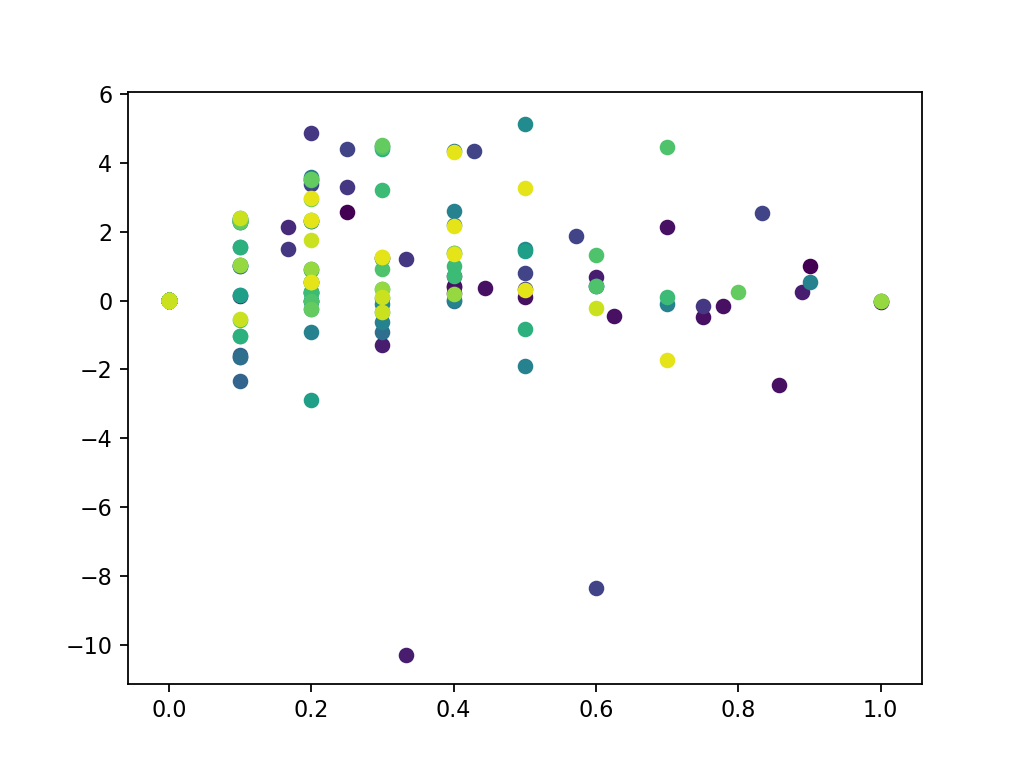

In [389]:
fig,ax = plt.subplots()
for n in range(25):
    ax.scatter(resp_array[:,n],p_array[:,n],color=color_map(n/25))
fig.show()

In [1172]:
#slope3,intercept3 = np.polyfit(dur_xs,sorted(dur_ys)[::-1],1)
print(slope3)
print(fit_line3(0))

-0.9530853090055322
-8.25072274522048


<IPython.core.display.Javascript object>


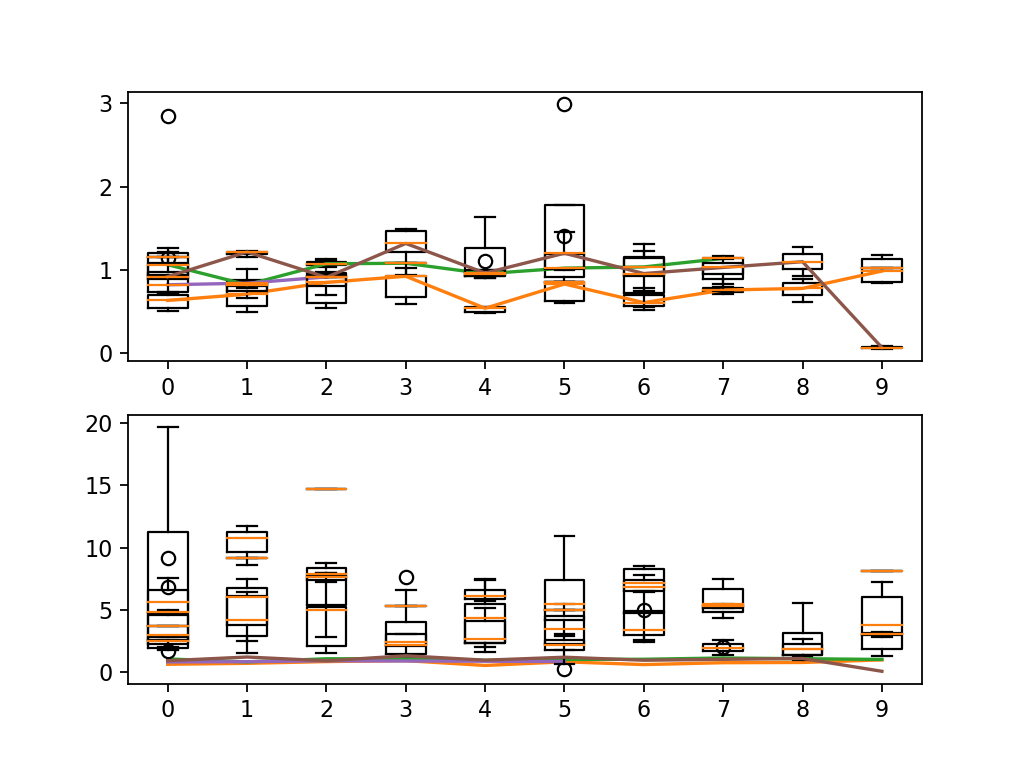

/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [349]:
## Plot latencies and durations split by bird

fig,(ax1,ax2) = plt.subplots(2)

bird_durations_bysong = [np.nan] * n_birds
bird_latencies_bysong = [np.nan] * n_birds


## As before, but now by bird by song
for b in range(n_birds):
    
    birdsong_durations = [np.nan] * n_songs
    birdsong_latencies = [np.nan] * n_songs

    for i in range(len(song_order)):
        n = song_order[i]
        p_indices = np.logical_and(~np.isnan(data_array[b,:,n,2]),data_array[b,:,n,0] == 1)
        crap_indices = data_key[b,:,n,2] == 0
        birdsong_durations[i] = data_array[b,:,n,2][np.logical_and(p_indices,~crap_indices)]
        birdsong_latencies[i] = data_array[b,:,n,1][np.logical_and(p_indices,~crap_indices)]
    bird_durations_bysong[b] = birdsong_durations
    bird_latencies_bysong[b] = birdsong_latencies
    ax1.boxplot(birdsong_latencies,positions=range(n_songs))
    ax2.boxplot(birdsong_durations,positions=range(n_songs))
    lat_meds = [np.nanmedian(birdsong_latencies[i]) for i in range(n_songs)]
    dur_meds = [np.nanmedian(birdsong_durations[i]) for i in range(n_songs)]
    med_array = np.array(lat_meds)
    ax1.plot(range(n_songs),lat_meds)
    ax2.plot(np.arange(n_songs)[~np.isnan(med_array)],med_array[~np.isnan(med_array)])
    if False:
        print(len(med_array[~np.isnan(med_array)]))
        if len(med_array[~np.isnan(med_array)]) > 0:
            print(spearmanr(med_array[~np.isnan(med_array)],range(len(med_array[~np.isnan(med_array)]))))
            print(med_array)
        else:
            print('no data:',med_array)
    
    
#print(bird_durations_bysong)

"""
for s in range(n_songs):
    ax2.scatter([s]*len(song_durations[s]),song_durations[s],alpha=.5,label=song_list[true_order[s]])
    ax1.scatter([s]*len(song_latencies[s]),song_latencies[s],alpha=.5)
    
    lat_xs.extend([s]*len(song_latencies[s]))
    lat_ys.extend(song_latencies[s])
    dur_xs.extend([s]*len(song_durations[s]))
    dur_ys.extend(song_durations[s])
    
    mean_durations[s] = np.mean(song_durations[s])
"""
pass

(7, 14, 10, 4)
[0.49699974 0.48399997 0.49300027 0.05299997 0.08100009]
1 2 2
['2019-06-19-08-33-16_ND' 'birdview-2' 1]
1 4 7
['2019-06-21-10-04-58_WG' 'birdview-2' 1]
1 9 7
['2019-06-27-10-04-26_WG' 'birdview-2' 1]
5 1 9
['2019-06-18-11-46-13_DMG' 'birdview' 1]
5 5 9
['2019-06-22-13-16-14_DMG' 'birdview' 1]
2019-06-21-10-04-58_WG 1.0 none


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


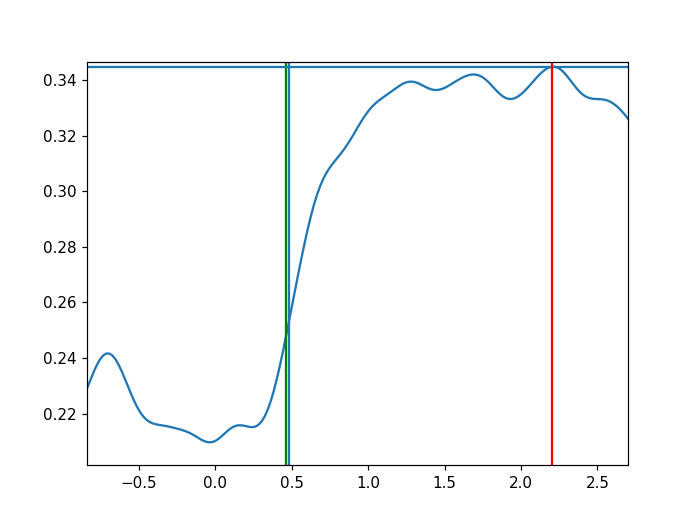

0.46399998664855957
none


In [629]:
## Do some outlier checking

print(np.shape(data_array))
print(data_array[:,:,:,1][data_array[:,:,:,1] < .5])
#print(np.where(data_array[:,:,:,1] > .1))
blocks,birds,songs = np.where(data_array[:,:,:,1] < .5)
for i in range(len(blocks)):
    a,b,c = blocks[i],birds[i],songs[i]
    
    print(a,b,c)
    print(data_key[a,b,c])

## Super Comment? 
"""
Long Durations, fixed now.
0: 1,11,5 ['2019-06-29-07-03-05_DBR' 'birdview-2'] -> floor posture (normal length) (CHECK!!)
1: 4,6,2 ['2019-06-10-11-46-12_ND' 'birdview'] -> very long
2: 4,7,8 ['2019-06-12-11-46-13_LNR' 'birdview'] -> very long, holds tail up after the end of posture...(need PCA)
3: 4,8,0 ['2019-06-13-07-16-15_BDY' 'birdview'] -> quite long, holds tail up after (great cloaca, btw)
4: 5,3,4 ['2019-06-20-15-46-13_2M' 'birdview'] -> no posture (CHECK!!)
5: 5,6,2 ['2019-06-23-10-16-14_ND' 'birdview'] -> very short, some flying around (CHECK)
6: 5,10,2 ['2019-06-28-18-46-14_ND' 'birdview'] -> Pretty normal, but starts upside down, could cause issues
7: 5,11,4 ['2019-06-29-10-16-14_2M' 'birdview'] -> floor posture, ends in frame, pretty short (CHECK) -> crap seq, what is it doing here?
8: 5,11,6 ['2019-06-29-17-16-15_GRG' 'birdview'] -> very normal, slightly weak posture, probably accurate...

Long Latencies: 
2 4 2 ['2019-06-04-18-42-42_ND' 'birdview-2' 1] -> floor posture, unlabeled
2 5 0 ['2019-06-06-07-03-02_BDY' 'birdview-2' 1] -> starts on ceiling
3 1 4 ['2019-05-23-11-06-05_2M' 'birdview-2' 1] -> not a posture, mislabeled and a big 3d error
5 3 4 ['2019-06-20-15-46-13_2M' 'birdview' 1] -> Probably a tail id error. PCA could fix? Or Confidence
"""
seq_dir = './CrapSeqs/'
seq_dir = './SeqClasses/'
s = data_key[1,4,7,0] + '.obj'
seq = pickle.load(open(seq_dir + s,'rb'))
print(seq.seq_name,seq.posture, seq.notes)
fig,ax = plt.subplots()

ax.plot(seq.ts,seq.smooth_data[:,3,2])
ax.axvline(seq.ts[seq.vmax_index])
ax.axvline(seq.ts[seq.refraction_index])
ax.axvline(seq.ts[seq.t_latency_index],color='green')
print(seq.t_latency)
ax.axhline(seq.peak_height)
ax.axvline(seq.ts[seq.peak_height_index],color='red')
print(seq.notes)

In [1026]:
## Perform analysis by time:

## Loop through all the sequences to extract time stamps

n_postures = len(os.listdir('./SeqClasses/'))
hour_list = []
date_dict = {}
date_count = 0
## Takes a time stamp, the posture, song?, latency, duration
timed_data = np.array([n_postures,3])
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    hour = int(seq.seq_name.split('-')[3])
    if not hour in hour_list:
        hour_list.append(hour)
    if not seq.date in date_dict.keys():
        date_dict[seq.date] = date_count
        date_count += 1

hour_list = sorted(hour_list)

## Split them out by time of day and date so I can run correlations. Easy peasy. 

In [1002]:
## Get the data organized

n_days = len(date_dict.keys())
n_hours = len(hour_list)
date_array = np.zeros([n_days,n_songs,2])
hour_array = np.zeros([n_hours,n_songs,2])

hour_indices = dict(zip(hour_list,range(len(hour_list))))


latency_by_date = [[] for n in date_dict.keys()]
duration_by_date = [[] for n in date_dict.keys()]
latency_by_hour = [[] for n in hour_list]
duration_by_hour = [[] for n in hour_list]

## Loop back through, and grab data and arrange it nicely
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    hour = int(seq.seq_name.split('-')[3])
    hour_index = hour_indices[hour]
    date_index = date_dict[seq.date]
    song_index = song_dict[seq.song]
    if seq.posture == 1:
        date_array[date_index,song_index] += 1
        hour_array[hour_index,song_index] +=1
    else:
        date_array[date_index,song_index,1] += 1
        hour_array[hour_index,song_index,1] += 1
    if seq.offset != 0 and seq.posture == 1:
        latency_by_date[date_index].append(seq.t_vmax[0])
        latency_by_hour[hour_index].append(seq.t_vmax[0])
        duration_by_date[date_index].append(seq.duration)
        duration_by_hour[hour_index].append(seq.duration)
        
        

(0.38959240462396605, 0.0056574331638120715)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


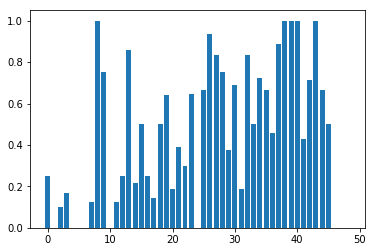

In [1022]:
# Plot responses by hour and time
songs_by_hour = hour_array[:,:,0] / hour_array[:,:,1]
songs_by_date = date_array[:,:,0] / date_array[:,:,1]


fig,(ax1,ax2) = plt.subplots()
ax1.bar(range(len(songs_by_date)),np.nanmean(songs_by_date,1))
#ax2.bar(range(n_hours),np.nanmean(songs_by_hour,1))
#print(pearsonr(range(n_hours),np.nanmean(songs_by_hour,1)))

print(pearsonr(range(len(songs_by_date)),np.nanmean(songs_by_date,1)))
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


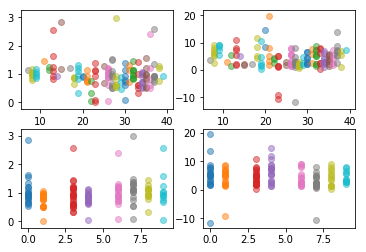

In [1025]:
## Look at latency, duration by time
fig,axes = plt.subplots(2,2)

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
date_lat_means = []
hour_lat_means = []
for n in range(len(latency_by_date)):
    ax1.scatter([n] * len(latency_by_date[n]),latency_by_date[n],alpha=.5)
    ax2.scatter([n] * len(duration_by_date[n]),duration_by_date[n],alpha=.5)
    
for h in range(len(latency_by_hour)):
    ax3.scatter([h] * len(latency_by_hour[h]),latency_by_hour[h],alpha=.5)
    ax4.scatter([h] * len(duration_by_hour[h]),duration_by_hour[h],alpha=.5)
    
fig.show()

[        nan         nan         nan         nan         nan         nan
         nan  3.67400002  6.31825009  7.98940005         nan  2.89499998
  3.38400006  6.02216665  4.99099994  2.04599988         nan  2.02100015
  7.41974998  3.60416667 11.60300004  7.6230001   3.6160001  -0.8011429
         nan  2.26099992  4.18336365  1.81400003  1.81971427  3.03766664
  4.06857143  5.32099994  4.99655557  4.56833335  3.72522224  3.83625001
  4.32919998  7.04100004  4.50733336  7.421              nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
(0.051838631621938344, 0.7855835819659772)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


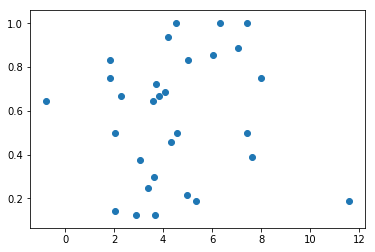

In [1104]:
# Compare response rate and duration

mean_durations = np.zeros(len(duration_by_date))
for d in range(len(duration_by_date)):
    mean_durations[d] = np.nanmean(duration_by_date[d])

fig,ax = plt.subplots()
ax.scatter(mean_durations,np.nanmean(songs_by_date,1))
print(mean_durations)
print(pearsonr(mean_durations[~np.isnan(mean_durations)],np.nanmean(songs_by_date,1)[~np.isnan(mean_durations)]))
fig.show()

In [992]:
### We have a smallish problem here, could be a big problem....

from datetime import datetime
timestamp = 1545730073
dt_object = datetime.fromtimestamp(seq.timestamp)
print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))
print(seq.seq_name)
print(int(seq.seq_name.split('-')[3]))


dt_object = 2019-05-22 17:00:02.810000
type(dt_object) = <class 'datetime.datetime'>
2019-05-22-17-02-54_LB
17
1558558810.525 2.0


<IPython.core.display.Javascript object>


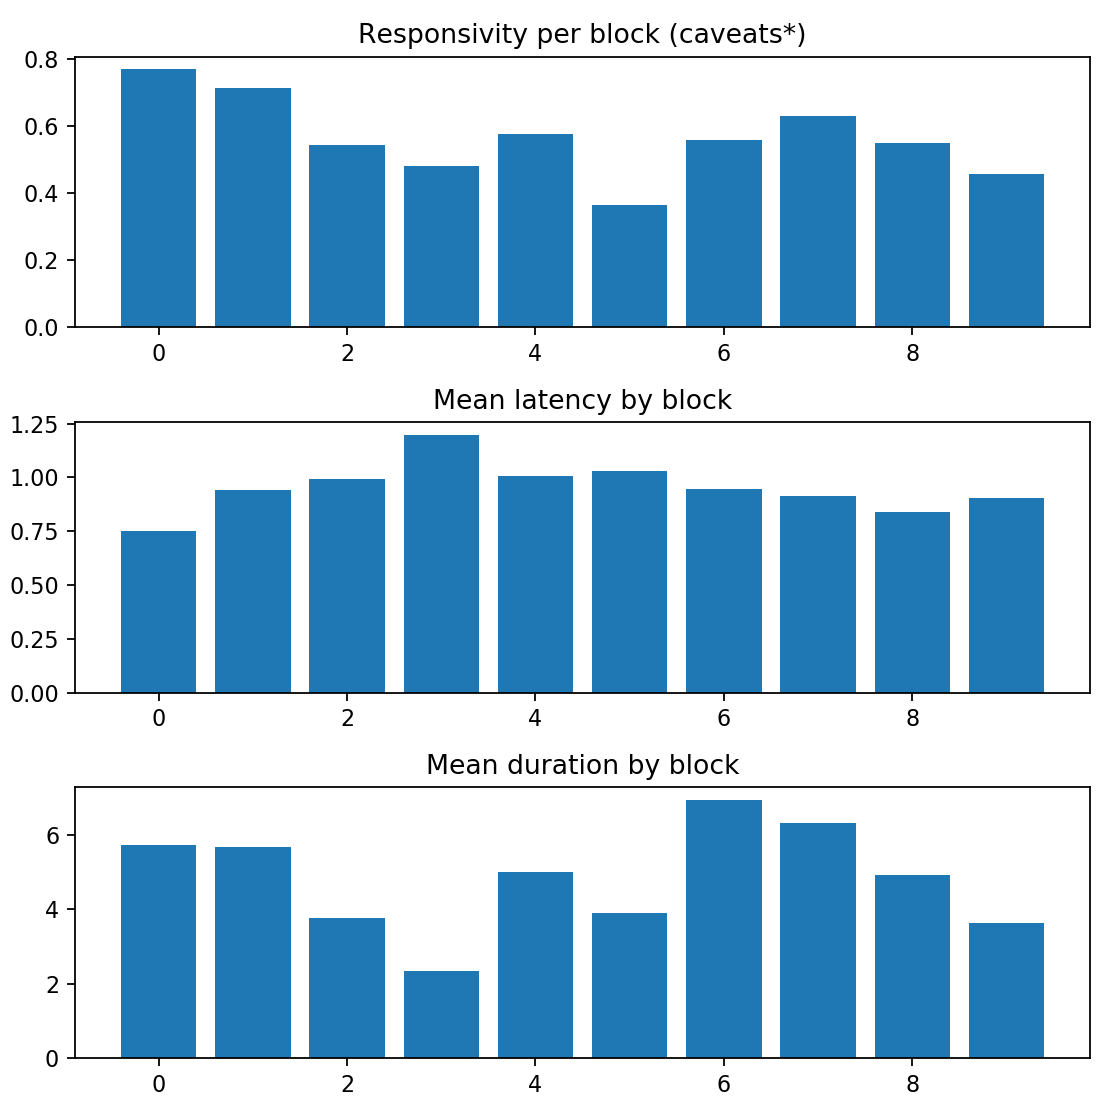

In [350]:

## Plot postures, latency, duration by block (careful...)
block_sums = np.nansum(data_array,axis=(0,2))
block_means = np.nanmean(data_array,axis=(0,2))
block_std = np.nanstd(data_array,axis=(0,2))
fig,(ax1,ax2,ax3) = plt.subplots(3)

ax1.set_title('Responsivity per block (caveats*)')
ax1.bar(range(10),block_means[:10,0])
#ax1.bar(range(14),block_means[:,0],yerr=block_std[:,0])

ax2.set_title('Mean latency by block')
ax2.bar(range(10),block_means[:10,1]) #,yerr=block_std[:,0])

ax3.set_title('Mean duration by block')
ax3.bar(range(10),block_means[:10,2])


fig.set_size_inches(7,7)
fig.tight_layout()
fig.show()

fig.savefig('/home/ammon/Desktop/ToCompy/responsivity_byblock.png')

(7, 14, 10, 4)
(14, 4)


<IPython.core.display.Javascript object>


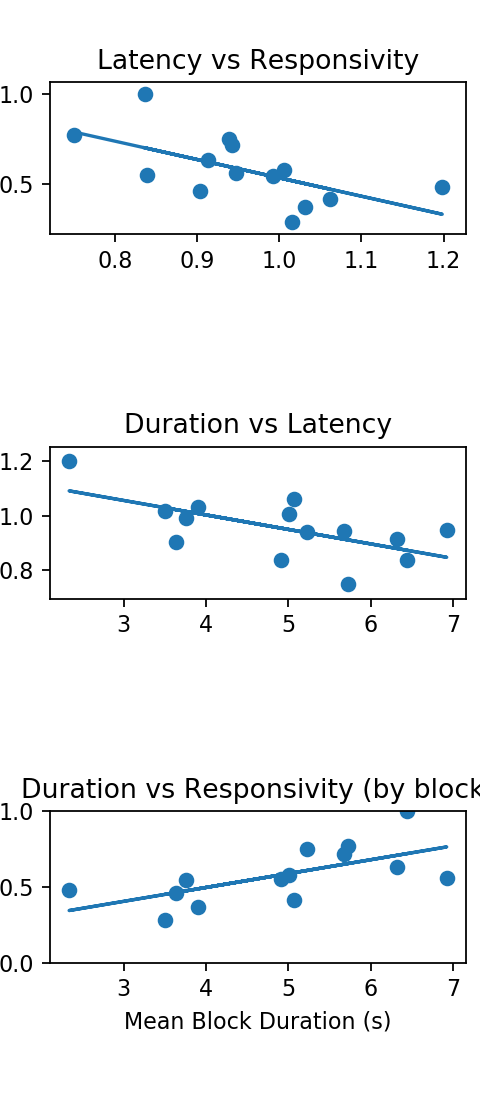

-0.6088463341855547 0.020841883714384328
-0.6269540535593585 0.016412148553243803
0.641882039157871 0.013332295230124669
SpearmanrResult(correlation=0.745054945054945, pvalue=0.0022300373167420734)


In [342]:
## Plot timing vs responsivity

print(np.shape(data_array))
print(np.shape(block_means))
fig,(ax1,ax2,ax3) = plt.subplots(3)


B = 10
ax1.set_title('Latency vs Responsivity')
ax1.scatter(block_means[:,1],block_means[:,0])
corr1,p_value1 = pearsonr(block_means[:,1],block_means[:,0])

slope1,intercept1 = np.polyfit(block_means[:,1],block_means[:,0],1)
fit_line = np.poly1d([slope1,intercept1])
ax1.plot(block_means[:,1],fit_line(block_means[:,1]))
print(corr1,p_value1)


ax2.set_title('Duration vs Latency')
ax2.scatter(block_means[:,2],block_means[:,1])
slope2,intercept2 = np.polyfit(block_means[:,2],block_means[:,1],1)
fit_line2 = np.poly1d([slope2,intercept2])
ax2.plot(block_means[:,2],fit_line2(block_means[:,2]))

corr2,p_value2 = pearsonr(block_means[:,2],block_means[:,1])
print(corr2,p_value2)

ax3.set_title('Duration vs Responsivity (by block)')

ax3.set_xlabel('Mean Block Duration (s)')
ax3.set_ylabel('Mean Block Responsivity Ratio')
ax3.set_ylim([0,1])
ax3.scatter(block_means[:,2],block_means[:,0])
slope3,intercept3 = np.polyfit(block_means[:,2],block_means[:,0],1)
fit_line3 = np.poly1d([slope3,intercept3])
ax3.plot(block_means[:,2],fit_line3(block_means[:,2]))

corr3,p_value3 = pearsonr(block_means[:,2],block_means[:,0])
print(corr3,p_value3)
print(spearmanr(block_means[:,2],block_means[:,0]))
fig.tight_layout()
fig.set_size_inches(3,7)
fig.show()

<IPython.core.display.Javascript object>


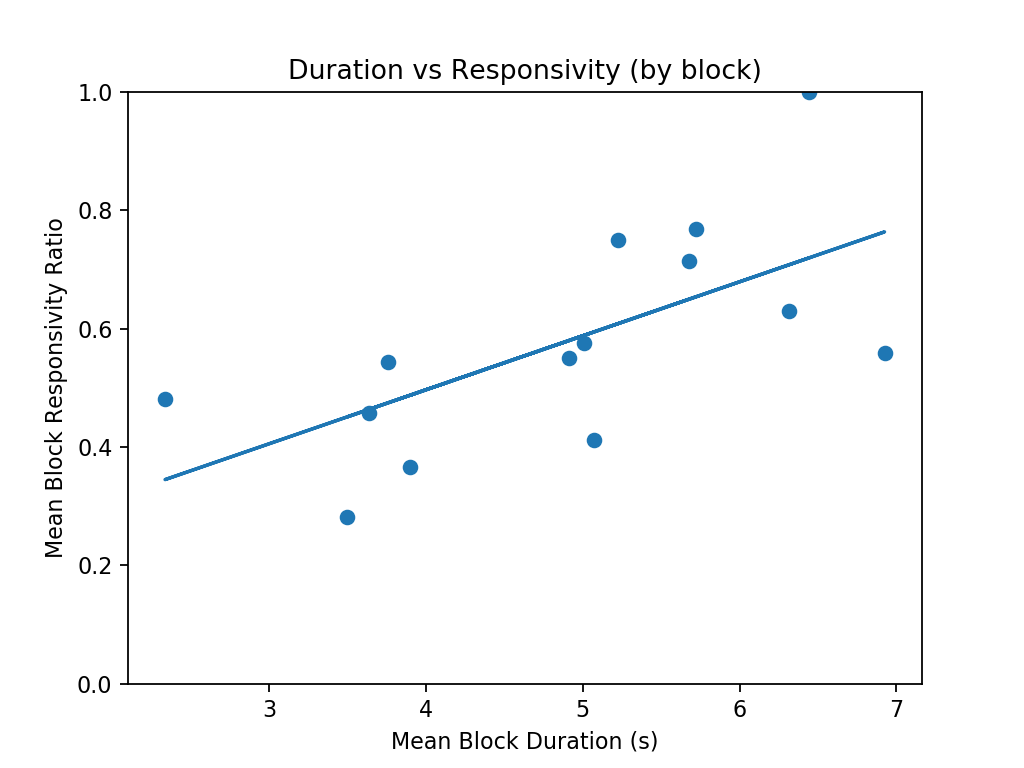

In [351]:
fig,ax = plt.subplots()

ax.set_title('Duration vs Responsivity (by block)')

ax.set_xlabel('Mean Block Duration (s)')
ax.set_ylabel('Mean Block Responsivity Ratio')
ax.set_ylim([0,1])
ax.scatter(block_means[:,2],block_means[:,0])
slope3,intercept3 = np.polyfit(block_means[:,2],block_means[:,0],1)
fit_line3 = np.poly1d([slope3,intercept3])
ax.plot(block_means[:,2],fit_line3(block_means[:,2]))

fig.show()

In [400]:
print(np.shape(binary_array[:,:,:,0]))
print(np.shape(data_key))

print(np.shape(binary_array[:,:,:,0][data_key[:,:,:,2] == 1]))

print(bird_list)

(7, 14, 10)
(7, 14, 10, 3)
(153,)
['CB-White', 'CB-Orange', 'CB-Yellow', 'CB-Red', 'CB-LB2', 'CB-Y2', 'CB-R2']


In [352]:
print(np.shape(np.nanmean(binary_array[:,b,:,0],axis=1)))
print(np.shape(binary_array))

(7,)
(7, 14, 10, 4)


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


0
1
2
3
4
5
6
7
8
9
10


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


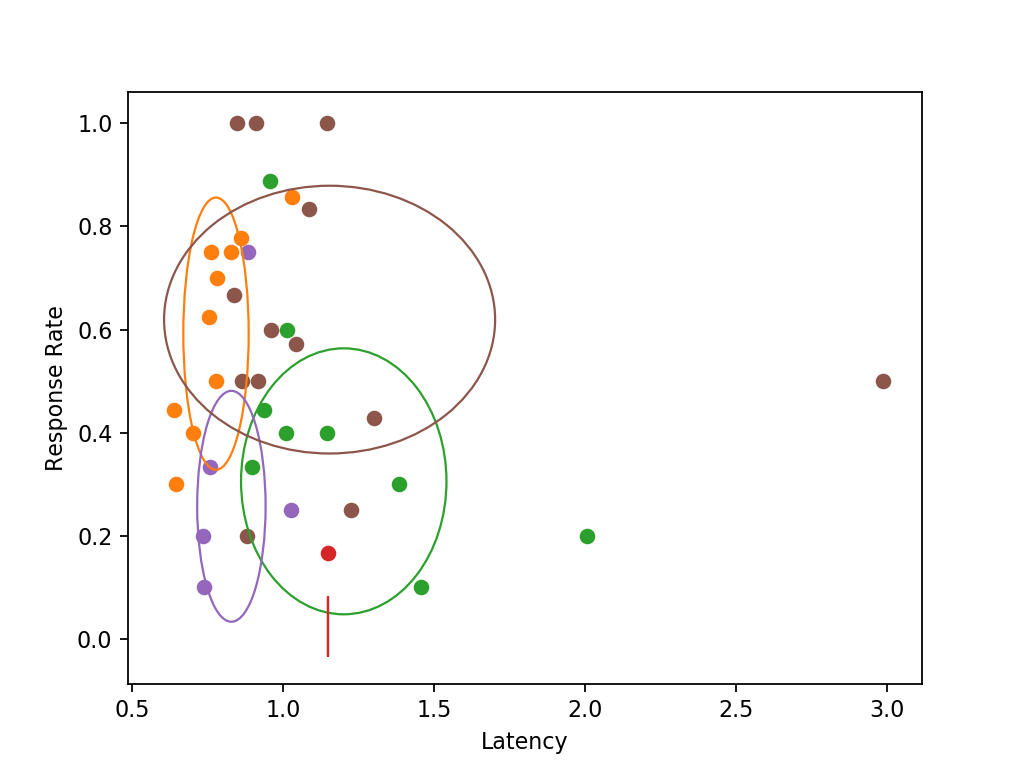

corr -0.1543983573601488 p: 0.3546810025157593


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [353]:
## Visualize Latency and Responsivity by bird, turned out to be less cool than I thought

bird_block_latencies = [[] for n in range(len(bird_list))]
bird_block_responses = [[] for n in range(len(bird_list))]
bird_block_durations = [[] for n in range(len(bird_list))]

block_bird_responses = [[] for n in range(n_blocks)]
block_bird_durations = [[] for n in range(n_blocks)]
block_bird_latencies = [[] for n in range(n_blocks)]

from matplotlib.patches import Ellipse

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

binary_array[:,:,:,1][data_key[:,:,:,2] == 0] = np.nan
binary_array[:,:,:,2][data_key[:,:,:,2] == 0] = np.nan
for b in range(len(bird_list)):
    bird_block_latencies[b] = np.nanmean(binary_array[b,:,:,1],axis=1)
    bird_block_responses[b] = np.nanmean(binary_array[b,:,:,0],axis=1)
    bird_block_durations[b] = np.nanmean(binary_array[b,:,:,2],axis=1)

## Same thing, but average by block this time.
# I chose a massochistic naming convention unfortunately

for b in range(n_blocks):
    print(b)
    block_bird_responses[b] = np.nanmean(binary_array[:,b,:,0],axis=1)
    block_bird_durations[b] = np.nanmean(binary_array[:,b,:,2],axis=1)
    block_bird_latencies[b] = np.nanmean(binary_array[:,b,:,1],axis=1)

fig,ax = plt.subplots()
ellipses = [[] for n in range(len(bird_list))]

ls = []
rs = []
for b in range(len(bird_list)):
    ax.scatter(bird_block_latencies[b],bird_block_responses[b],label=bird_list[b])
    l_mean = np.nanmean(bird_block_latencies[b])
    l_std = np.nanstd(bird_block_latencies[b])
    r_mean = np.nanmean(bird_block_responses[b])
    r_std = np.nanstd(bird_block_responses[b])
    ellipses[b] = Ellipse((l_mean,r_mean),width = l_std*2,height = r_std*2,facecolor='none',edgecolor=color_list[b])
    ax.add_patch(ellipses[b])
    
    good_l = bird_block_latencies[b][~np.isnan(bird_block_latencies[b])]
    good_r = bird_block_responses[b][~np.isnan(bird_block_latencies[b])]

    [ls.append(good_l[i]) for i in range(len(good_l))]
    [rs.append(good_r[i]) for i in range(len(good_r))]
    
slope,intercept = np.polyfit(ls,rs,1)
fit_line = np.poly1d([slope,intercept])
corr,p_value = pearsonr(ls,rs)

#ax.plot(ls,fit_line(ls))

    
ax.set_xlabel('Latency')
ax.set_ylabel('Response Rate')

print('corr',corr,'p:',p_value)

Pearsons r: 0.178


/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1270: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)
/home/ammon/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


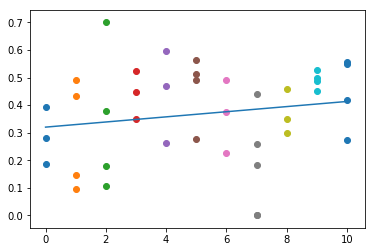

In [38]:
## Plot the emergence (or divergence...or neither) of selectivity over time
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon as js_divergence
from scipy.stats import pearsonr

js_array = np.empty([n_blocks,n_birds])
js_array.fill(np.nan)
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]
        mean_response = canon_means[f,:]
    
        mean_response = mean_response[~np.isnan(block_n)]
        block_n = block_n[~np.isnan(block_n)]
        
        if len(mean_response) == 0  or len(block_n) == 0:
            continue
        """
        if max(mean_response) == 0 or max(block_n) == 0:
            continue


        block_n[block_n == 0] = .001
        mean_response[mean_response == 0] == .001
        """
        #kl_div = entropy(block_n,mean_response)
        js_div = js_divergence(block_n,mean_response)

        if np.isnan(js_div):
            #print(block_n,mean_response)
            pass
        js_array[b,f] = js_div

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
for n in range(n_blocks):
    ax.scatter([n]*n_birds,js_array[n,:])
    good_points = js_array[n,:][~np.isnan(js_array[n,:])]
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    

corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))

fig.show()
print('Pearsons r: %.3f' % corr)

/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


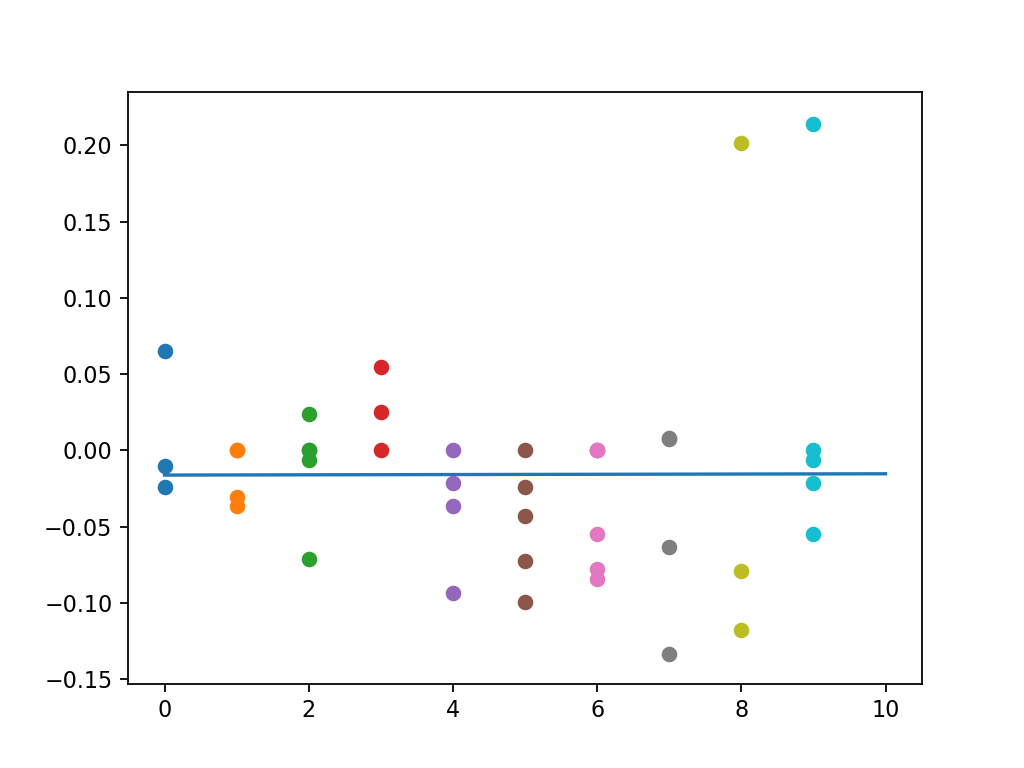

Pearsons r: 0.004
p: 0.9821524360943453


In [354]:
## plot the emergence of selectivity (using just slope)
## for each block

## get the slope for every bird
## Add it to a list (along with the 0 points, similar to before, but a different metric)

## Plot the emergence (or divergence...or neither) of selectivity over time

latency_list = []
duration_list = []
resp_list = []
slope_array = np.empty([n_blocks,n_birds])
slope_array.fill(np.nan)
n_birds = 7
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array[f,b,:,0]

        
        #block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        latencies = np.array(data_array[f,b,:,1])
        durations = np.array(data_array[f,b,:,2])
        latencies[data_key[f,b,:,2] == 0] = np.nan
        durations[data_key[f,b,:,2] == 0] = np.nan
        if len(latencies[~np.isnan(latencies)]) > 0 and len(block_n[~np.isnan(block_n)]) > 1:
            responsivity = np.nanmean(block_n)
            mean_latency = np.nanmean(latencies)
            mean_duration = np.nanmean(durations)
            latency_list.append(mean_latency)
            duration_list.append(mean_duration)
            resp_list.append(responsivity)
        latency = np.nanmean(data_array[f,b,:,0])
        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(10):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)))
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)

#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

<IPython.core.display.Javascript object>


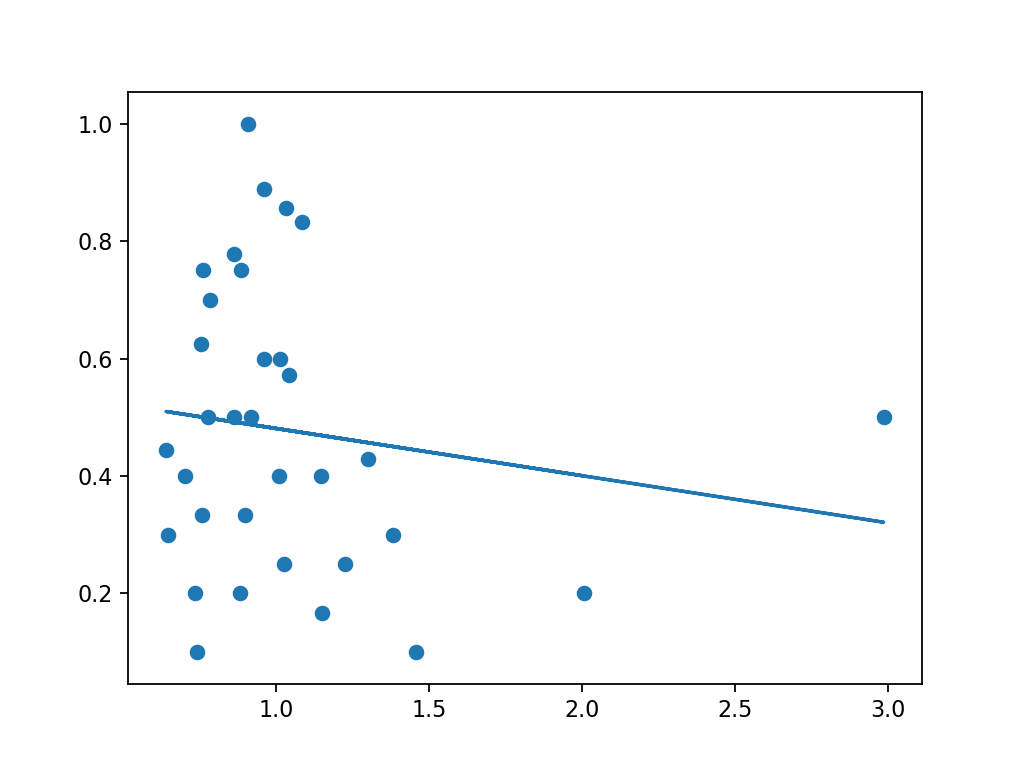

-0.14633066336842834 0.4164582893098038


In [357]:
## Are Latency and responsiveness correlated (by bird by block)

#print(latency_list,resp_list)
#print(len(latency_list),len(resp_list))
fig,ax = plt.subplots()
ax.scatter(latency_list,resp_list)

slope,intercept = np.polyfit(latency_list,resp_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(latency_list,fit_line(latency_list))

corr,p_value = pearsonr(latency_list,resp_list)
print(corr,p_value)
#

<IPython.core.display.Javascript object>


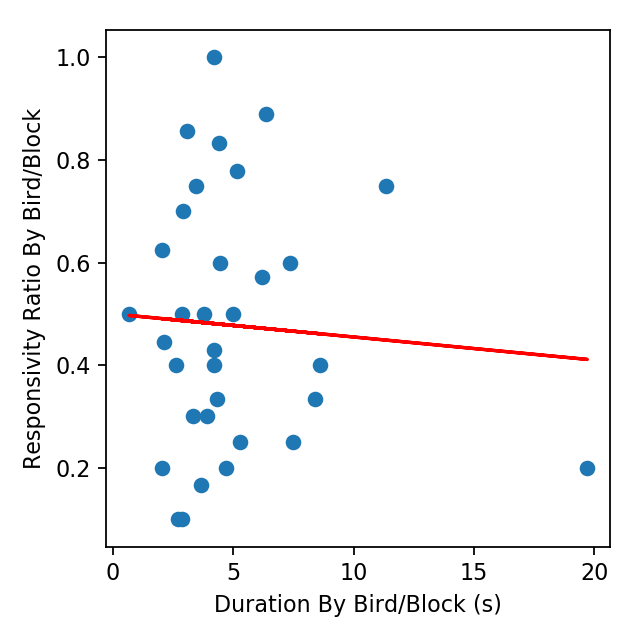

(-0.06365021375697112, 0.7249123501169268)
-0.06365021375697112 0.7249123501169268


In [368]:
## Are duration and responsiveness correlated (by bird by block)

#print(latency_list,resp_list)
#print(len(latency_list),len(resp_list))
fig,ax = plt.subplots()
ax.scatter(duration_list,resp_list)
#ax2.scatter(duration_list,resp_list)

print(pearsonr(duration_list,resp_list))

for f in range(7):
    pass
    #ax.scatter(bird_block_durations[f],bird_block_responses[f])

xs = [0] * 11
ys = [0] * 11

"""
for b in range(11):
    ax.scatter(block_bird_durations[b],block_bird_responses[b])
    ax2.scatter(np.nanmean(block_bird_durations[b]),np.nanmean(block_bird_responses[b]),s=200)
    xs[b] = np.nanmean(block_bird_durations[b])
    ys[b] = np.nanmean(block_bird_responses[b])
#ax2.scatter(bird_means[:,2],bird_means[:,0],s=200)
#ax2.scatter(block_means[:,2],block_means[:,0],s=200,alpha=.7) 

"""
slope,intercept = np.polyfit(duration_list,resp_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(duration_list,fit_line(duration_list),color='red')

ax.set_xlabel('Duration By Bird/Block (s)')
ax.set_ylabel('Responsivity Ratio By Bird/Block')

corr,p_value = pearsonr(duration_list,resp_list)

print(corr,p_value)

#print(pearsonr(bird_means[:,2][~np.isnan(bird_means[:,2])],bird_means[:,0][~np.isnan(bird_means[:,2])]))
#print(pearsonr(block_means[:,2],block_means[:,0]))
#

fig.set_size_inches(4,4)
fig.tight_layout()
fig.show()

(121,) (121,)


<IPython.core.display.Javascript object>


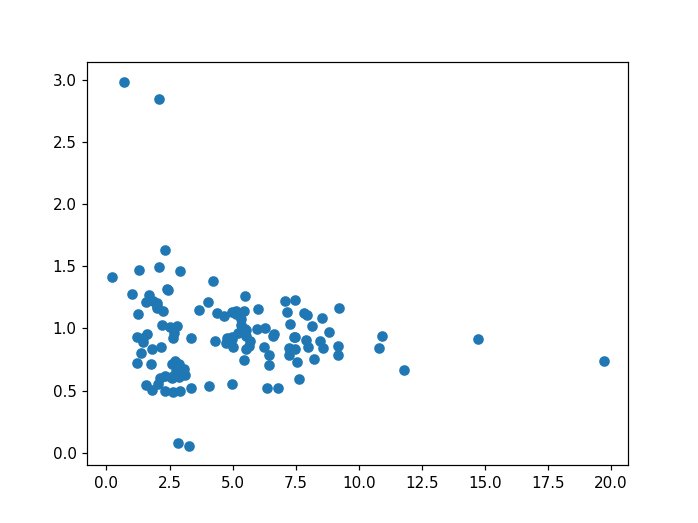

(-0.1382278677876835, 0.13053597374565487)


In [228]:
# Are duration and latency correlated (by posture)

print(np.shape(good_durations),np.shape(good_latencies))

fig,ax = plt.subplots()

ax.scatter(good_durations,good_latencies)
print(pearsonr(good_durations,good_latencies))

[0 2 8 1 7 4 5 9 3 6]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


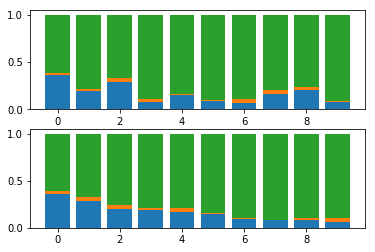

In [70]:
## split apart ranking into postures, partials, and non-postures

mean_partials3 = np.mean(bv3_array[:,:,:,0] == .5,axis=(1,0))
mean_non3 = np.mean(bv3_array[:,:,:,0] == 0,axis=(1,0))
mean_posture3 = np.mean(bv3_array[:,:,:,0] == 1,axis=(1,0))

fig,(ax1,ax2) = plt.subplots(2)

song_order3 = np.argsort(mean_posture3)[::-1]
print(song_order3)


ax1.bar(range(10),mean_posture3)
ax1.bar(range(10),mean_partials3,bottom = mean_posture3)
ax1.bar(range(10),mean_non3,bottom = (mean_posture3 + mean_partials3))

ax2.bar(range(10),mean_posture3[song_order3])
ax2.bar(range(10),mean_partials3[song_order3],bottom = mean_posture3[song_order3])
ax2.bar(range(10),mean_non3[song_order3],bottom = (mean_posture3 + mean_partials3)[song_order3])
fig.show()

      1    13   22   30   47   55   67   79   83   96   101
BK24  1.0  1.0  0.5  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
WH19  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0
WH16  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
WH24  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0
BK21  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
LB20  1.0  1.0  1.0  0.0  0.5  0.0  0.0  1.0  1.0  0.0  1.0
BK17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
GR13  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0
WH22  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
[22.5 16.  23.   8.  16.   9.   4.5 14.5 18.5  9. ]
[52.  24.  38.  10.5 14.5 10.  12.5 22.5 25.   7.5]
[[0.5 1.  0.5 1.  1.  1.  0.  0.  0.  0.  0. ]
 [1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1. ]
 [1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1. ]
 [1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  1.  1.  0.  0.5 0.  0.  1.  1.  0.  1. ]
 [0.  0.  0.  

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


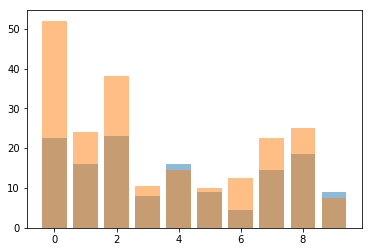

In [25]:
song_name = 'BDY.wav'
print(np.transpose(group2_df.loc[group1_df['SongFile'] == song_name].iloc[:,6:15]))

print(np.sum(bv3_array[:9,:,:,0],axis = (1,0)))
print(np.sum(bv3_array[9:,:,:,0],axis = (1,0)))

print(bv3_array[9:,:,0,0])

print(song_list)

fig, ax = plt.subplots()
ax.bar(range(10),np.sum(bv3_array[:9,:,:,0],axis = (1,0)),alpha=.5)
ax.bar(range(10),np.sum(bv3_array[9:,:,:,0],axis = (1,0)),alpha=.5)

fig.show()

<IPython.core.display.Javascript object>


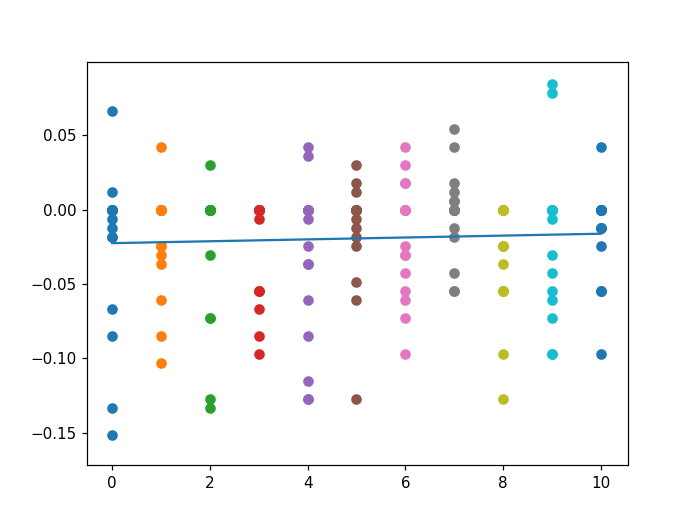

Pearsons r: 0.049
p: 0.4898087954822813


In [385]:
## Plot the emergence (or divergence...or neither) of selectivity over time

n_blocks = 11
n_birds = 18
binary_array3 = np.array(bv3_array)
binary_array3[binary_array3 == .5] = 0



resp_list = []
slope_array = np.empty([n_blocks,n_birds])
slope_array.fill(np.nan)
for f in range(n_birds):
    for b in range(n_blocks):
        block_n = binary_array3[f,b,:,0]
        
        #block_n = block_n[true_order]

        #mean_response = true_means[f,:]
    
        #mean_response = mean_response[~np.isnan(block_n)]
        #block_n = block_n[~np.isnan(block_n)]
        
        responsivity = np.nanmean(block_n)
        resp_list.append(responsivity)

        if np.nansum(block_n) < 1:
            pass
            #continue
        if len(block_n[~np.isnan(block_n)]) < 3:
            continue
        #print(block_n)
        
        trimmed_block = block_n[~np.isnan(block_n)]
        
        trimmed_xs = np.arange(len(block_n))[~np.isnan(block_n)]
        slope,_ = np.polyfit(trimmed_xs,trimmed_block,1)
        #print(slope)

        slope_array[b,f] = slope

fig,ax = plt.subplots()

xpoint_list = []
ypoint_list = []
ypoints_byblock = []

for n in range(11):
    #ax.scatter([n]*n_birds,slope_array[n,:])
    good_points = slope_array[n,:][~np.isnan(slope_array[n,:])]
    #good_points = np.clip(good_points,-.1,.1)
    #print(good_points)
    good_xs = [n] * len(good_points)
    ypoint_list.extend(good_points)
    xpoint_list.extend(good_xs)
    #print(n,good_points)
    ypoints_byblock.append(good_points)
    ax.scatter(good_xs,good_points)
#print(ypoints_byblock)
corr,p_value = pearsonr(xpoint_list,ypoint_list)

slope,intercept = np.polyfit(xpoint_list,ypoint_list,1)
fit_line = np.poly1d([slope,intercept])
ax.plot(fit_line(np.arange(n_blocks)))
#ax.boxplot(ypoints_byblock,positions=np.arange(len(ypoints_byblock)),notch=True,bootstrap=5000)
#print(slope,intercept)
#ax.set_ylim([-0.1,0.1])
fig.show()
print('Pearsons r: %.3f' % corr)
print('p:',p_value)


#fig.savefig('/home/ammon/Desktop/ToCompy/true_selectivity_by_block.svg')

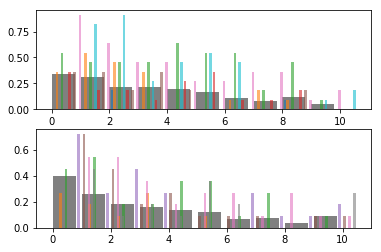

In [510]:
## finally Look at lesions vs non-lesions
lesions1,lesions2 = ([1,2,3,7,8],[9,11,13,15,17])
non_lesions1,non_lesions2 = ([0,3,5,6],[10,12,14,16])

lesions = [1,2,4,7,8,9,11,13,15,17]
non_lesions = [0,3,5,6,10,12,14,16]

fig,(ax1,ax2) = plt.subplots(2)


ax1.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means[lesions],axis=0),color='gray')
ax2.bar(np.arange(n_songs) + .4,np.nanmean(sorted_means[non_lesions],axis=0),color='gray')

for n in range(n_birds):
    #print(np.shape(canon_means),np.shape(bird_list))
    #ax.bar(np.arange(n_songs) + n * .8/n_birds,canon_means[n],width=.8/n_birds, label=bird_list3[n],alpha=.6)
    if n in lesions:
        ax1.bar(np.arange(n_songs) + n * .8/9,sorted_means[n],width=.8/9,alpha=.6)
    elif n in non_lesions:
        ax2.bar(np.arange(n_songs) + n * .8/9,sorted_means[n],width=.8/9,alpha=.6)

In [20]:
## Make a PCA out of response data for seq with postures. Easy peasy. 
good_list = sorted(os.listdir('./SeqClasses/'))
crap_list = sorted(os.listdir('./CrapSeqs/'))


#file_list = sorted(os.listdir('./SeqClasses/'))
file_lists = [good_list,crap_list]
dir_list = ['./SeqClasses/','./CrapSeqs/']
for f in range(1):
    file_list = file_lists[f]
    seq_dir = dir_list[f]
    for s in range(len(file_list)):

        seq_file = file_list[s]
        seq = pickle.load(open(seq_dir + seq_file,'rb'))

        if seq.offset == 0:
            continue

        if s == 0:
            seq_distances,_ = seq.define_distances()
            all_distances = seq_distances[seq.response_range,:]
            seq_points = np.reshape(seq.smooth_data,[len(seq.smooth_data),60])
        else:
            seq_distances,_ = seq.define_distances()
            all_distances = np.vstack([all_distances,seq_distances[seq.response_range]])
            seq_points = np.vstack([seq_points,np.reshape(seq.smooth_data,[len(seq.smooth_data),60])])

print(np.shape(all_distances))
print(np.shape(seq_points))

(78317, 190)
(350946, 60)


In [736]:
print(np.shape(np.reshape(seq.smooth_data,[len(seq.smooth_data),60])))
print(np.shape(seq_distances))

(937, 60)
(937, 190)


In [22]:
import math

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

condensed_to_square(135,20)

(9, 10)

[0.44 0.18 0.17 0.12 0.03 0.02 0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]


<IPython.core.display.Javascript object>


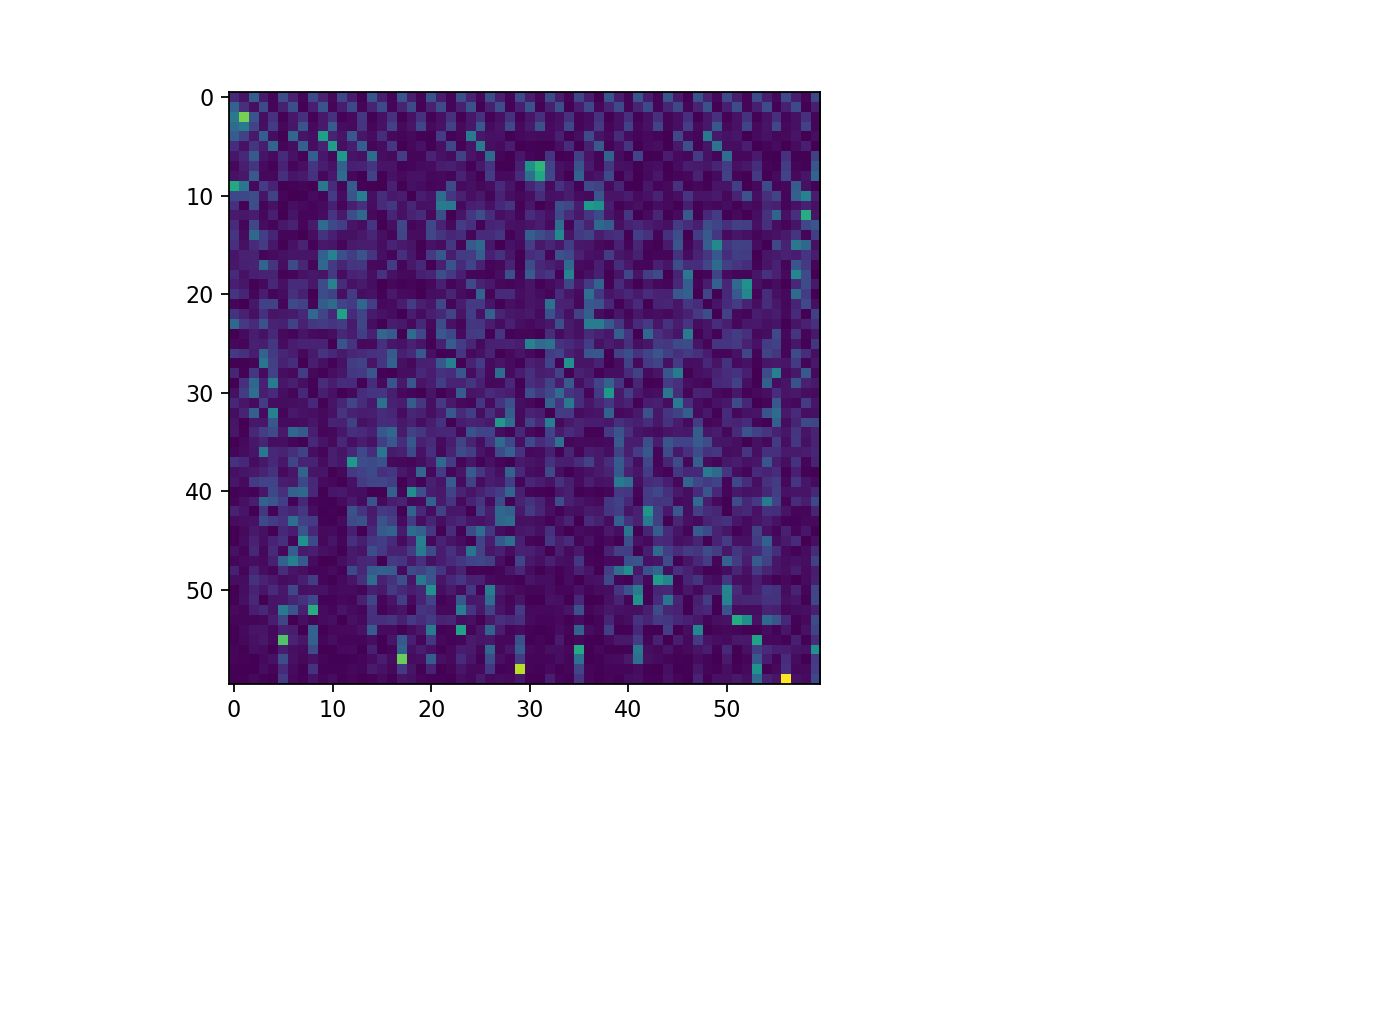

In [25]:
## Perform PCA on the points themselves. This is fine, but the first 3 are just the avg xyz :/
# Definitely needs to be normalized
from sklearn.decomposition import PCA
pca_points = PCA()
pca_points.fit(seq_points)

print(np.round(pca_points.explained_variance_ratio_,2))
fig,ax = plt.subplots()
ax.imshow(np.abs(pca_points.components_))

fig.show()

In [533]:
count = 0

p_array_components = np.empty([len(file_list),190])
p_array_components.fill(np.nan)
for s in range(len(file_list)):
    seq_file = file_list[s]
    #print(seq_dir,seq_file)
    seq = pickle.load(open(seq_dir + seq_file,'rb'))
    if seq.offset != 0 and seq.posture == 1:
        count += 1
        seq_distances,_ = seq.define_distances()
        reduced_path = pca.transform(seq_distances)

        baseline = reduced_path[(seq.ts < 0) & (seq.ts > -2)]
        csd_window = reduced_path[(seq.ts > 0) & (seq.ts < seq.t_refraction)]        
        
        for c in range(190):

            t,p = ttest_ind(baseline[:,c],csd_window[:,c])
            ax.scatter(c,np.log(1/p))
            p_array_components[count,c] = np.log(1/p)

            if p < .05:
                #print(c,p)
                pass
        if count > 50:
            pass
            
print(count)
good_stuff = p_array_components[~np.isnan(p_array_components[:,0])]
average_values = np.mean(good_stuff,0) / np.max(np.mean(good_stuff,0))

#print(seq.offset,seq.seq_name,seq.posture)

146


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


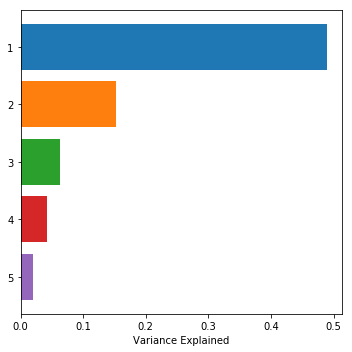

In [768]:
## Run the PCA, plot the relative explained variance and significance (baseline vs response)
%matplotlib inline

from sklearn.decomposition import PCA
from matplotlib import cm

viridis = cm.get_cmap('viridis', 50)

pca = PCA()

pca.fit(all_distances)

#print(np.round(pca.explained_variance_ratio_,2))
#print(np.max(normed_sig))
#print(normed_sig[1],normed_colors[1])

fig,ax = plt.subplots()
#ax.imshow(np.abs(pca.components_[:3]),aspect='auto')
#ax.pie(pca.explained_variance_ratio_,startangle=90,counterclock=False)
#fig.set_size_inches(3,3)

#normed_sig = p_array_components / np.max(p_array_components)
#normed_sig = np.clip(normed_sig,0,.7)
normed_colors = viridis(average_values)

alpha = np.log(190/.05) / np.max(np.mean(good_stuff,0))

floored_values = np.array(average_values)
#floored_values[floored_values < alpha] = 0
normed_colors = viridis(floored_values)



k = np.log(190/.05) / np.max(np.mean(good_stuff,0))
r = k
"""
ax.pie(pca.explained_variance_ratio_,startangle=90,counterclock=False,colors=normed_colors)
ax.pie(pca.explained_variance_ratio_, colors=[[0,0,0]] * len(average_values),  
        startangle=90, counterclock=False, explode=average_values * .5,
        radius = .1)
"""
#circle1 = plt.Circle((0, 0), .1 + r, color='r',fill=False)
#ax.add_artist(circle1)

#ax2.imshow(np.abs(pca.components_[:7]),aspect='auto')

#ax.hist(normed_sig)
#ax.axvline(np.log(190/.05) / np.max(p_array_components),color='red')

bar_colors = [color_cycle[4-i] for i in range(5)]
ax.barh(range(5),pca.explained_variance_ratio_[:5][::-1],color=bar_colors)
ax.set_yticklabels(np.arange(1,7)[::-1])
ax.set_xlabel('Variance Explained')


fig.set_size_inches(5,5)
fig.tight_layout()
fig.show()
fig.savefig('/home/ammon/Desktop/PaperFigs/4a.png')
fig.savefig('/home/ammon/Desktop/PaperFigs/4a.svg')

In [757]:
print(condensed_to_square(19,20))
print(np.unravel_index(20,[20,20]))

(1, 2)
(1, 0)


In [758]:
### All 190 sig means that every distance changes significantly. Duh
### Top 10 being important means that all the movement isn't perfectly correlated
from itertools import combinations

# I could plot this as the connection with the width as the weight, make it slightly transparent. 
# That would emphasize where the components are focusing. 
# But the size is going to depend not only on importance but initial distance
# Do really trust this I would need to normalize them by their average distance...Ugh. 
# But I'll I'm doing here is getting intuition. Does this work for that? 
# Not necessarily. Size and importance aren't equivalent. However since all the distances are on average 
# ...quite similar, and also the beak distances would be the longest, so those being biggest means extra.

points_dict = {
    0:'Beak',
    1:'Keel',
    2:'Tailbone',
    3:'Tail Tip',
    4:'Left Eye',
    5:'Left Shoulder',
    6:'Left Elbow',
    7:'Left Wrist',
    8:'Left Wing Tip',
    9:'Left Knee',
    10:'Left Ankle',
    11:'Left Heel',
    12:'Right Eye',
    13:'Right Shoulder',
    14:'Right Elbow',
    15:'Right Wirst',
    16:'Right Wing Tip',
    17:'Right Knee',
    18:'Right Ankle',
    19:'Right Heel'
}

import math

## Nabbed from stack exchange

def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))/2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return int(i), int(j)

for n in range(5):
    print('***component:',n)
    top_20 = np.argsort(pca.components_[n])[::-1][:20]
    indices = np.unravel_index(top_20,[20,20])
    more_indices = np.empty([20,2])
    for i in range(len(top_20)):
        more_indices[i] = condensed_to_square(top_20[i],20)
        #print(more_indices[i],np.unravel_index(top_20[i],[20,20]))
    list_test = list(zip(indices[0],indices[1]))
    list_2 = list(zip(more_indices[:,0],more_indices[:,1]))
    for p in range(len(list_test)):
        pair = list_test[p]
        pair2 = list_2[p]
        #print(points_dict[pair[0]],'->',points_dict[pair[1]])
        print(points_dict[pair2[0]],'->',points_dict[pair2[1]])
    print('\n')

***component: 0
Beak -> Tail Tip
Beak -> Left Wing Tip
Beak -> Right Wing Tip
Beak -> Tailbone
Tail Tip -> Left Eye
Tail Tip -> Right Eye
Beak -> Right Heel
Beak -> Left Heel
Beak -> Right Ankle
Beak -> Left Ankle
Tail Tip -> Right Wirst
Keel -> Tail Tip
Tail Tip -> Right Shoulder
Tail Tip -> Left Wrist
Left Eye -> Left Wing Tip
Tail Tip -> Left Shoulder
Left Wing Tip -> Right Eye
Right Eye -> Right Wing Tip
Left Eye -> Right Wing Tip
Beak -> Left Knee


***component: 1
Beak -> Left Eye
Beak -> Right Eye
Beak -> Left Shoulder
Beak -> Right Shoulder
Beak -> Right Wirst
Beak -> Left Elbow
Beak -> Left Wrist
Beak -> Right Elbow
Beak -> Keel
Beak -> Right Knee
Beak -> Left Knee
Beak -> Right Ankle
Beak -> Left Ankle
Beak -> Left Heel
Beak -> Right Heel
Beak -> Tailbone
Beak -> Left Wing Tip
Beak -> Right Wing Tip
Beak -> Tail Tip
Keel -> Right Wirst


***component: 2
Tail Tip -> Right Heel
Tail Tip -> Left Heel
Right Wing Tip -> Right Heel
Tail Tip -> Right Ankle
Tail Tip -> Left Ankle
Lef

(909, 190)
(100, 190)
(441, 190)
t-stat: 10.108769146669248 p= 4.086547506478213e-22


<IPython.core.display.Javascript object>


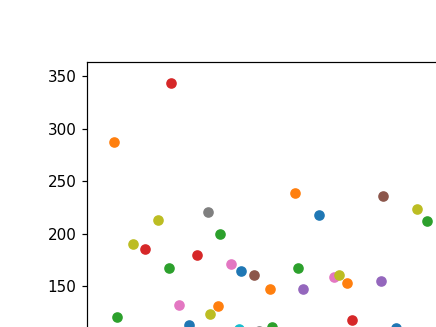

In [64]:
print(np.shape(seq_distances))
baseline = reduced_path[(seq.ts < 0) & (seq.ts > -2)]
csd_window = reduced_path[(seq.ts > 0) & (seq.ts < seq.t_refraction)]
print(np.shape(baseline))
print(np.shape(csd_window))

t,p = ttest_ind(baseline[:,0],csd_window[:,0])
print('t-stat:',t,'p=',p)

fig,ax = plt.subplots()
"""
for n in range(10):
    ax.plot(baseline[:,n],color='blue',alpha=1-n*.1)
    ax.plot(np.arange(len(csd_window)) + len(baseline),csd_window[:,n],color='orange',alpha=1-n*.1)
"""    
p_array_components = np.empty(190)
for c in range(190):
    t,p = ttest_ind(baseline[:,c],csd_window[:,c])
    ax.scatter(c,np.log(1/p))
    p_array_components[c] = np.log(1/p)
    
    if p < .05:
        #print(c,p)
        pass


(946, 190)
(946, 190)
(947,)
2019-07-15-11-42-46_WG
0
birdview-2


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


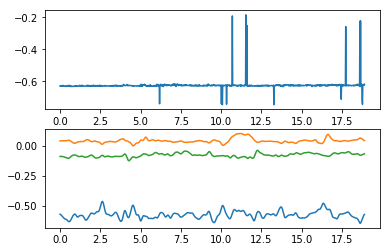

In [532]:
#principalComponents = pca.transform(all_distances)
print(np.shape(seq_distances))

seq_distances,_ = seq.define_distances()

reduced_path = pca.transform(seq_distances)
print(np.shape(reduced_path))
print(np.shape(seq.ts))

fig,(ax1,ax2) = plt.subplots(2)
ax2.plot(seq.ts[:-1],reduced_path[:,0]) 
ax2.plot(seq.ts[:-1],reduced_path[:,1])
ax2.plot(seq.ts[:-1],reduced_path[:,2])
ax1.plot(seq.ts[:-1],seq.rough_data[:,3,2] * 10 - 3)
#ax.axvline(np.argmin(seq.ts >= 0))

print(seq.seq_name)
print(seq.offset)
print(seq.machine)


fig.show()

breaking at 118


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


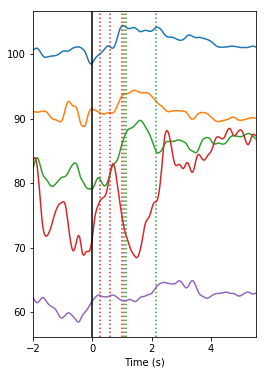

In [771]:
### Read through all the postures
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline

#fig,(ax1,ax2) = plt.subplots(2)
fig,ax2 = plt.subplots()
count = 0
break_point = 118

n_comp = 5

transitions = np.zeros([n_comp * 3 + 2,n_comp * 3 + 2])
all_time_points = np.empty((break_point+1,n_comp,3))
all_time_points.fill(np.nan)
for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.offset == 0 or seq.posture != 1:
        continue
    if 'floor' in seq.notes:
        continue

    ## If it's a posture, grab it, stop at a good one

    ## convert into PCA space
    seq_distances,_ = seq.define_distances()
    reduced_path = pca.transform(seq_distances)
    smooth_path = gaussian_filter1d(reduced_path,10,0)

    ## Get mean, std of baseline
    reduced_baseline = reduced_path[seq.t_baseline_index[0][0]:seq.tzero_index[0][0]]
    reduced_means = np.mean(reduced_baseline,0)
    reduced_std = np.std(reduced_baseline,0)

    z_signs = np.ones(190)
    z_path = (reduced_path - reduced_means) / reduced_std

    for c in range(190):
        z_signs[c] = np.sign(z_path[seq.response_range,c][np.abs(z_path[seq.response_range,c]) == np.max(np.abs(z_path[seq.response_range,c]))])


    z_path = z_path * z_signs
    z_smooth = gaussian_filter1d(z_path,10,0)
    """
    ax.plot(seq.ts,seq.rough_data[:,3,2],color='red',linestyle=':')
    ax.axvline(0)
    ax.plot(seq.ts,reduced_path[:,0])
    ax.plot(seq.ts,smooth_path[:,0])
    """
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    time_points = np.empty([n_comp,3])
    time_points.fill(np.nan)
    for c in range(n_comp):

        #ax2.plot(seq.ts,z_smooth[:,c] + 100 - c * 10,color=color_cycle[c],linestyle=':')
        z0,zmax,z1 = np.nan,np.nan,np.nan
        ## Get 1st deviation from baseline
        z0_index = np.argmax(np.abs(z_path[seq.response_range,c]) > 7)
        if z0_index != 0:
            z0 = seq.response_ts[z0_index]
            time_points[c,0] = z0
        ## Get 1st aproximation of peak (must be beyond baseline)
        zmax_index = np.argmax((z_path[seq.response_range,c] > 7) & (z_path[seq.response_range,c] >= np.max(z_path[seq.response_range,c]) - 2)) 
        if zmax_index != 0:
            zmax = seq.response_ts[zmax_index]
            time_points[c,1] = zmax
        # Get 1st return to baseline
            z1_index = np.argmax((z_path[seq.response_range,c] <5) & (seq.response_ts >= zmax))
            if z1_index != 0:
                z1 = seq.response_ts[z1_index]
                time_points[c,2] = z1

        if count == break_point:
            ax2.plot(seq.ts,z_path[:,c] + 100 - c * 10)
            ax2.axvline(z0,linestyle=':',color=color_cycle[c])
            ax2.axvline(zmax,linestyle=':',color=color_cycle[c])
            ax2.axvline(z1,linestyle=':',color=color_cycle[c])

    all_time_points[count] = time_points
    time_vector = np.reshape(time_points,[n_comp * 3])
    #print(time_vector)
    sorted_vector = np.argsort(time_vector)
    sorted_vector = sorted_vector[~np.isnan(time_vector[sorted_vector])]
    #print(np.round(time_vector,2),sorted_vector)
    
    if len(sorted_vector) > 0:
        a = sorted_vector[0] + 1
        transitions[0,a] += 1
        for p in range(len(sorted_vector) - 1):
            a = sorted_vector[p]
            b = sorted_vector[p+1]
            if np.isnan(time_vector[a]) or np.isnan(time_vector[b]):
                continue
            elif time_vector[a] == time_vector[b]:
                #print('this does not count')
                continue
            else:
                transitions[a+1,b+1] += 1  
        
        #z = sorted_vector[~np.isnan(time_vector[sorted_vector])][-1]:
        z = sorted_vector[-1]
        transitions[z+1,-1] += 1
    if count == break_point:
        print('breaking at',count)
        break
    count += 1

#print(transitions)
ax2.axvline(0,color='black')
ax2.set_xlim([-2,seq.duration])
ax2.set_xlabel('Time (s)')
#ax.set_xlim([-2,seq.duration])

#ax1.imshow(transitions)
fig.set_size_inches(4,6)
fig.show()
## Replot with z scores
## For the top 6 or so, grab start, peak, stop (this could be iffy)
## Plot each component, offset so you can see them all together
## Order everything to see the order

## -> I could be doing the PCA by just the height...Does that make sense? It's certainly worth a try...
## It's probably worth a try.

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


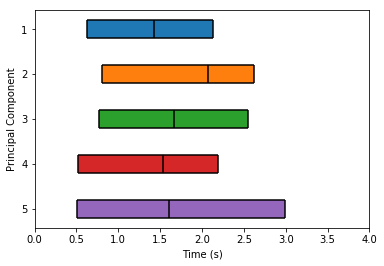

In [772]:
median_times = np.nanmedian(all_time_points,0)

fig,ax = plt.subplots()

for i in range(n_comp):
    n = n_comp - i - 1
    ax.vlines(median_times[n],n-.2,n+.2)
    ax.hlines([n-.2,n+.2],median_times[n,0],median_times[n,2])
    ax.fill_between([median_times[n,0],median_times[n,2]],n+.2,n-.2)
    
ax.set_yticklabels(np.arange(1,n_comp+2)[::-1])
ax.set_ylabel('Principal Component')
#ax.set_yticklabels(np.arange(n_comp)[::-1])
ax.set_xlabel('Time (s)')
ax.set_xlim([0,4])
fig.show()

[ 0  1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18 19]
[115. 114. 115. 108. 110. 108.  96.  92.  85.  71.  64.  56.  37.  35.
  23.  16.   9.   3.   0.   0.]
[ 0  1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18 19] [ 1  4 13  7 16 10 14  5  2 17  8 11 15  6  9 12  3 18]


/home/ammon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


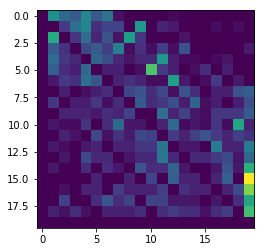

In [712]:
fig,ax = plt.subplots()

med_order = np.argsort(np.reshape(np.nanmedian(all_time_points,0),[n_comp * 3]))
med_order = np.hstack([0,med_order + 1,n_comp * 3 + 1])
print(med_order)
"""max_transitions = np.argmax(transitions,axis=0)
print(max_transitions)"""

print(row_sums)
row_sums = np.nansum(transitions,axis=1)
normed_transitions = transitions / row_sums[:,np.newaxis]


reordered_transitions = np.zeros_like(normed_transitions)

reordered_transitions[0] = normed_transitions[0,med_order]
print(med_order,med_order[1:-1])
for n in range(1,len(med_order)-1):
    i = med_order[n]
    reordered_transitions[n] = normed_transitions[i,med_order]
#normed_transitions = np.norm(transitions,axis=1)
#ax.imshow(normed_transitions[med_order,med_order])
ax.imshow(reordered_transitions)
fig.show()

running: 2019-05-23-11-06-05_2M
running: 2019-05-29-17-07-51_BDY
running: 2019-05-30-07-07-56_GRG
running: 2019-05-30-08-34-17_BOD
running: 2019-05-30-10-02-55_BDY
running: 2019-05-30-11-32-53_LNR
running: 2019-05-30-13-04-19_ND
running: 2019-05-30-15-33-06_2M
running: 2019-05-30-17-09-37_LB
running: 2019-05-30-18-36-04_DMG
running: 2019-05-31-07-05-58_GRG
running: 2019-05-31-10-06-46_WG
running: 2019-05-31-11-33-45_GRG
running: 2019-05-31-13-02-51_ND
running: 2019-05-31-17-02-53_BDY
running: 2019-06-02-10-03-52_2M
running: 2019-06-03-10-03-27_LB
running: 2019-06-04-07-03-23_WG
running: 2019-06-04-10-04-03_2M
running: 2019-06-04-11-33-03_LB
running: 2019-06-04-13-05-42_WG
running: 2019-06-04-15-32-56_LNR
running: 2019-06-04-18-42-42_ND
running: 2019-06-05-07-02-51_BDY
running: 2019-06-06-07-03-02_BDY
running: 2019-06-06-10-03-31_LB


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


skipping 2019-06-09-13-16-11_BDY : no timing data
skipping 2019-06-10-07-16-13_ND : no timing data
running: 2019-06-10-08-29-51_WG
skipping 2019-06-10-08-46-13_2M : no timing data
skipping 2019-06-10-11-46-12_ND : no timing data
running: 2019-06-11-07-02-55_2M
running: 2019-06-11-08-33-22_WG
running: 2019-06-11-10-05-01_BDY
skipping 2019-06-11-11-46-11_ND : no timing data
running: 2019-06-11-13-02-53_GRG
running: 2019-06-11-17-12-41_2M
skipping 2019-06-12-11-46-13_LNR : no timing data
skipping 2019-06-12-13-16-14_BDY : no timing data
skipping 2019-06-13-07-16-15_BDY : no timing data
running: 2019-06-13-08-42-47_GRG
running: 2019-06-13-15-32-53_LB
running: 2019-06-13-18-39-57_BDY
skipping 2019-06-14-15-46-14_BDY : no timing data
running: 2019-06-15-10-02-54_LNR
running: 2019-06-15-13-03-41_BOD
running: 2019-06-15-17-09-07_DMG
skipping 2019-06-17-17-16-13_BDY : no timing data
skipping 2019-06-17-18-46-14_LNR : no timing data
running: 2019-06-18-07-03-28_LNR
skipping 2019-06-18-07-16-14_N

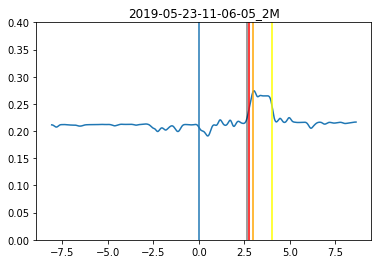

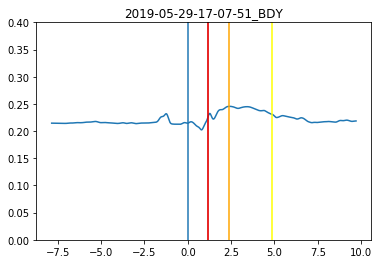

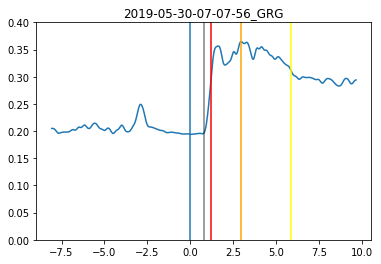

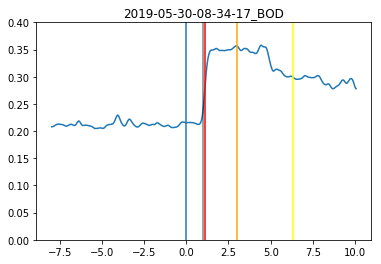

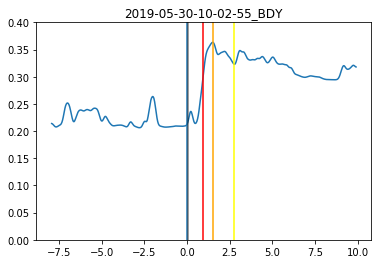

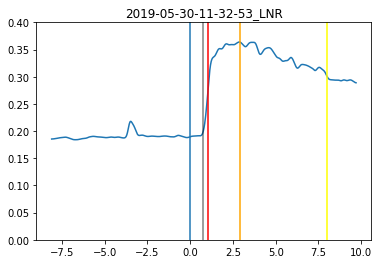

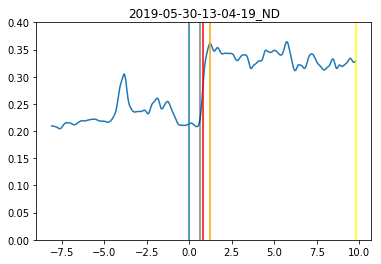

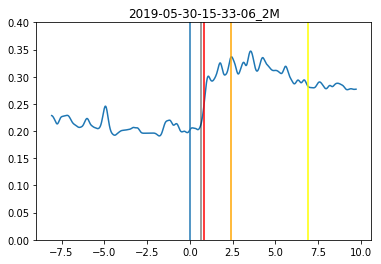

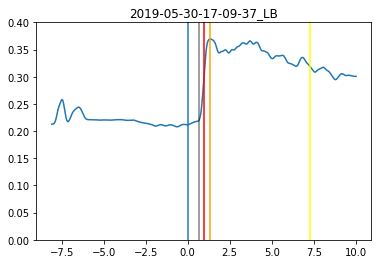

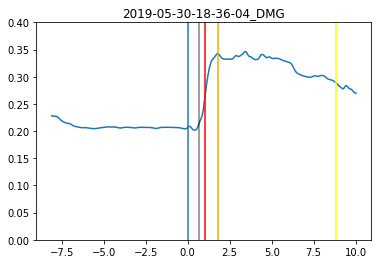

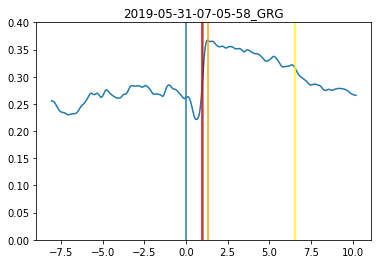

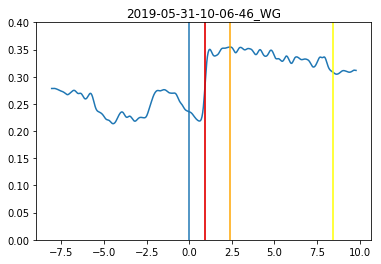

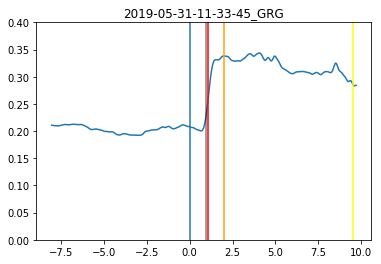

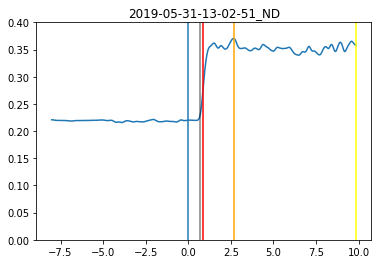

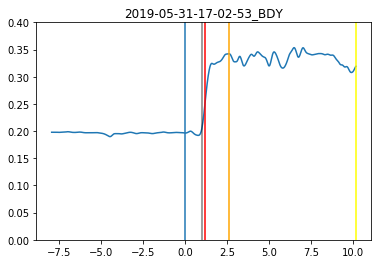

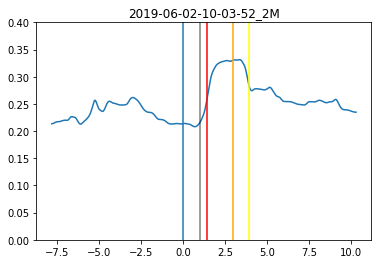

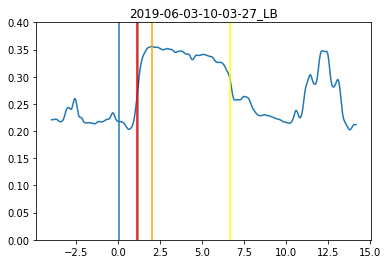

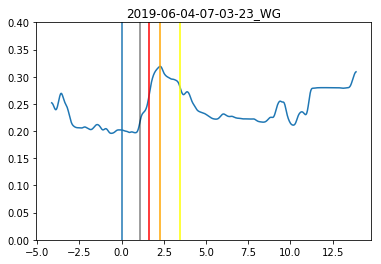

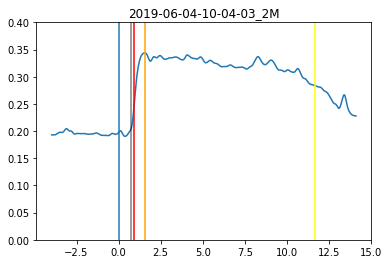

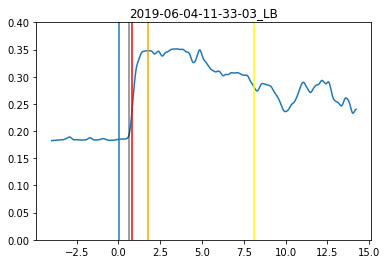

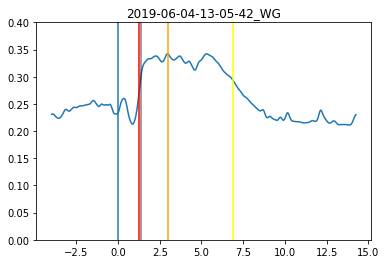

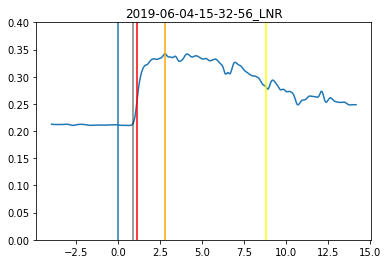

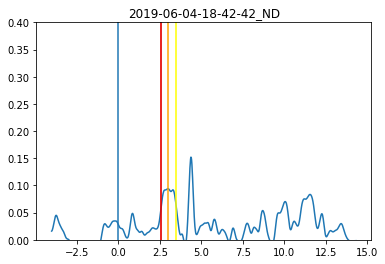

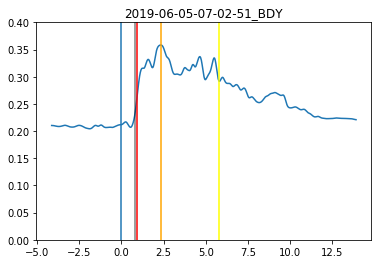

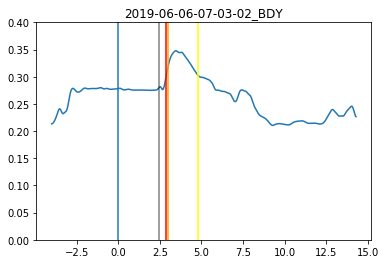

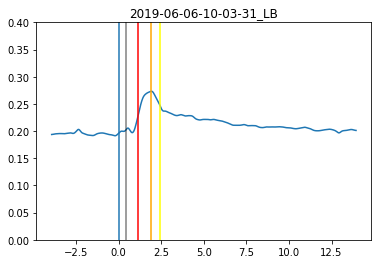

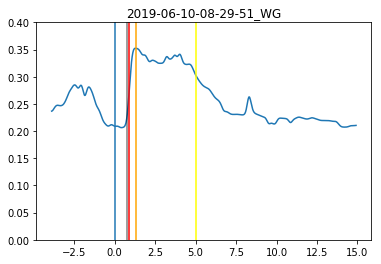

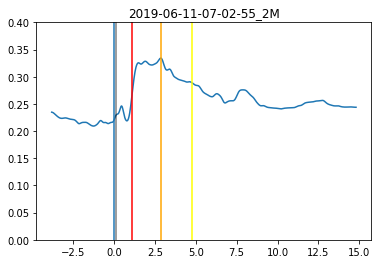

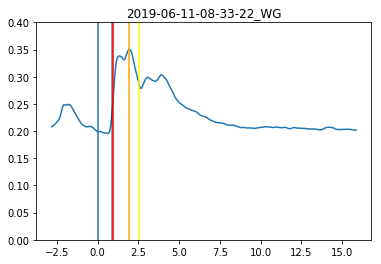

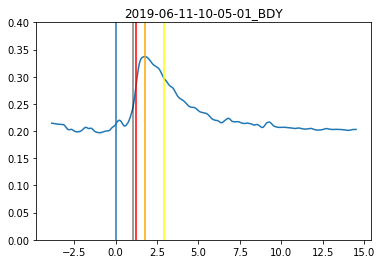

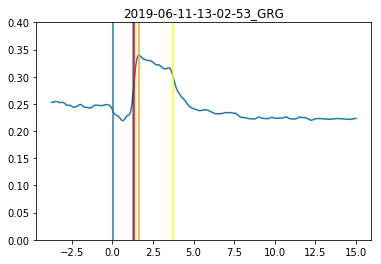

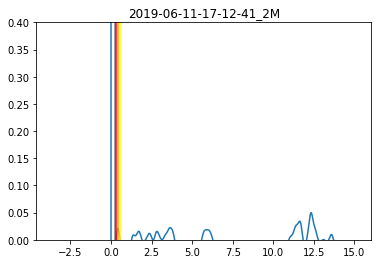

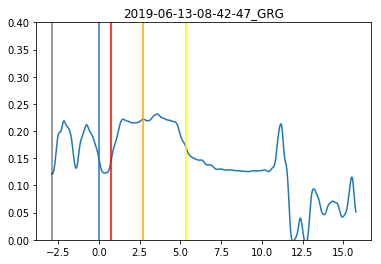

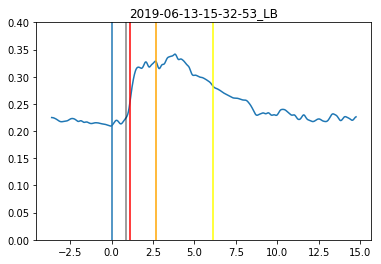

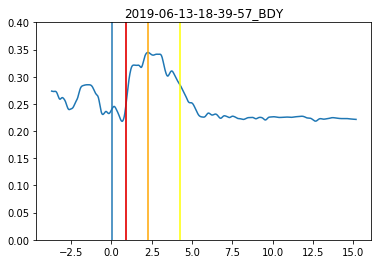

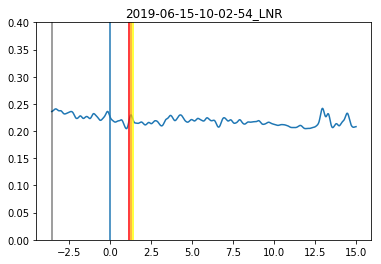

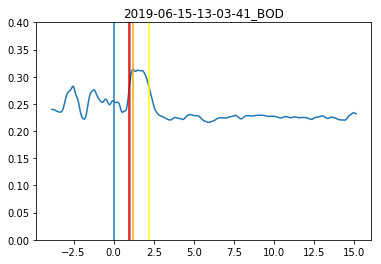

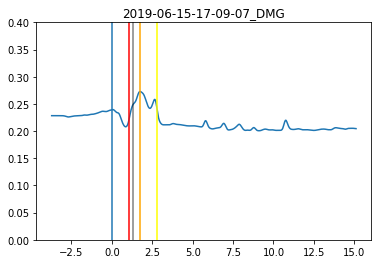

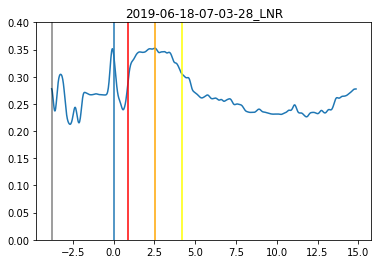

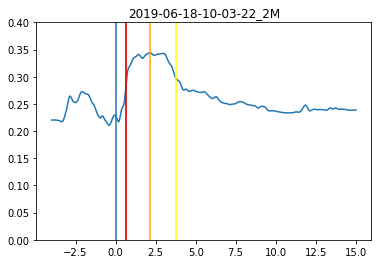

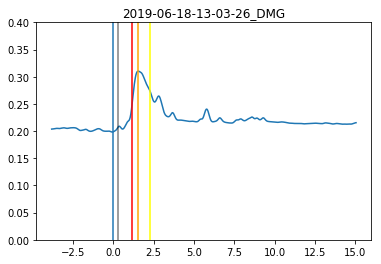

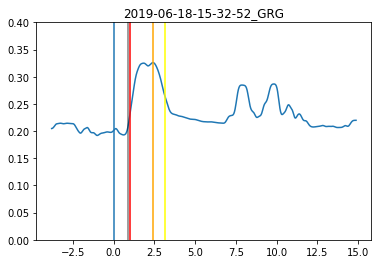

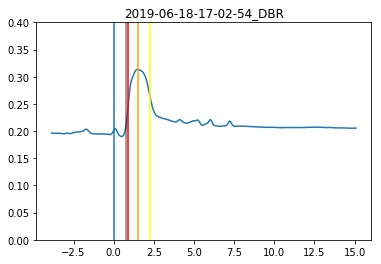

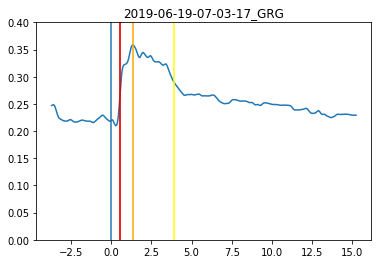

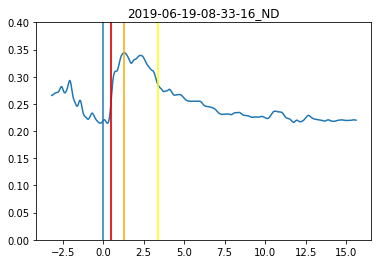

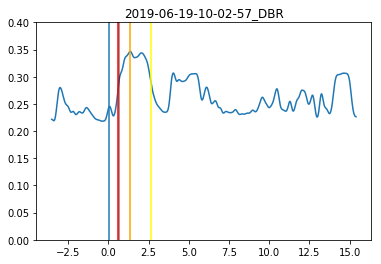

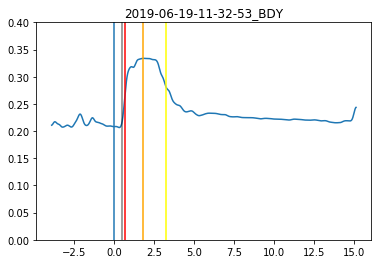

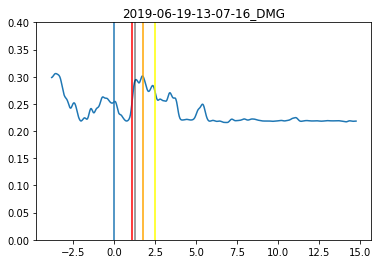

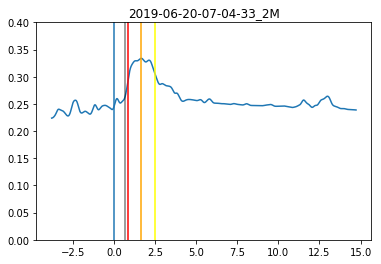

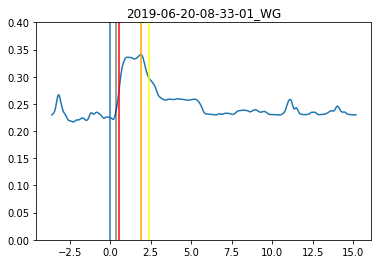

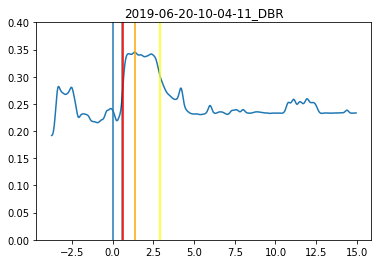

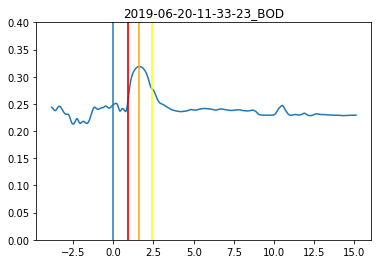

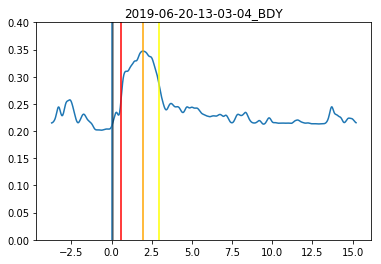

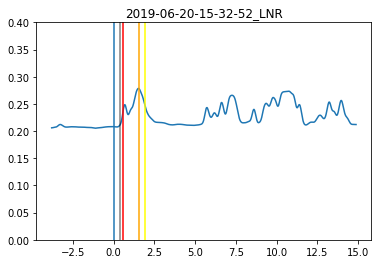

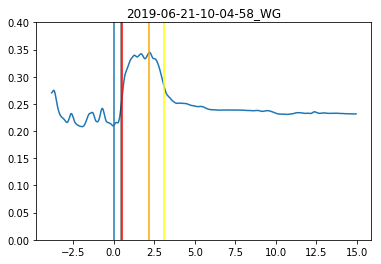

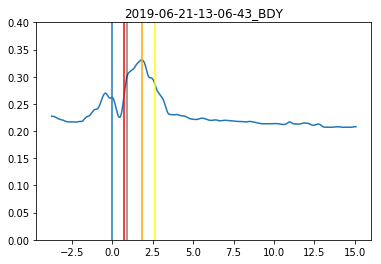

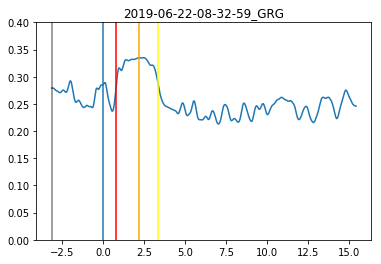

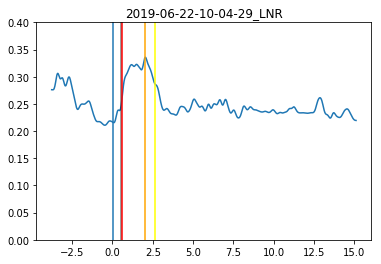

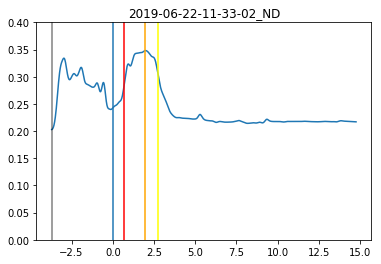

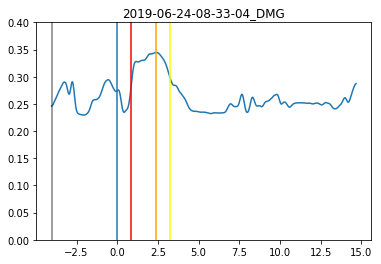

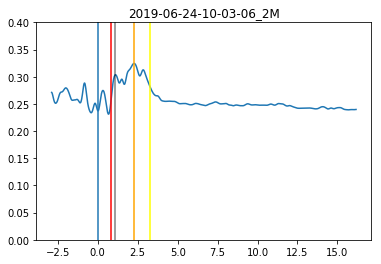

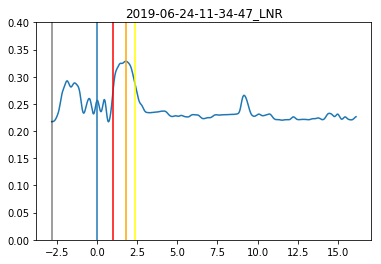

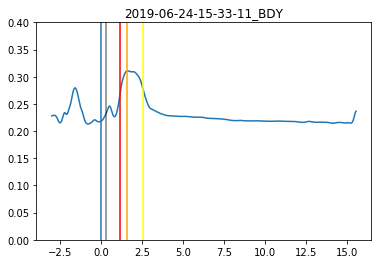

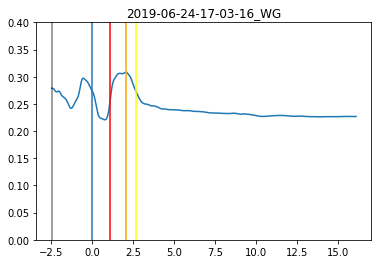

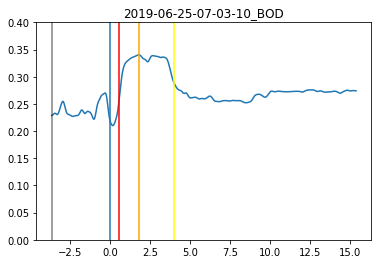

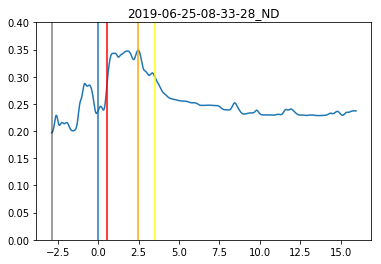

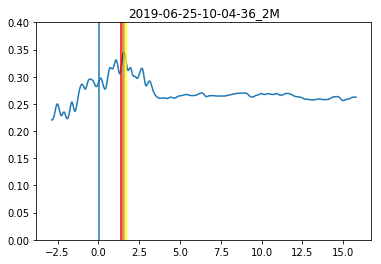

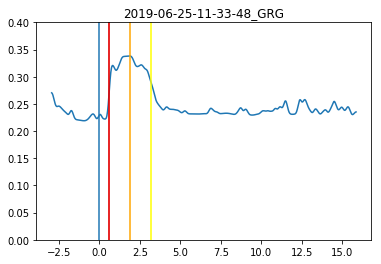

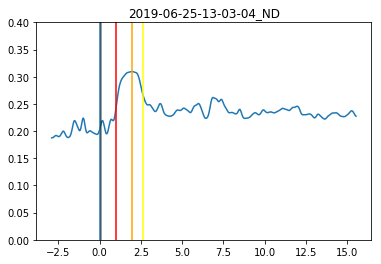

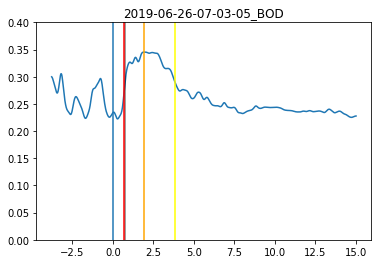

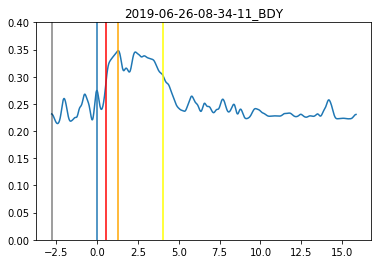

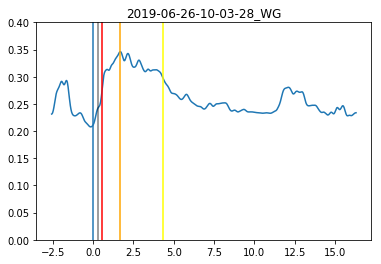

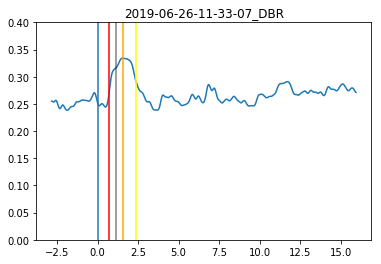

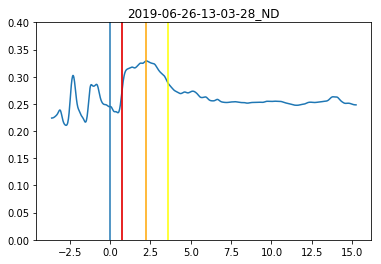

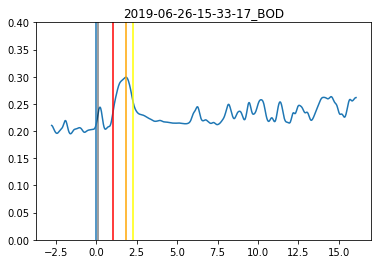

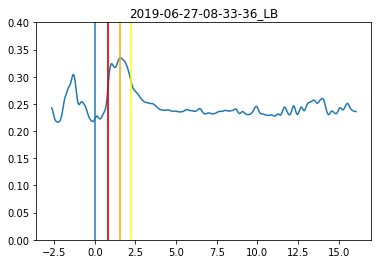

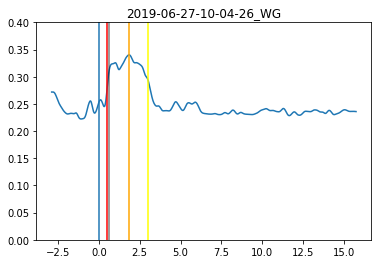

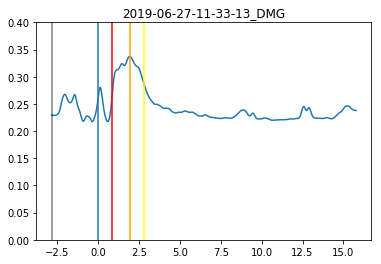

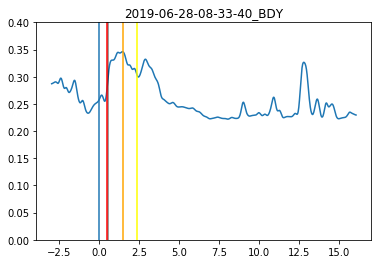

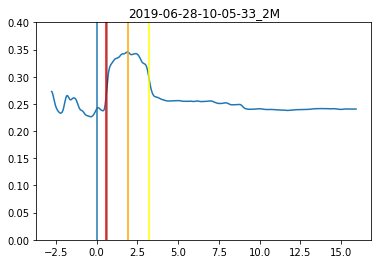

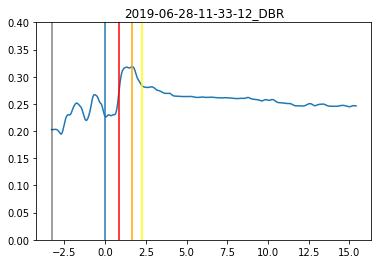

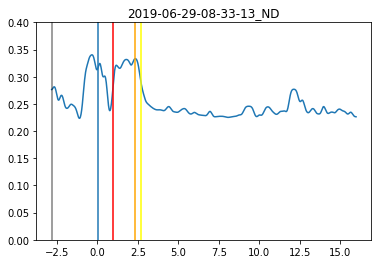

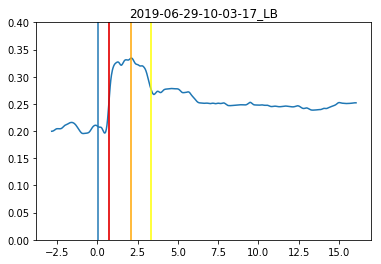

In [137]:
import numpy as np
import os
from matplotlib import pyplot as plt
from pose_class import Trajectory
import pickle

for s in sorted(os.listdir('./SeqClasses/')):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))

    if seq.offset != 0:
        print('running:',seq.seq_name)

        fig,ax = plt.subplots()

        ax.plot(seq.ts,seq.data[:,3,2])
        ax.axvline(seq.tzero)
        ax.axvline(seq.t_latency,color='black',alpha=.5)
        ax.axvline(seq.t_vmax,color='r')
        ax.axvline(seq.t_refraction,color='yellow')
        ax.axvline(seq.t_peak,color='orange')
        #ax.axvline(seq.t_stable_vel,color='black')

        ax.set_ylim([0,.4])
        ax.set_title(seq.seq_name)
        fig.savefig('./figures/posture_plots/' + seq.seq_name + '.png')
    else:
        print('skipping',seq.seq_name,': no timing data')


In [157]:
seq_name = './SeqClasses/2019-05-30-07-07-56_GRG.obj'

seq = pickle.load(open(seq_name,'rb'))
print(seq.t_refraction)

[5.88100004]


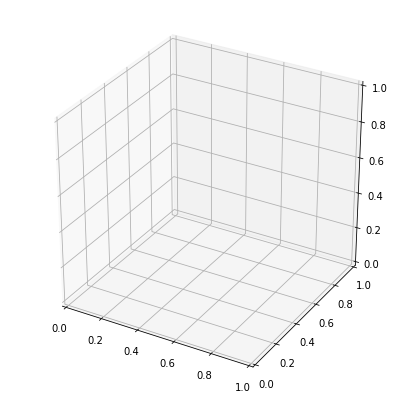

In [392]:
## Make 3d images
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

EC = np.mean(seq.smooth_data[:,[4,12]],1)
SC = np.mean(seq.smooth_data[:,[5,13]],1)
bones = [
    [0,4],  #beak-left eye
    [0,12], #beak-right eye
    [4,12], #right eye-left eye
    [20,21],#eye-center shoulder-center
    [21,7], #shoulder-center left-wrist
    [21,15],#shoulder-center right-wrist
    [21,1], #should-center keel
    [1,2],  #keel-tailbone
    [21,2], #should-center tailbone
    [15,16],#right-wrist right-wingtip
    [7,8],  #left-wrist left-wingtip
    [2,9],  #tailbone left-knee
    [9,10], #left-knee left-ankle
    [2,17], #tailbone right-knee
    [17,18],#right-knee right-ankle
    [10,11],#left-ankle left-heel
    [18,19],#right-ankle right-heel
    [2,3]   #tailbone tail-tip
    ]

bone_colors = ['brown','brown','brown','black',
               'blue','blue','green','green','green','blue','blue',
              'red','red','red','red','red','red','purple']

for t in range(len(seq.ts)):
    ax.scatter(seq.smooth_data[t,:,0],seq.smooth_data[t,:,1],seq.smooth_data[t,:,2])
    full_data = np.empty([len(seq.smooth_data),22,3])
    full_data[:,:20] = seq.smooth_data
    full_data[:,20] = EC
    full_data[:,21] = SC

    for n in range(len(bones)):
        b = bones[n]
        ax.plot(full_data[t,b,0],full_data[t,b,1],full_data[t,b,2],color=bone_colors[n])
    ax.set_xlim([0,.4])
    ax.set_ylim([0,.4])
    ax.set_zlim([0,.4])
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/3d_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()


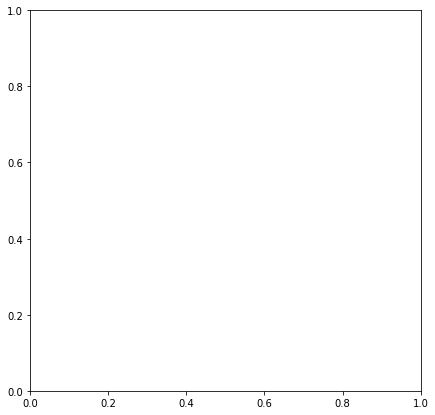

In [391]:
## Make a plot images
#end_t = len(seq.smooth_data)

fig,ax = plt.subplots()
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])


for t in range(len(seq.smooth_data)):
    ax.plot(seq.ts[0:t],seq.smooth_data[0:t,3,2])
    ax.scatter(seq.ts[t],seq.smooth_data[t,3,2],s=40,color='blue')
    ## Plot lines
    if t > seq.tzero_index[0]:
        ax.axvline(seq.tzero,color='gray')
        if t > seq.t_latency_index:
            ax.axvline(seq.t_latency,color='orange')
            if t > seq.vmax_index[0]:
                ax.axvline(seq.t_vmax,color='red')
                if t > seq.stable_vel_index:
                    ax.axvline(seq.t_stable_vel,color='purple')
                    if t > seq.refraction_index[0]:
                        ax.axvline(seq.t_refraction,color='green')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Tail Height (m)')
    ax.set_xlim([seq.ts[0],seq.ts[-1]])
    ax.set_ylim([0,.4])
    
    fig.set_size_inches(7,7)
    fig.savefig('./tmp/test_figs/' + f'{t:04}' + '.png',dpi=300)
    ax.clear()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


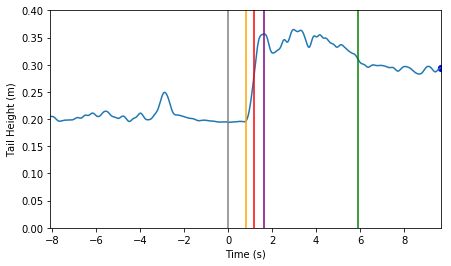

In [395]:
## Make a plot images
#end_t = len(seq.smooth_data)

fig,ax = plt.subplots()
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])

t = 889

ax.plot(seq.ts[0:t],seq.smooth_data[0:t,3,2])
ax.scatter(seq.ts[t],seq.smooth_data[t,3,2],s=40,color='blue')
## Plot lines
if t > seq.tzero_index[0]:
    ax.axvline(seq.tzero,color='gray')
    if t > seq.t_latency_index:
        ax.axvline(seq.t_latency,color='orange')
        if t > seq.vmax_index[0]:
            ax.axvline(seq.t_vmax,color='red')
            if t > seq.stable_vel_index:
                ax.axvline(seq.t_stable_vel,color='purple')
                if t > seq.refraction_index[0]:
                    ax.axvline(seq.t_refraction,color='green')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Tail Height (m)')
ax.set_xlim([seq.ts[0],seq.ts[-1]])
ax.set_ylim([0,.4])

fig.set_size_inches(7,4)
fig.savefig('./tmp/' + 'final_t.png',dpi=300)

fig.show()

In [266]:
test = np.array([1,2,3,4,5])
print(test)
print(np.hstack([test,test*-1]))

[1 2 3 4 5]
[ 1  2  3  4  5 -1 -2 -3 -4 -5]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


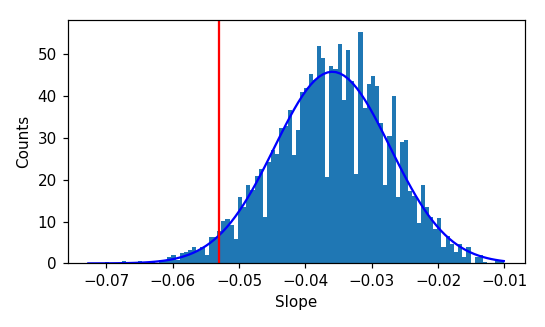

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [487]:
params = CSD_Params()
params.n_blocks = 1
params.n_birds = 18
params.plot_me = True
params.sort_me = True

p,z,(mu,sig,out_params) = csd_sim(params = params)
fig,ax = out_params.fig,out_params.ax

fig.set_size_inches(5,3)

ax.set_xlabel('Slope')
ax.set_ylabel('Counts')
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3b.svg')
fig.savefig('/home/ammon/Desktop/PaperFigs/3b.png')


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


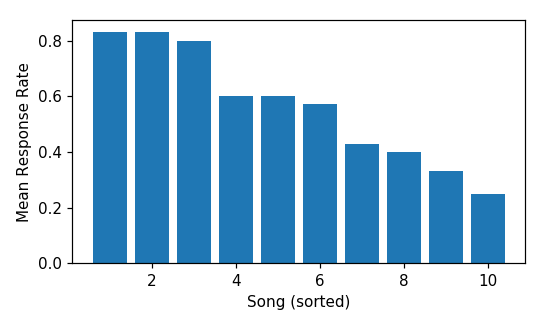

[0.83333333 0.83333333 0.6        0.8        0.6        0.57142857
 0.42857143 0.4        0.25       0.33333333]


In [495]:
fig,ax = plt.subplots()



#bars = np.mean(bv3_array[:,:,:,0] == 1,axis = (0,1))
bars = sorted_means[5]
print(sorted_means[5])
ax.bar(range(1,11),sorted(bars)[::-1])

ax.set_ylabel('Mean Response Rate')
ax.set_xlabel('Song (sorted)')

fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig('/home/ammon/Desktop/PaperFigs/3a.png')
fig.savefig('/home/ammon/Desktop/PaperFigs/3a.svg')

fig.show()

In [530]:
## Calculate which birds are selective
mean_posture_bybird = np.mean(bv3_array[:,:,:,0] == 1,axis=(1))

responsivity_by_bird = np.mean(mean_posture_bybird,1)
print(responsivity_by_bird)

for b in range(18):
    sorted_means_b = np.sort(mean_posture_bybird[b])[::-1]
    #slope,intercept = np.polyfit(range(10), mean_posture_bybird[b],1)
    slope,intercept = np.polyfit(range(10),sorted_means_b,1)
    r_resp = responsivity_by_bird[b]
    params = CSD_Params(sort_me=True)
    p,z,_ = csd_sim(slope,r_resp,params=params)

    if p < .1:
        print('*')
    if p < .002:
        print('****')
    print(slope,r_resp)
    print(p,z)

[0.         0.02727273 0.20909091 0.09090909 0.43636364 0.25454545
 0.         0.18181818 0.         0.16363636 0.23636364 0.4
 0.20909091 0.         0.27272727 0.         0.16363636 0.37272727]
0.0 0.0
0.3750878226973865 0.31840776966156586
-0.013774104683195593 0.02727272727272727
0.3593751195929442 -0.360129571930948
*
-0.065564738292011 0.20909090909090908
0.0028346941163711393 -2.766314194846686
-0.03415977961432506 0.09090909090909091
0.12836146942728616 -1.1341707309732978
-0.049586776859504106 0.43636363636363634
0.4313857649667499 -0.17284720661095404
*
-0.05730027548209363 0.2545454545454545
0.060811886725776726 -1.547993865607253
0.0 0.0
0.3759441858854125 0.3161503757275175
-0.03856749311294764 0.18181818181818182
0.40145581579635464 -0.24958069212657427
0.0 0.0
0.3749607380553871 0.31874290585515147
*
-0.04958677685950411 0.16363636363636364
0.04838302584857539 -1.6607381307637281
*
-0.06831955922865013 0.2363636363636364
0.0029111158185562394 -2.7576285463922545
*
-0.0727

Actual responsivity: 0.5644378363805477
-0.006060606060606045
(18, 11, 10, 3)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


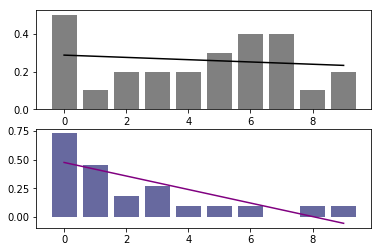

In [942]:
## Generate lots of slopes
import random
from scipy.stats import norm

print('Actual responsivity:',np.mean(block_means[:10,0]))


mean_posture3 = np.mean(bv3_array[:,:,:,0] == 1,axis=(1,0))


iterations = 10000
birds = 10
model_birds = False
blocks = 10
songs = 10
responsiveness = .30



slopes = np.empty(iterations)
slopes0 = np.empty(iterations)

for i in range(iterations):
    postures = np.zeros([blocks,songs])
    for b in range(blocks):
        for s in range(songs):
            if random.random() <= responsiveness:
                postures[b,s] = 1

    counts = np.sum(postures,0)

    
    sorted_counts = counts
    sorted_counts = np.sort(counts)[::-1]
    
    ratios = counts / blocks
    
    sorted_ratios = sorted_counts / blocks
    
    slope0,intercept0 = np.polyfit(range(len(ratios)),ratios,1)
    slope,intercept = np.polyfit(range(len(sorted_ratios)), sorted_ratios,1)
    
    fit_line0 = np.poly1d([slope0,intercept0])
    fit_line = np.poly1d([slope,intercept])
    #fit_line = np.poly1d(np.polyfit(range(len(sorted_ratios)), sorted_ratios, 1))

    #slope, intercept = fit_line
    slopes0[i] = slope0
    slopes[i] = slope
    
fig,(ax,ax2) = plt.subplots(2)

ax.bar(range(10),ratios,color='gray')
ax.plot(np.arange(10),fit_line0(np.arange(10)),color='black')
print(slope0)
print(np.shape(binary_array3))

demo_slopes = np.nanmean(binary_array3[5+7,:,:,0],axis=(0))
fit_line1 = np.poly1d(np.polyfit(range(10),demo_slopes[song_order],1))
ax2.bar(np.arange(10),demo_slopes[song_order],color=color_map(5/25),alpha=.8)
ax2.plot(np.arange(10),fit_line1(np.arange(10)),color='purple')
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


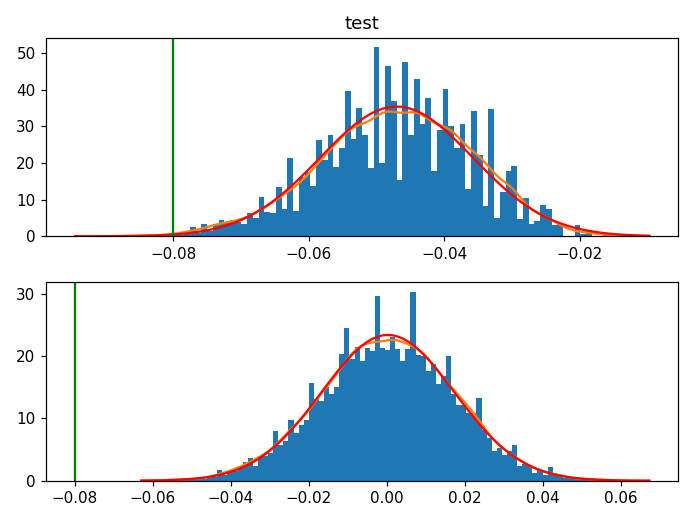

z score: -2.922587611509604
0.00347135944713233
z score: -4.70673961783492
2.51710078771551e-06


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [278]:
## Do some stats

from scipy.stats import norm

fig,(ax,ax2) = plt.subplots(2)
ax.hist(slopes,bins=100,normed=True)

#ax.set_yscale('log')



fit_kde = gaussian_kde(slopes)
mu,sig = (np.mean(slopes),np.std(slopes))

xs = np.linspace(min(slopes),max(slopes),100)

ax.plot(xs,fit_kde(xs))
ax.plot(xs,norm.pdf(xs,mu,sig),color='red')

x = -.08
z = (x - mu) / sig
ax.axvline(x,color='green')
print('z score:',z)

p_value = norm.sf(abs(z))*2 #twosided
print(p_value)

fit_kde0 = gaussian_kde(slopes0)
mu0,sig0 = (np.mean(slopes0),np.std(slopes0))

xs0 = np.linspace(min(slopes0),max(slopes0),100)

ax2.hist(slopes0,bins=100,normed=True)
ax2.plot(xs0,fit_kde0(xs0))
ax2.plot(xs0,norm.pdf(xs0,mu0,sig0),color='red')

z0 = (x - mu0) / sig0
ax2.axvline(x,color='green')
print('z score:',z0)

p_value0 = norm.sf(abs(z0))*2 #twosided
print(p_value0)

ax.set_title('test')
fig.tight_layout()
fig.show()



In [262]:
print('Actual responsivity:',np.mean(block_means[:10,0]))

print(np.shape(bv3_array))
mean_posture_bybird = np.mean(bv3_array[:,:,:,0] == 1,axis=(1))

for b in range(18):
    slope,intercept = np.polyfit(range(10), mean_posture_bybird[b],1)
    z = (slope - mu0) / sig0
    p = norm.sf(abs(z))*2
    print('Bird:',b,'slope=',slope)
    print('z-score:',z,'p-value=',p)


Actual responsivity: 0.5644378363805477
(18, 11, 10, 3)
Bird: 0 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 1 slope= 0.012672176308539946
z-score: 0.7369628655697043 p-value= 0.46114493202700846
Bird: 2 slope= -0.030303030303030287
z-score: -1.753666517956419 p-value= 0.07948766587560953
Bird: 3 slope= -0.028650137741046824
z-score: -1.6578730801284915 p-value= 0.09734308674352263
Bird: 4 slope= -0.0011019283746556408
z-score: -0.06131578299636081 p-value= 0.9511077214389023
Bird: 5 slope= -0.035261707988980706
z-score: -2.0410468314402026 p-value= 0.04124617240721859
Bird: 6 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 7 slope= -0.006611570247933875
z-score: -0.3806272424227868 p-value= 0.7034798637499572
Bird: 8 slope= 0.0
z-score: 0.0025465088889240354 p-value= 0.997968182069538
Bird: 9 slope= -0.023140495867768576
z-score: -1.3385616207020647 p-value= 0.18071342737275498
Bird: 10 slope= -0.03195592286501376
z-score: -1.84

In [36]:
peak  = seq.peak_height
half_peak = peak - (peak - seq.baseline) / 2
refraction_range = seq.data[:,3,2][seq.ts > seq.t_peak]
print(half_peak)

refraction_point = np.argmax(refraction_range < half_peak)
refraction_point == 0

AttributeError: 'Trajectory' object has no attribute 'peak_height'

In [21]:
seq_trajectory = pca.transform(seq.all_distances)

<IPython.core.display.Javascript object>


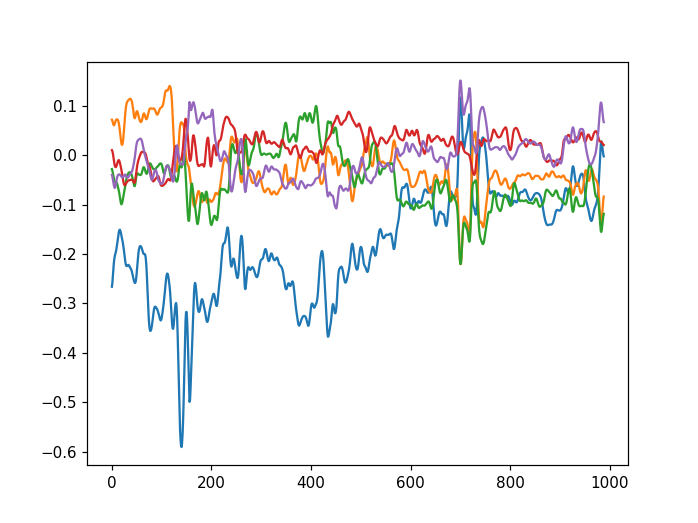

In [22]:
%matplotlib notebook



fig, ax = plt.subplots()

ax.plot(seq_trajectory[:,:5])


fig.show()

<IPython.core.display.Javascript object>


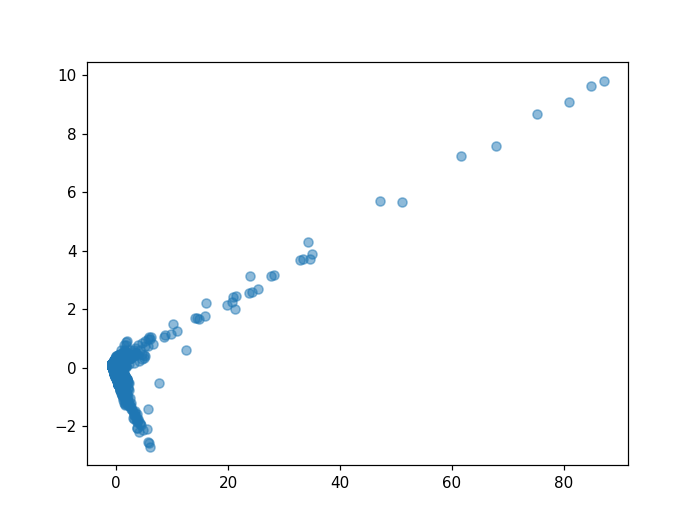

In [26]:
fig,ax = plt.subplots()

ax.scatter(principalComponents[:,0],principalComponents[:,1], alpha=.5)

fig.show()

In [2]:
from pose_class import Trajectory

/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-17-17-10-27_BOD.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-16-11-40-27_WG.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019_timestamps_birdview-2/2019-06-16-07-10-26_2M.wav.txt"
  bv2TimeDict[seq_name] = np.genfromtxt(bv2TimeDir + '/' + file_name,usecols=[1])
/home/ammon/Documents/Scripts/AnalyzePosture/pose_class.py:53: UserWarning: genfromtxt: Empty input file: "/data/birds/postures/birdview2-2019/2019

In [4]:
import numpy as np

song_list = np.genfromtxt('./song_list.txt',dtype=str)

array(['BOD', 'BDY', 'LNR', 'ND', '2M', 'LB', 'DMG', 'DRG', 'DBR', 'WG',
       'm2M', 'mBDY', 'mBOD', 'mDBR', 'mDMG', 'mGRG', 'mLB', 'mLNR',
       'mND', 'mWG', 'LB-', 'BDY-'], dtype='<U4')

In [14]:
import pickle, os 
song_list = np.genfromtxt('./song_list.txt',dtype=str)
song_counts = dict(zip(song_list,[0]*len(song_list)))
machine_counts = {'birdview':0,'birdview-2':0}
bird_counts = {}
weird_songs = []

for s in os.listdir('./SeqClasses/'):
    seq = pickle.load(open('./SeqClasses/' + s,'rb'))
    if seq.bird in bird_counts.keys():
        bird_counts[seq.bird] += 1
    else:
        bird_counts[seq.bird] = 1
    if seq.song in song_counts.keys():
        song_counts[seq.song] += 1
    else:
        weird_songs.append(seq.song)
    machine_counts[seq.machine] +=1
    

[11, 27, 12, 18, 17, 11, 11, 0, 9, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [11 27 12 18 17 11 11  0  9 15  0  0  0  0  0  0  0  0  0  0  0  0]]
(2, 22)
[10 19 18 17 16 15 14 13 12 11 21  7 20  8  6  5  0  2  9  4  3  1]
[[ 1  3  4  9  2  0  5  6  8 20  7 21 11 12 13 14 15 16 17 18 19 10]
 [27 18 17 15 12 11 11 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0]]
['BOD' 'BDY' 'LNR' 'ND' '2M' 'LB' 'DMG' 'DRG' 'DBR' 'WG' 'm2M' 'mBDY'
 'mBOD' 'mDBR' 'mDMG' 'mGRG' 'mLB' 'mLNR' 'mND' 'mWG' 'LB-' 'BDY-']


<IPython.core.display.Javascript object>


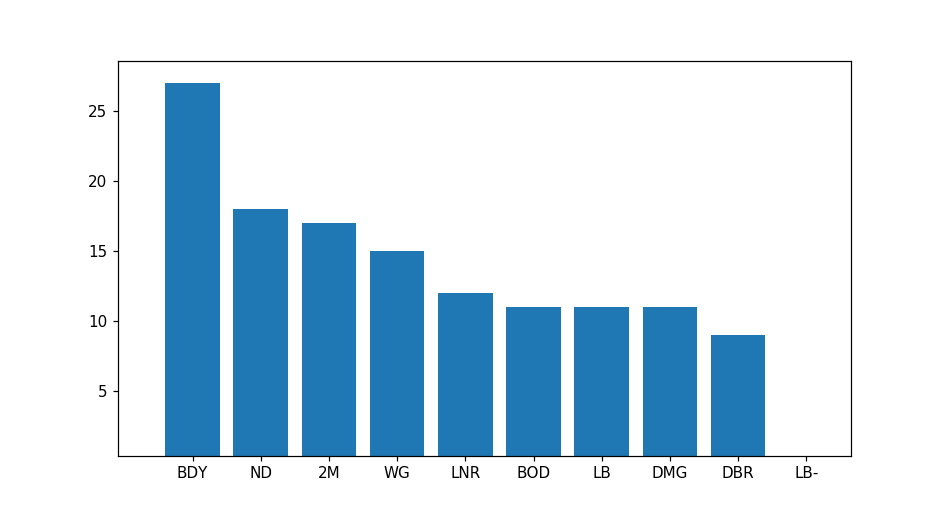

In [45]:
from matplotlib import pyplot as plt

%matplotlib notebook
test0 = list(song_counts.keys())
test1 = list(song_counts.values())
test1 = [int(x) for x in test1]

print(test1)
test_array = np.array([range(len(test1)),test1])
print(test_array)

print(np.shape(test_array))
print(test_array[1,:].argsort())
sorted_array = test_array[:,test_array[1,:].argsort()[::-1]]

print(sorted_array)
print(song_list)

fig,ax = plt.subplots()

ax.bar(range(len(song_list)),sorted_array[1,:])
song_array = np.array(song_list)
ax.set_xticks(range(len(song_list)))
ax.set_xticklabels(song_array[sorted_array[0,:]])
fig.show()

In [47]:
import pickle

postures = [0] * 6
seqs = [0] * 6

postures[0] = './SeqClasses/2019-05-30-10-02-55_BDY.obj'
postures[1] = './SeqClasses/2019-06-15-13-03-41_BOD.obj'
postures[2] = './SeqClasses/2019-06-27-13-16-14_BOD.obj'
postures[3] = './SeqClasses/2019-07-05-13-12-38_LB.obj'
postures[4] = './SeqClasses/2019-06-30-15-46-15_DBR.obj'
postures[5] = './SeqClasses/2019-06-20-07-04-33_2M.obj'

for p in range(6):
    seqs[p] = pickle.load(open(postures[p],'rb'))

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


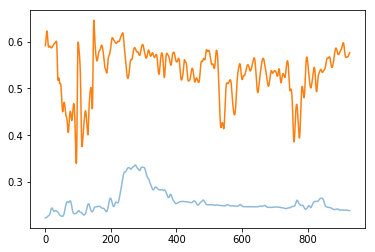

In [64]:
fig, ax = plt.subplots()


ax.plot(seqs[5].data[:,3,2],alpha=.5)
ax.plot(np.abs(seqs[5].all_angles[:,6]) * .01)
fig.show()